<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Web Scraping and Salary Prediction

## 02. Modelling

<br/><br/>

This project was completed during my Data Science Immersive bootcamp at General Assembly in London.

The project aims to determine the industry factors that are most important in predicting the salary amounts in various data related fields.  
To achieve this, I decided to collect and analyse data from a job aggregator website, Indeed.com.  
To limit the scope, it was suggested to *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others relevant terms. In addition, I could decrease the scope by *limiting the search to a single region.*  



**Goals:**
- Scrape data from a job aggregation tool in order to collect the data to best answer the initial question.
- Discover which job features impact salary the most.
- Create a classification model to predict whether a job will pay more or less than the median salary, based on the features of the job.  

<br/><br/>

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead I just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, I'll split the salary into two groups of high and low salary, by choosing the median salary as a threshold (in principle I could choose any single or multiple splitting points).  

<br/><br/>

## Libraries Import  

<br/><br/>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use('fivethirtyeight')
sns.set(font_scale=1)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# run to avoid warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn import metrics, tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Modelling  

<br/><br/>

We want to predict High/Low salary and will start by using only the location (State) as a modelling feature.  
After a few initial models, we'll create new variables in the dataframe to represent interesting features of a job title or the job snippet (e.g. whether 'Senior' or 'Manager' is in the title).  
Then, we'll build and tune new classification models which include those new features, finally evaluating how they affect the models and whether they add any value.  


<br/><br/>

In [5]:
# Loading the data from CSV for consistency reasons
df = pd.read_csv('datasets/df.csv')

### *A. Using only the State as a modelling feature*

In [6]:
# Choosing predictor and target variables using only location (State) as feature
X = df[['company_state']]
X = pd.get_dummies(X, drop_first=True)
y = df['high_salary']

In [7]:
# Displaying the predictor matrix
X.head()

company_state_CA  company_state_CO  company_state_CT  company_state_DE  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   company_state_FL  company_state_GA  company_state_IL  company_state_IN  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   company_state_KS  company_state_KY  ...  company_state_NM  \
0                 0                 0  ...                 1   
1                 0                 0  ...                 1   
2                 0                 0  ...                 1   
3                 0                 0  ...                 1   
4                 0                 0  ...                 1   

   company_state_NY  company_state_OH  company_state_OR  company_state_PA  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   company_state_SC  company_state_TN  company_state_TX  company_state_UT  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   company_state_WA  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  

[5 rows x 28 columns]

In [8]:
# Creating a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

In [9]:
# Checking the shape of the modelling sets
print('Training set shape')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('')
print('Test set shape')
print('X:', X_test.shape)
print('y:', y_test.shape)

Training set shape
X: (10688, 28)
y: (10688,)

Test set shape
X: (2672, 28)
y: (2672,)


In [10]:
# Instantiating the scaler
scaler = StandardScaler()

# Rescaling variables
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### Logistic Regression

In [11]:
# Instantiating the model 
logreg = LogisticRegression(solver='saga', multi_class='auto', max_iter=1000)

# Fitting the model
logreg.fit(X_train, y_train)

# Calculating the scores
a_logreg_train = logreg.score(X_train, y_train)
a_logreg_test = logreg.score(X_test, y_test)
a_logreg_cv = (cross_val_score(logreg, X_train, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
a_logreg_df = pd.DataFrame([a_logreg_train, a_logreg_test, a_logreg_cv],
                         index = ['train', 'test', 'CV'], columns=['A. Logistic Reg'])

print('A. Logistic Regression Scores: \n')
print('train score: ', a_logreg_train)
print('test score: ', a_logreg_test)
print('CV score: ', a_logreg_cv)

A. Logistic Regression Scores: 

train score:  0.5736339820359282
test score:  0.5568862275449101
CV score:  0.569329206125645


Feature Importance & Model Coefficients

In [12]:
# Collecting the model coefficients in a dataframe
lr_coef = pd.DataFrame(logreg.coef_[0], index=X_train.columns, columns=['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[:5]

coefficients
company_state_CA      0.316501
company_state_NY      0.315103
company_state_CO      0.168138
company_state_GA      0.109860
company_state_MA      0.097583

In [13]:
# Adding odds ratios in the dataframe
lr_coef['odds_ratio'] = np.exp(lr_coef['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)

coefficients  odds_ratio
company_state_CA      0.316501    1.372317
company_state_NY      0.315103    1.370401
company_state_CO      0.168138    1.183100
company_state_GA      0.109860    1.116122
company_state_MA      0.097583    1.102503
company_state_IL      0.096979    1.101837
company_state_TX      0.092761    1.097200
company_state_MD      0.076176    1.079152
company_state_WA      0.066406    1.068661
company_state_TN      0.063983    1.066074
company_state_MN      0.058115    1.059837
company_state_DE      0.057253    1.058924
company_state_UT      0.052691    1.054104
company_state_KS      0.047482    1.048627
company_state_PA      0.038405    1.039152
company_state_NC      0.032662    1.033202
company_state_OH      0.031390    1.031888
company_state_NM      0.017472    1.017625
company_state_MI      0.016088    1.016218
company_state_OR      0.010250    1.010302
company_state_CT      0.000000    1.000000
company_state_KY     -0.008490    0.991546
company_state_SC     -0.012742    0.987339
company_state_NJ     -0.024846    0.975460
company_state_FL     -0.029910    0.970533
company_state_MO     -0.056690    0.944887
company_state_LA     -0.070660    0.931779
company_state_IN     -0.086361    0.917263

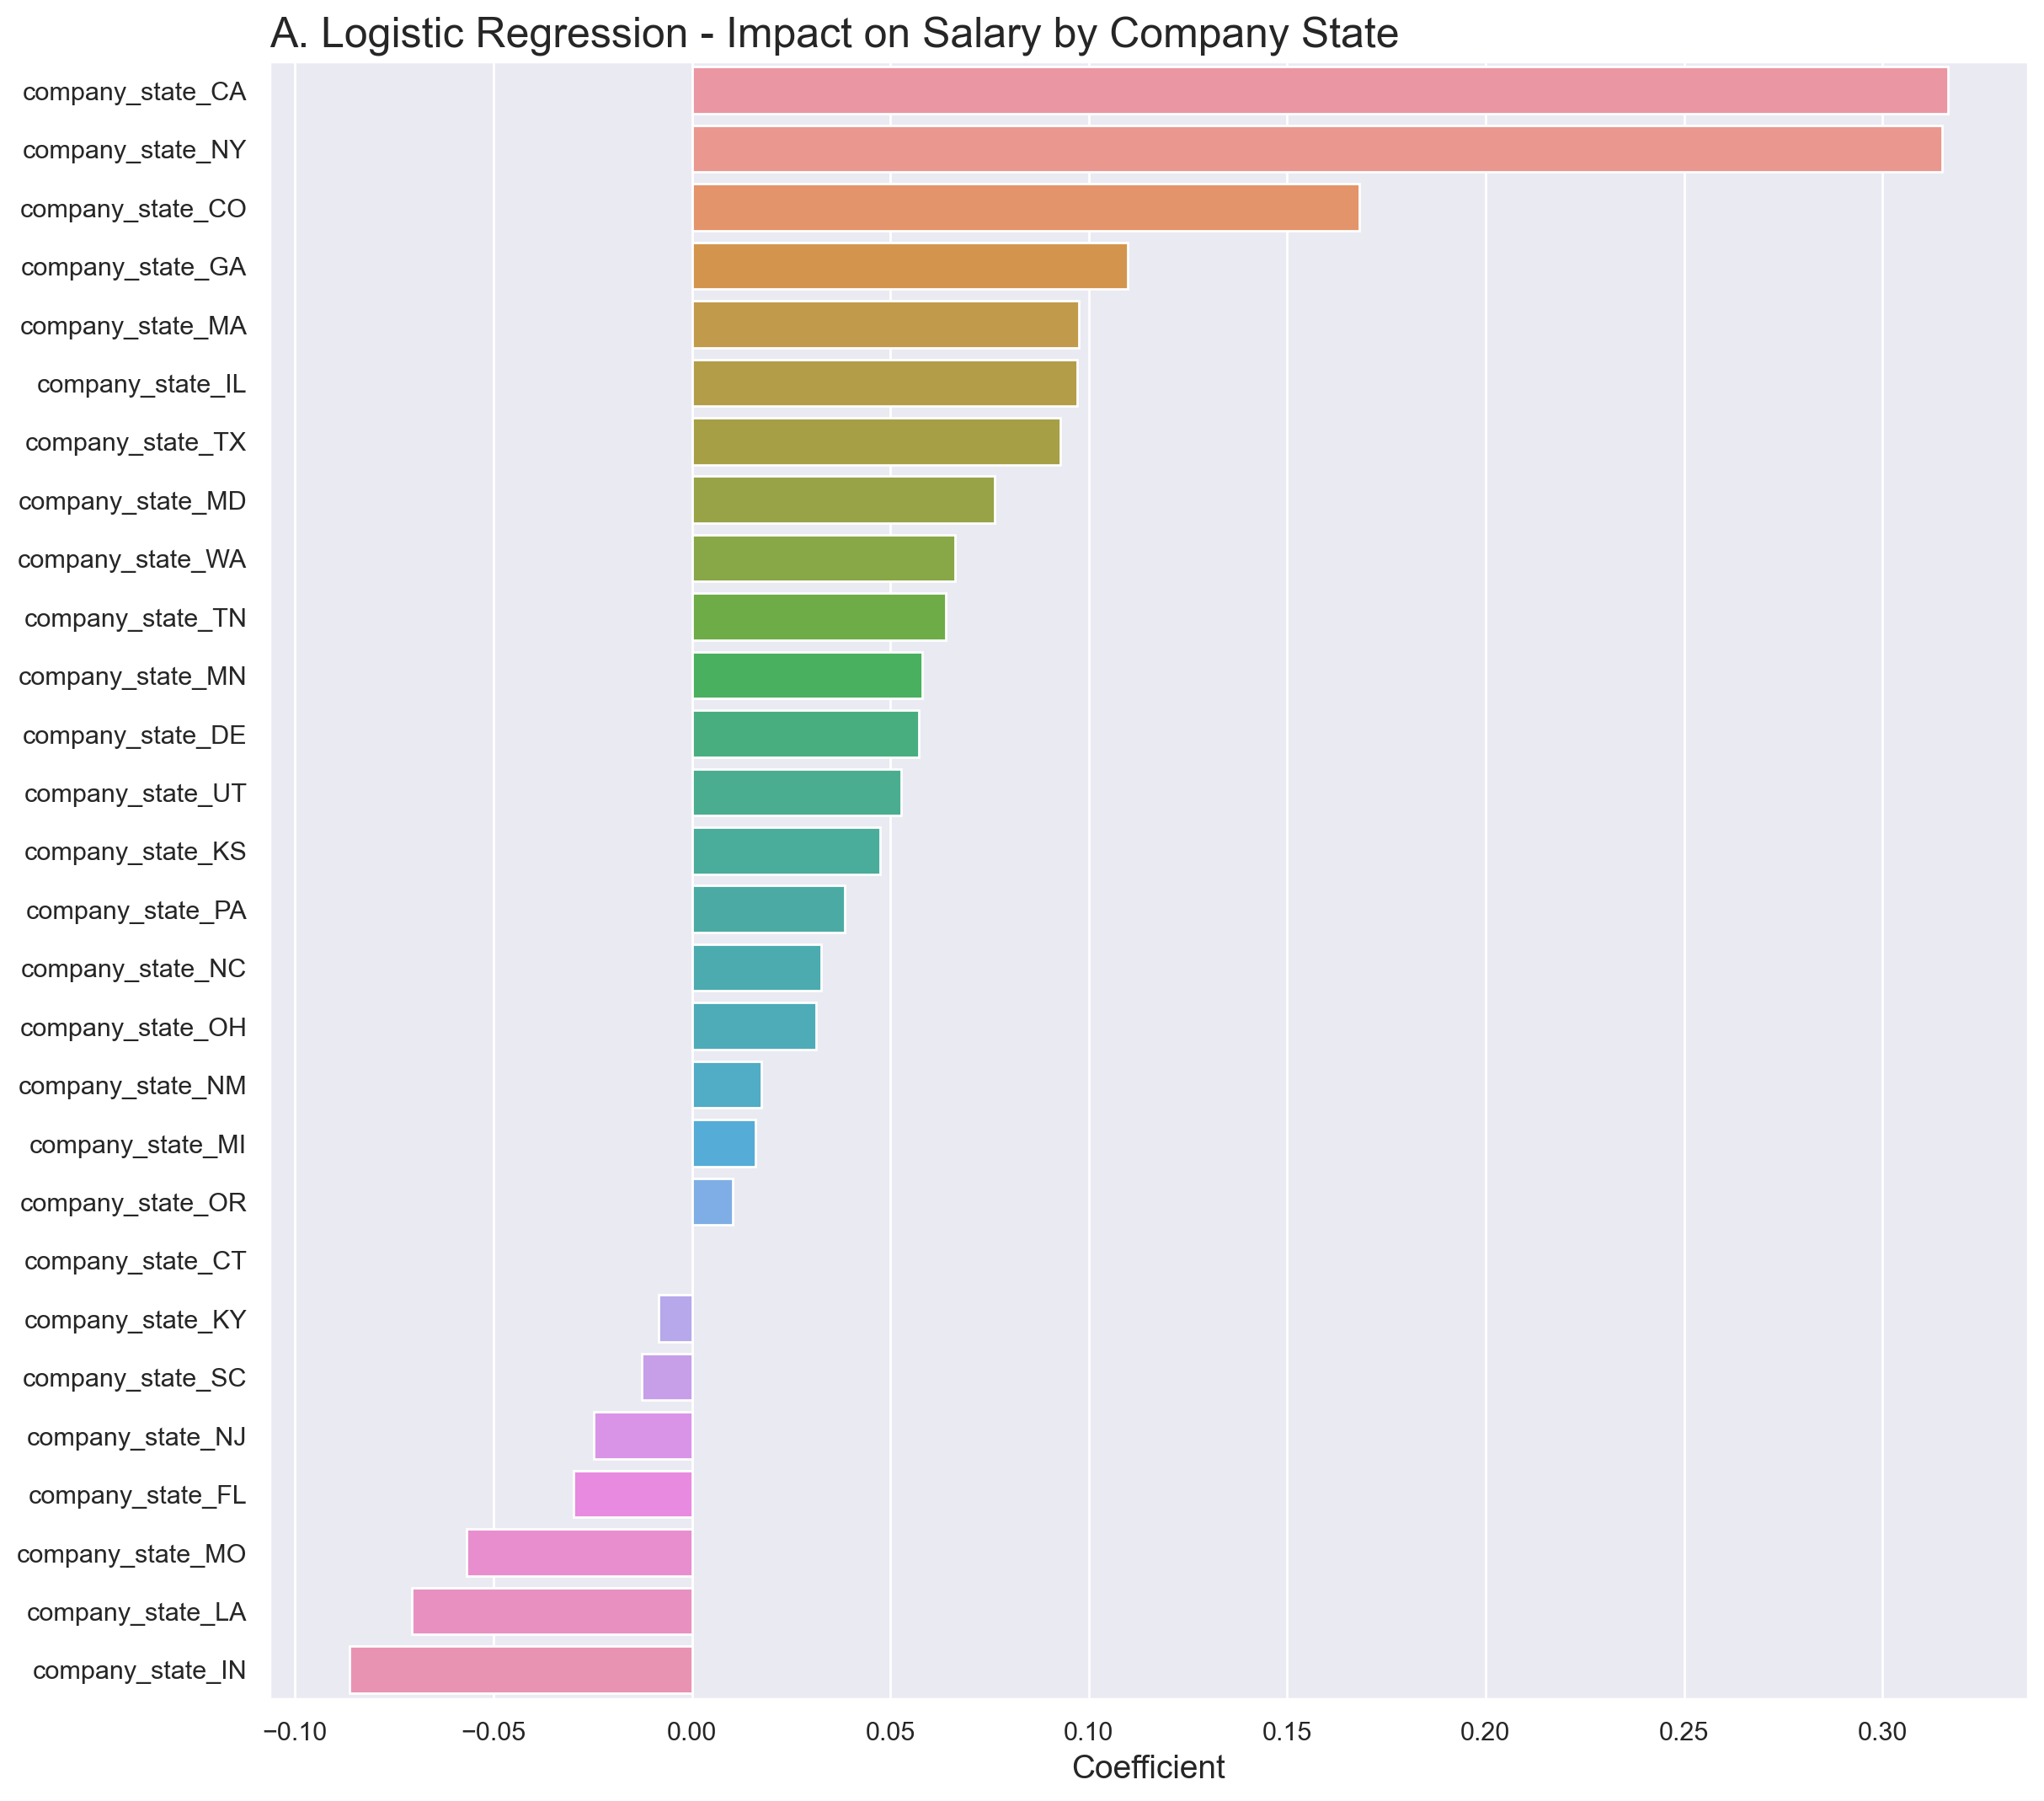

In [14]:
# Plotting the coefficients
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=lr_coef.coefficients.values, y=lr_coef.coefficients.index,
            order=lr_coef.sort_values('coefficients', ascending=False).index, ax=ax)
ax.set_title('A. Logistic Regression - Impact on Salary by Company State', loc='left', fontsize=18)
ax.set_xlabel('Coefficient', fontsize = 14)

plt.show()

Logistic Regression coefficients describe the size and the direction of the relationship between a predictor and the target variable.  
Similarly, the odds ratio is a statistic that quantifies the strength of the association between two events.

In this model, a job located in the states of **California**, **New York** and **Colorado** has a large influence on having a high paying salary since their coefficients are positive and relatively large: there is a 37% increase in the odds of earning a high salary with a job located in California and New York (18% for Colorado).   
On the other side, job openings located in **Indiana**, **Louisiana** and **Missouri** have relatively large (and negative) coefficients, so in those locations the salary would likely be well below median: there is a 9% decrease in the odds of earning a high salary (or a 9% increase in the odds of earning a low salary) with a job located in Indiana (7% for Louisiana and 6% for Missouri).

<br/><br/>

Classification Report

In [15]:
predictions = logreg.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.55      0.56      0.56      1320
           1       0.56      0.55      0.56      1352

    accuracy                           0.56      2672
   macro avg       0.56      0.56      0.56      2672
weighted avg       0.56      0.56      0.56      2672



Confusion Matrix

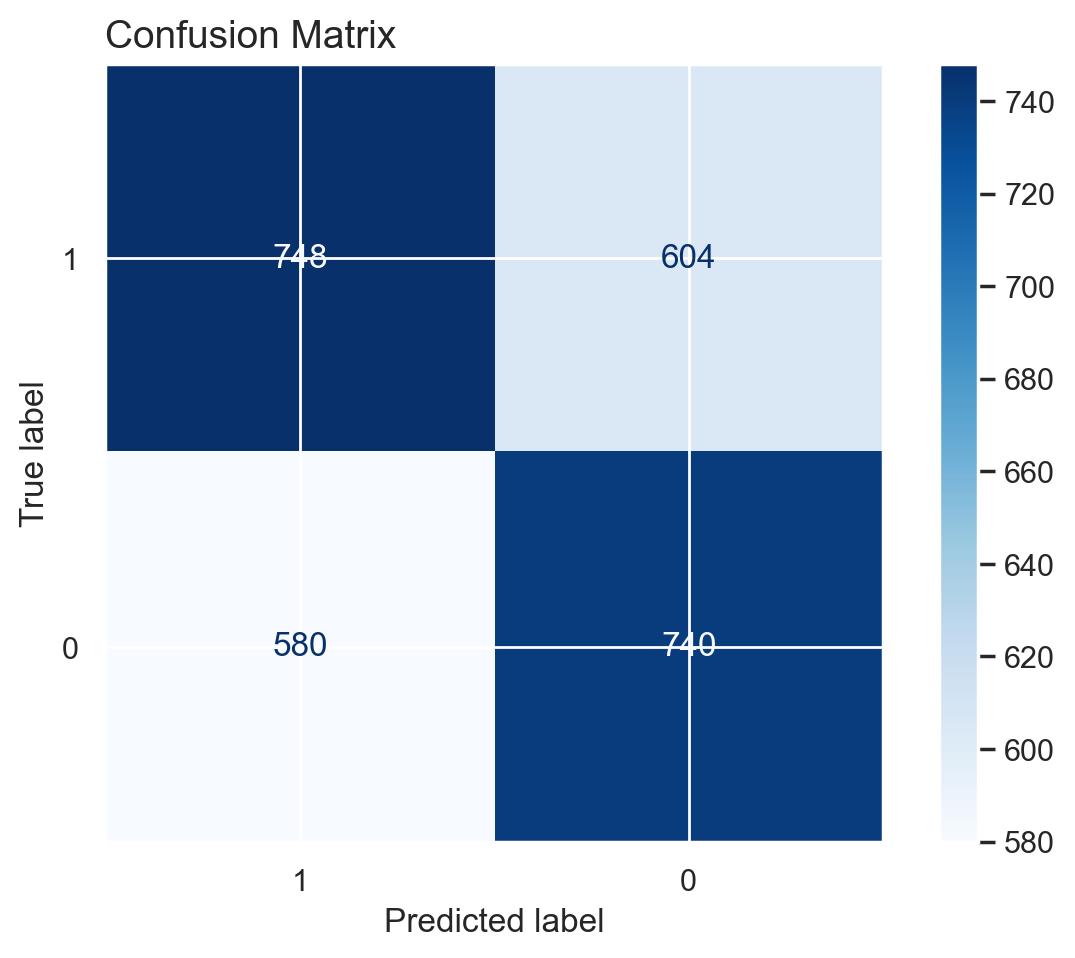

In [16]:
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

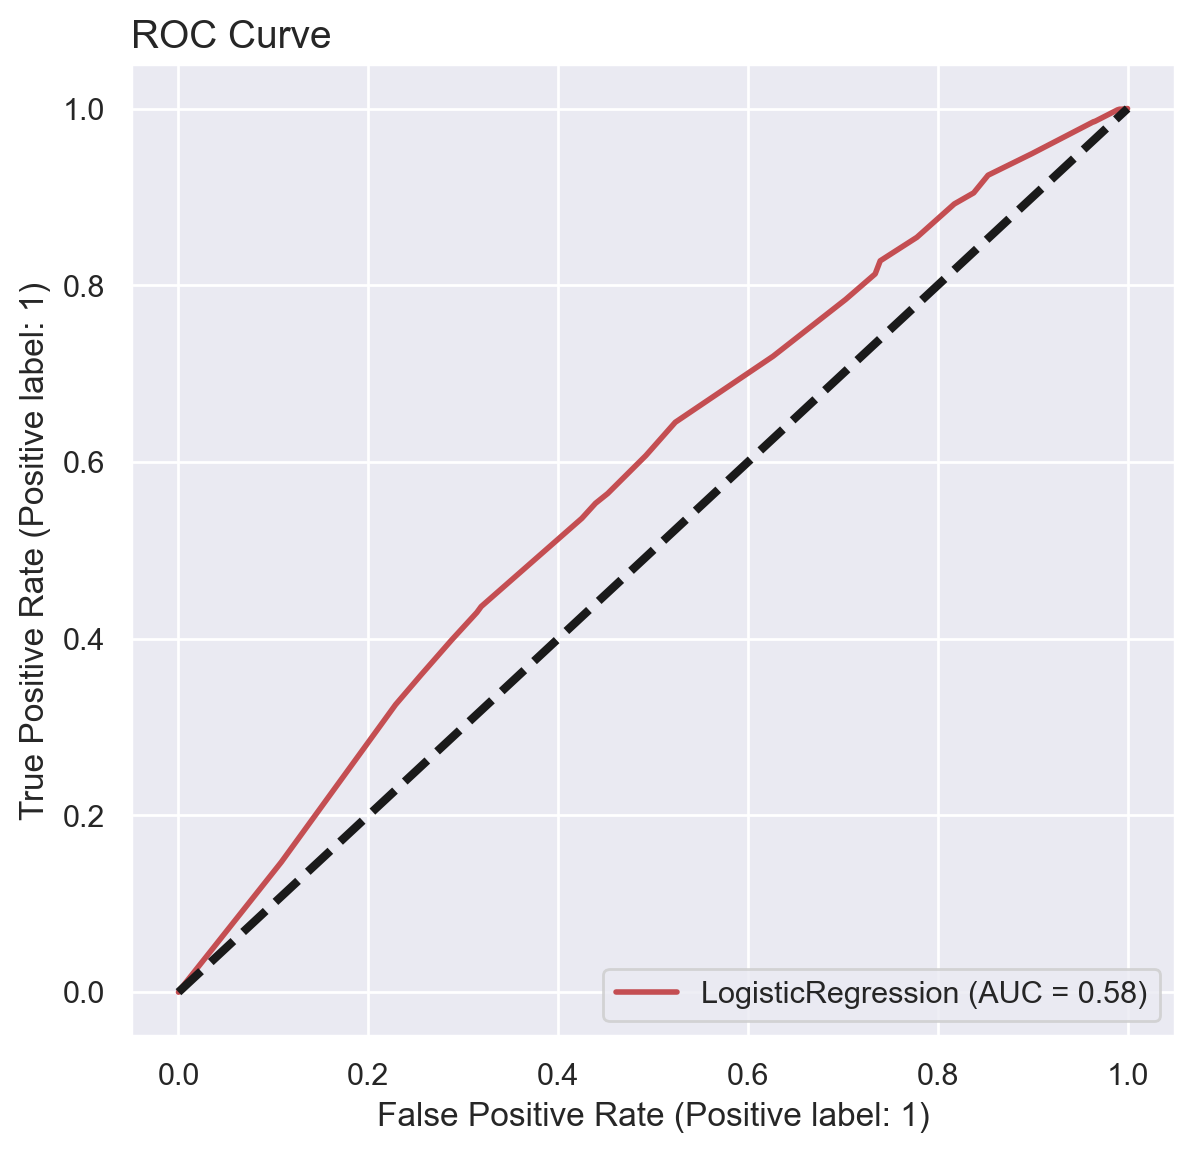

In [17]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(logreg, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [18]:
print('ROC-AUC Score:', roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.5781916801147571


Precision-Recall Curve

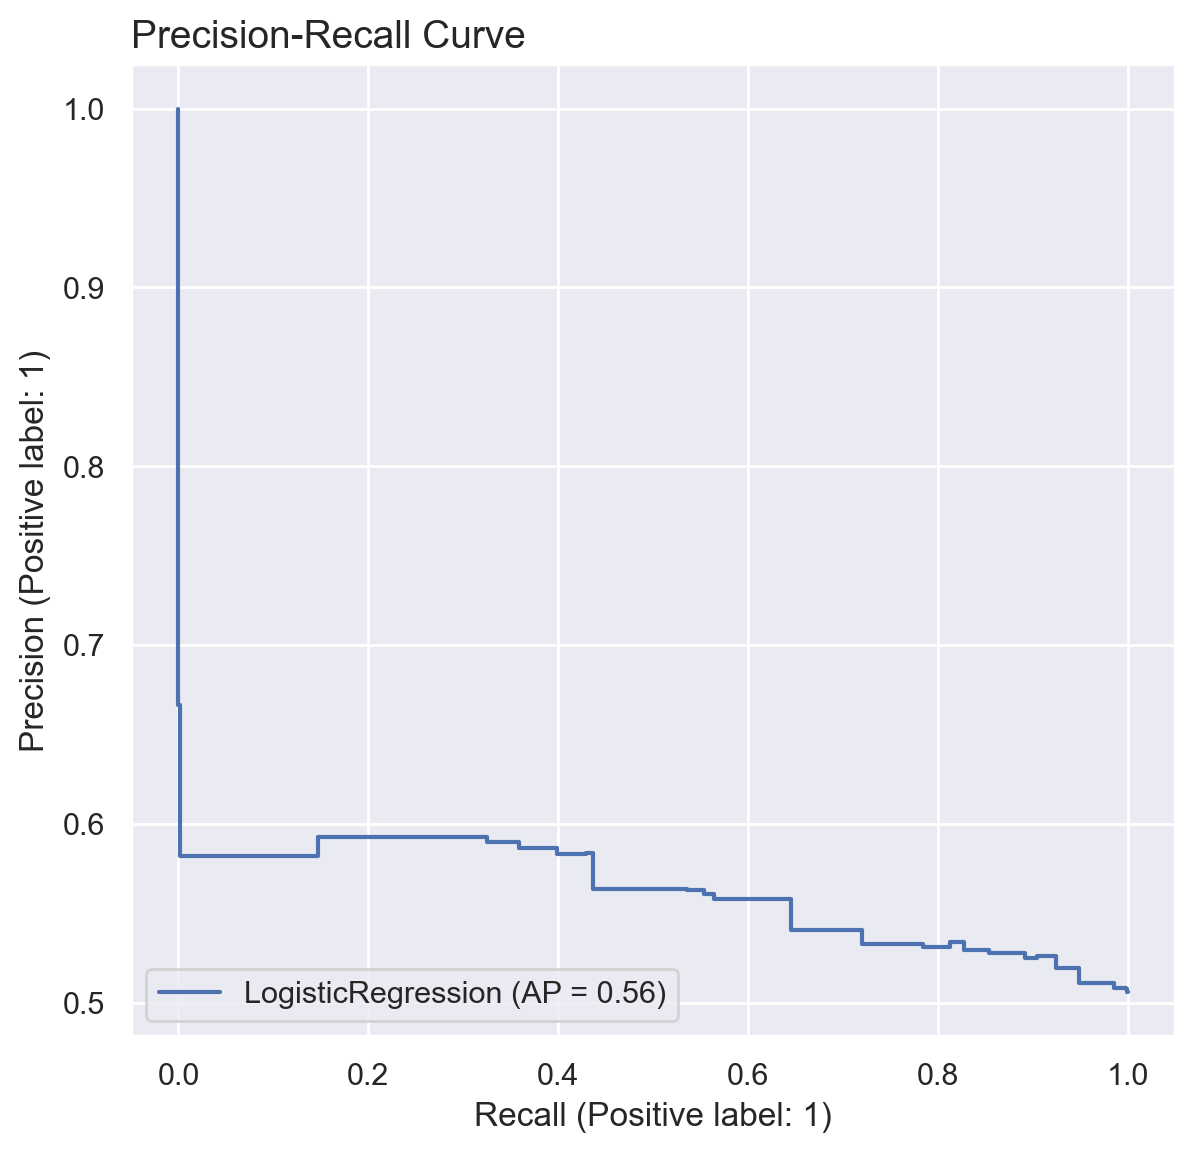

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(logreg, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, however the accuracy of the model is quite low.  
The area under the curve is **0.58**, which tells us that this model has a bad class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.56**, the curve descends in a typical non-monotonic fashion, and the precision starts very low at **0.58**.  

<br/><br/>

#### Decision Tree with GridSearchCV

In [20]:
# Defining gridsearch parameters
dtree_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]}


# Defining the model
dtree = DecisionTreeClassifier(criterion='gini', random_state=1)

# Instantiating the gridsearch
dtc_gs = GridSearchCV(dtree, dtree_params, cv=5, n_jobs=10, verbose=1)

# Fitting the gridsearch
dtc_gs.fit(X_train, y_train)

# Extracting the model with the best parameters found in the gridsearch
dt_best = dtc_gs.best_estimator_

# Calculating the scores
a_dt_train = dt_best.score(X_train, y_train)
a_dt_test = dt_best.score(X_test, y_test)
a_dt_cv = (cross_val_score(dt_best, X_train, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
a_dt_df = pd.DataFrame([a_dt_train, a_dt_test, a_dt_cv],
                       index = ['train', 'test', 'CV'], columns = ['A. Decision Tree'])

print('A. Decision Tree Classifier Scores: \n')
print('train score: ', a_dt_train)
print('test score: ', a_dt_test)
print('CV score: ', a_dt_cv)

Fitting 5 folds for each of 1936 candidates, totalling 9680 fits
A. Decision Tree Classifier Scores: 

train score:  0.5736339820359282
test score:  0.5568862275449101
CV score:  0.569329206125645


Feature Importance & Model Coefficients

In [21]:
# Collecting the model coefficients in a dataframe
dt_coef = pd.DataFrame(dt_best.feature_importances_, columns=['importance'], index=X.columns)
dt_coef.sort_values(by = 'importance', ascending = False)[:10]

importance
company_state_NY    0.343686
company_state_CA    0.253823
company_state_MO    0.079302
company_state_FL    0.073159
company_state_LA    0.048510
company_state_CO    0.038840
company_state_GA    0.028183
company_state_IL    0.022941
company_state_MA    0.020391
company_state_DE    0.015531

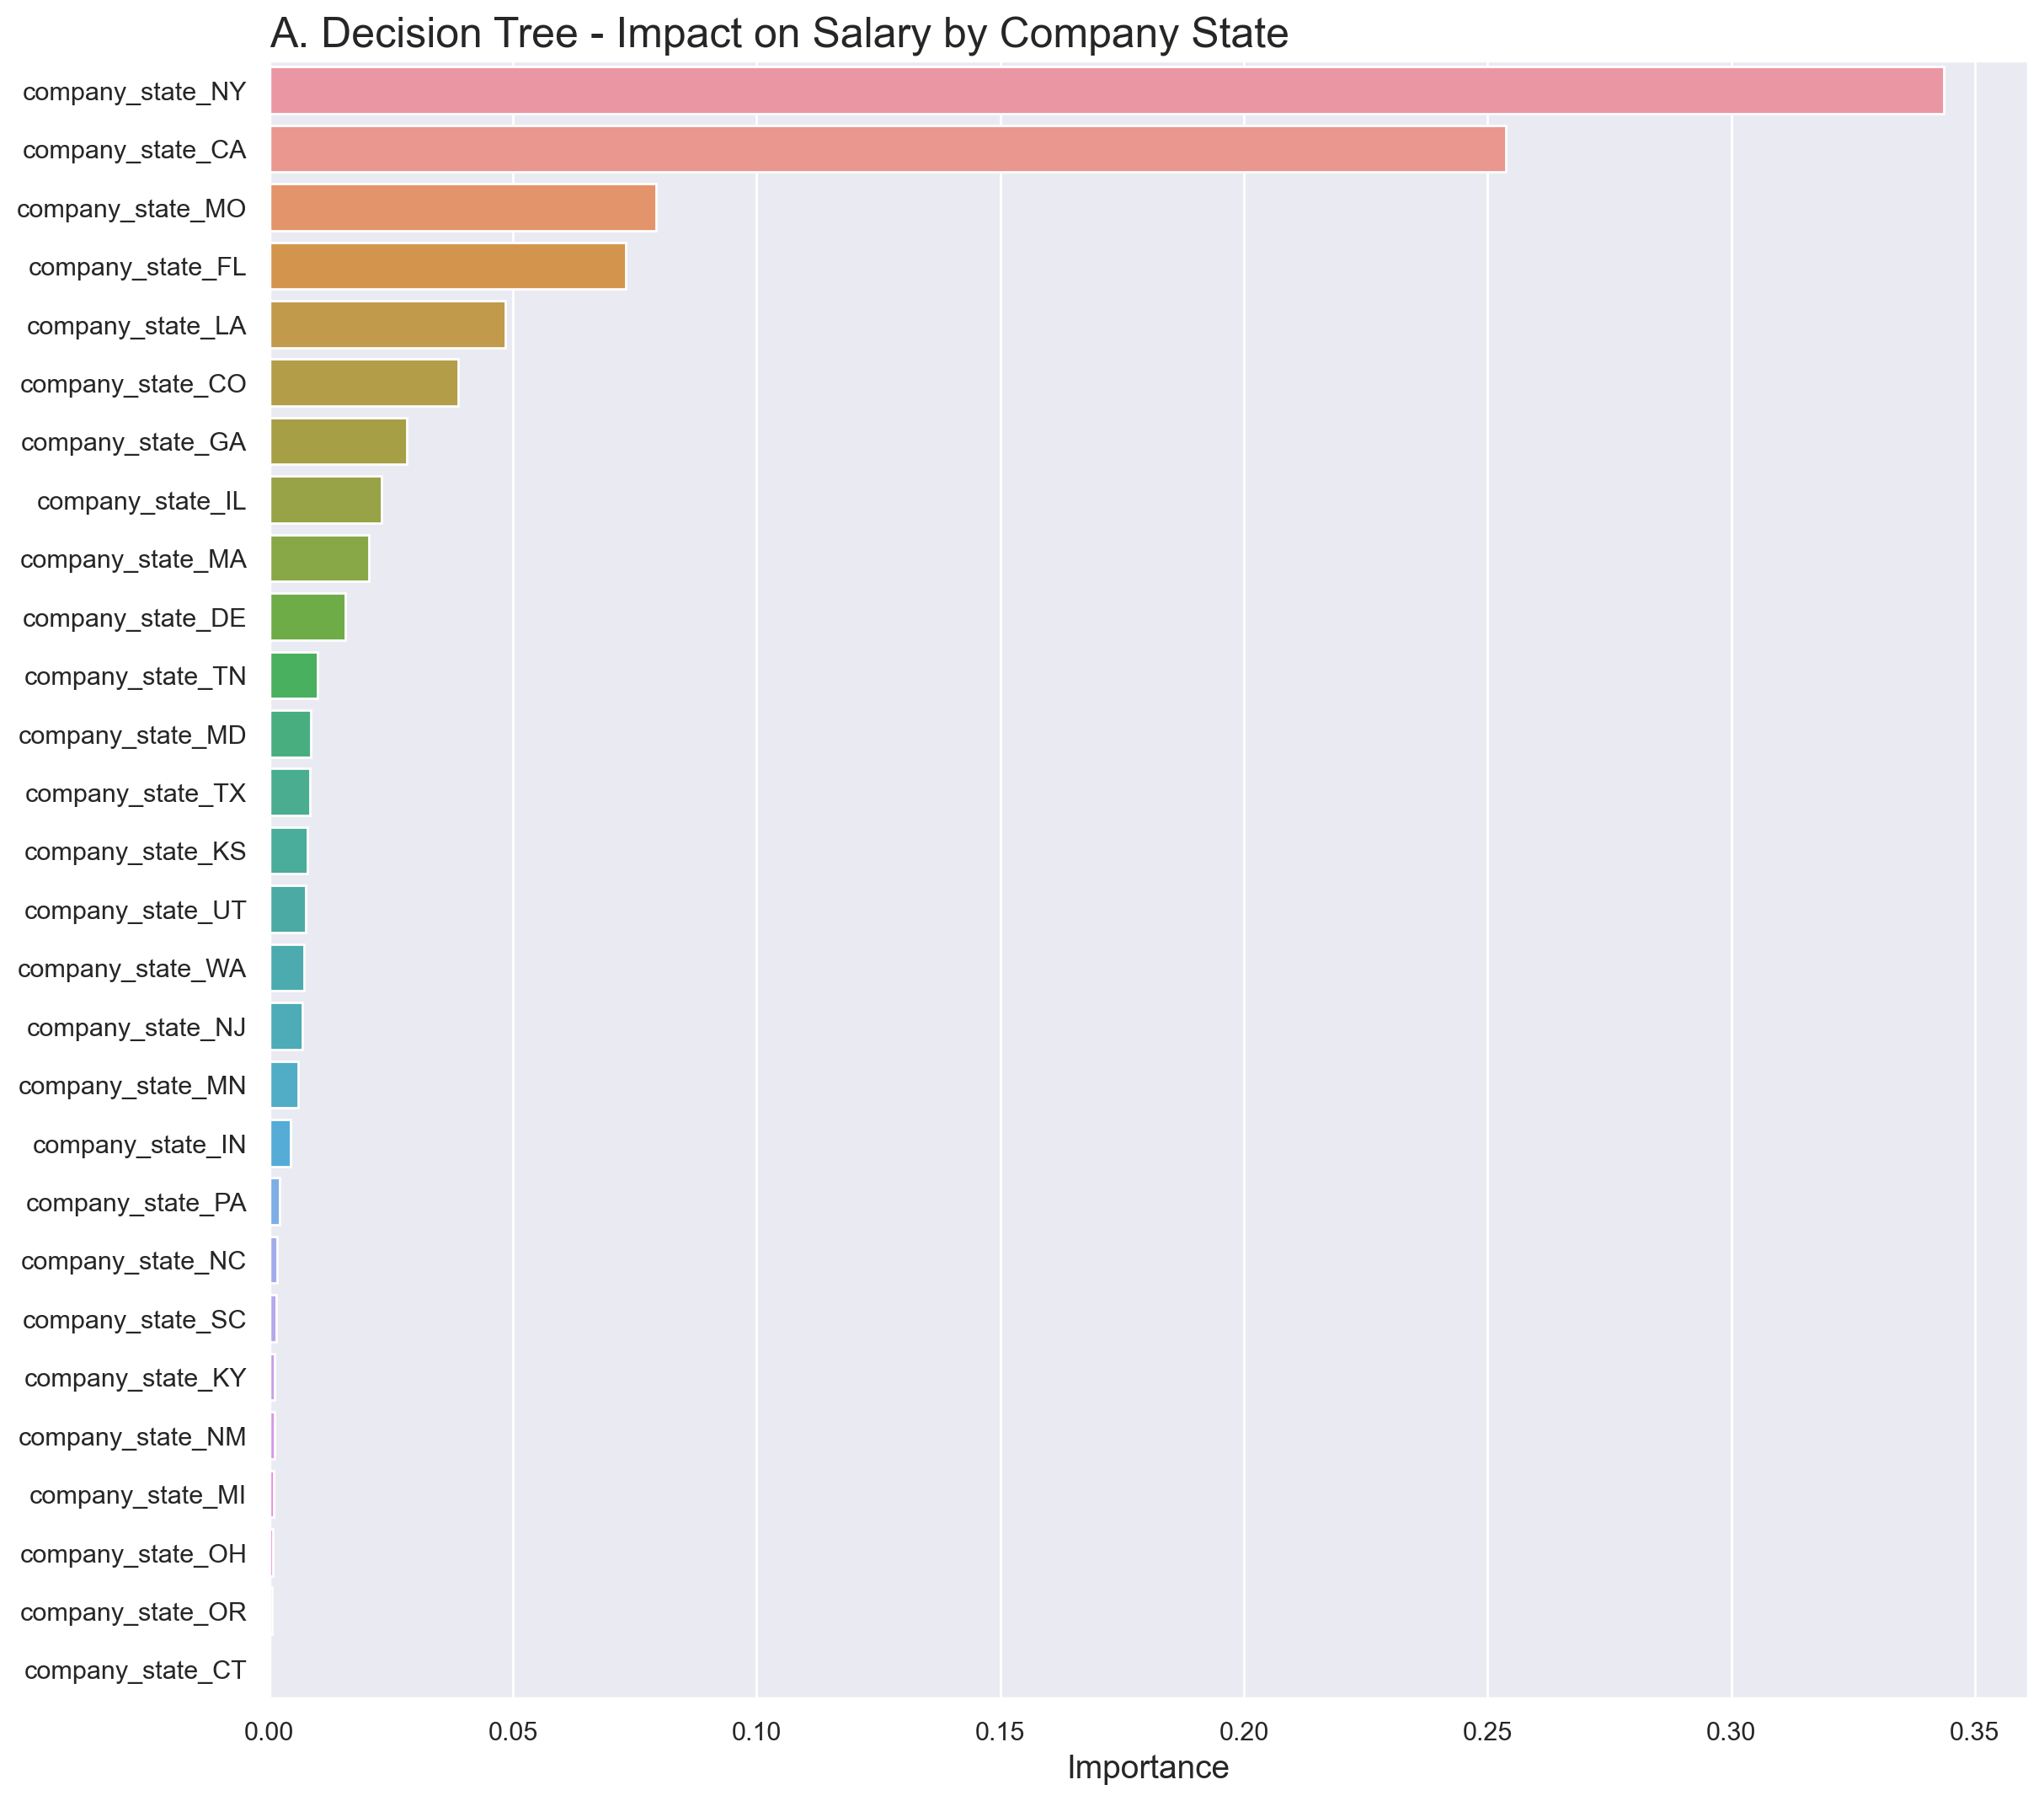

In [22]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=dt_coef.importance.values, y=dt_coef.importance.index,
            order=dt_coef.sort_values('importance', ascending=False).index, ax=ax)
ax.set_title('A. Decision Tree - Impact on Salary by Company State', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show()

Feature importance in Decision Tree is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this model, the states of **New York**, **California** and **Missouri** have the highest values, indicating that these locations have the largest impact on salaries.  
On the other side, **Connecticut**, **Oregon** and **Ohio** have the smallest impact on salaries.
<br/><br/>

Classification Report

In [23]:
predictions = dt_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.55      0.56      0.56      1320
           1       0.56      0.55      0.56      1352

    accuracy                           0.56      2672
   macro avg       0.56      0.56      0.56      2672
weighted avg       0.56      0.56      0.56      2672



Confusion Matrix

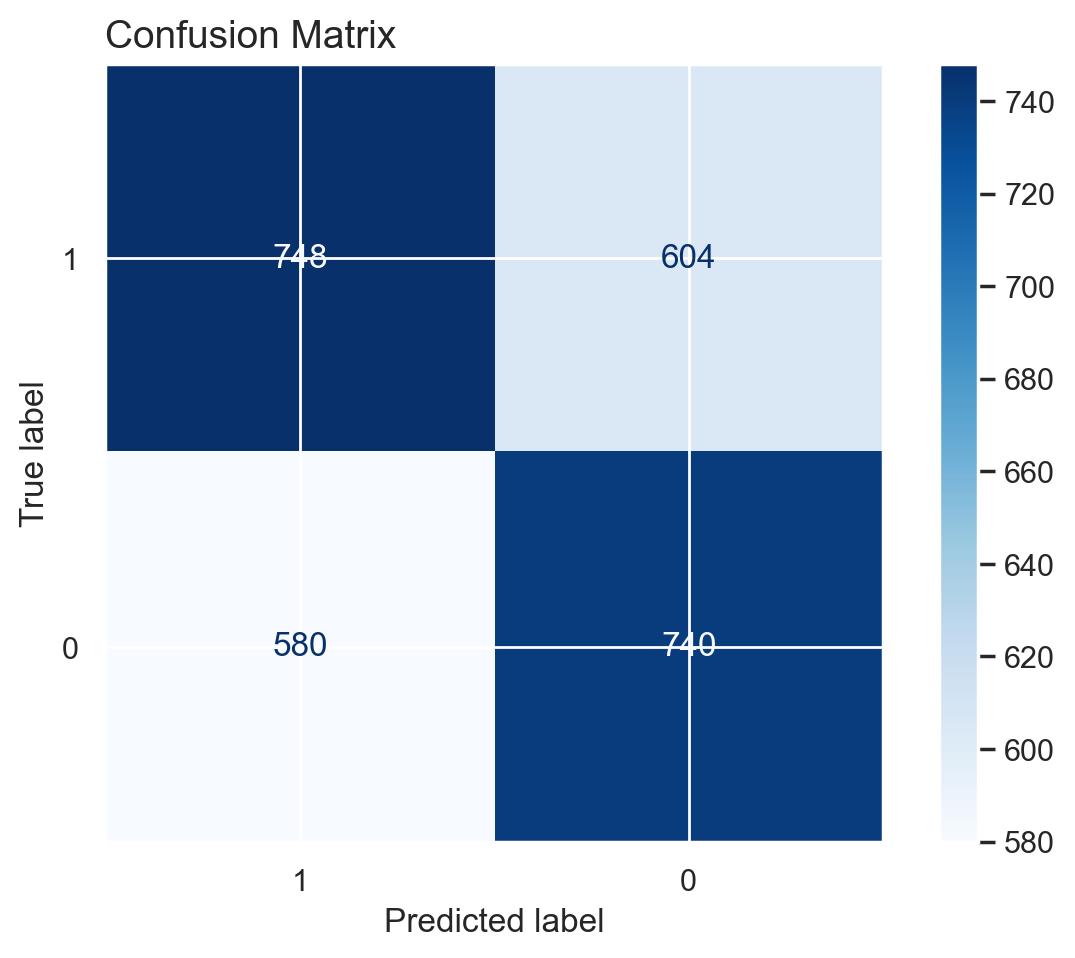

In [24]:
plot_confusion_matrix(dt_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

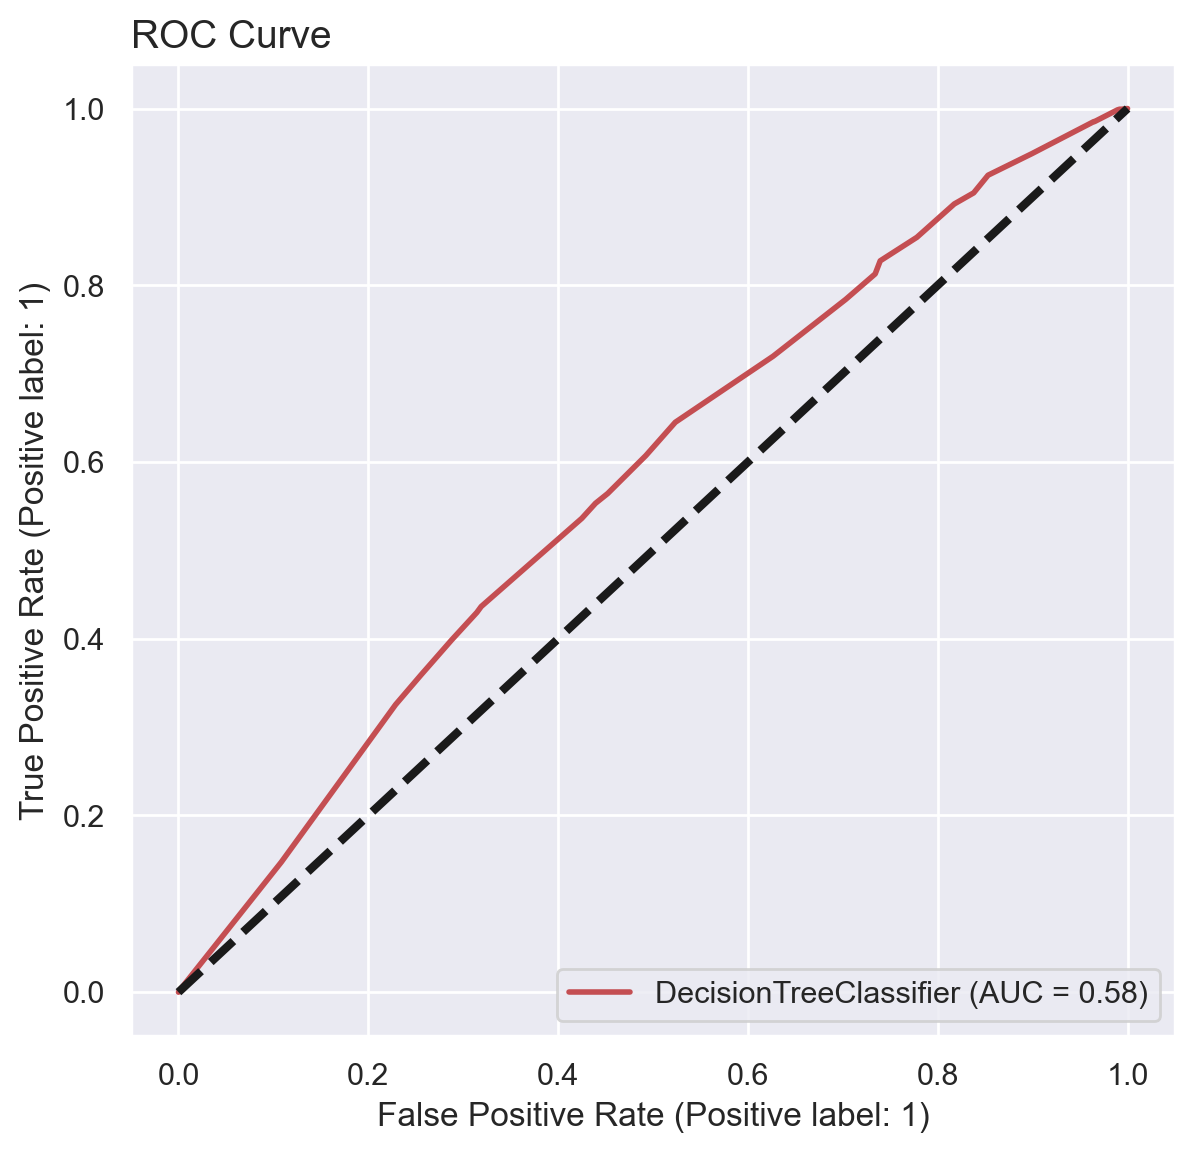

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(dt_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [26]:
print('ROC-AUC Score:', roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.5781916801147571


Precision-Recall Curve

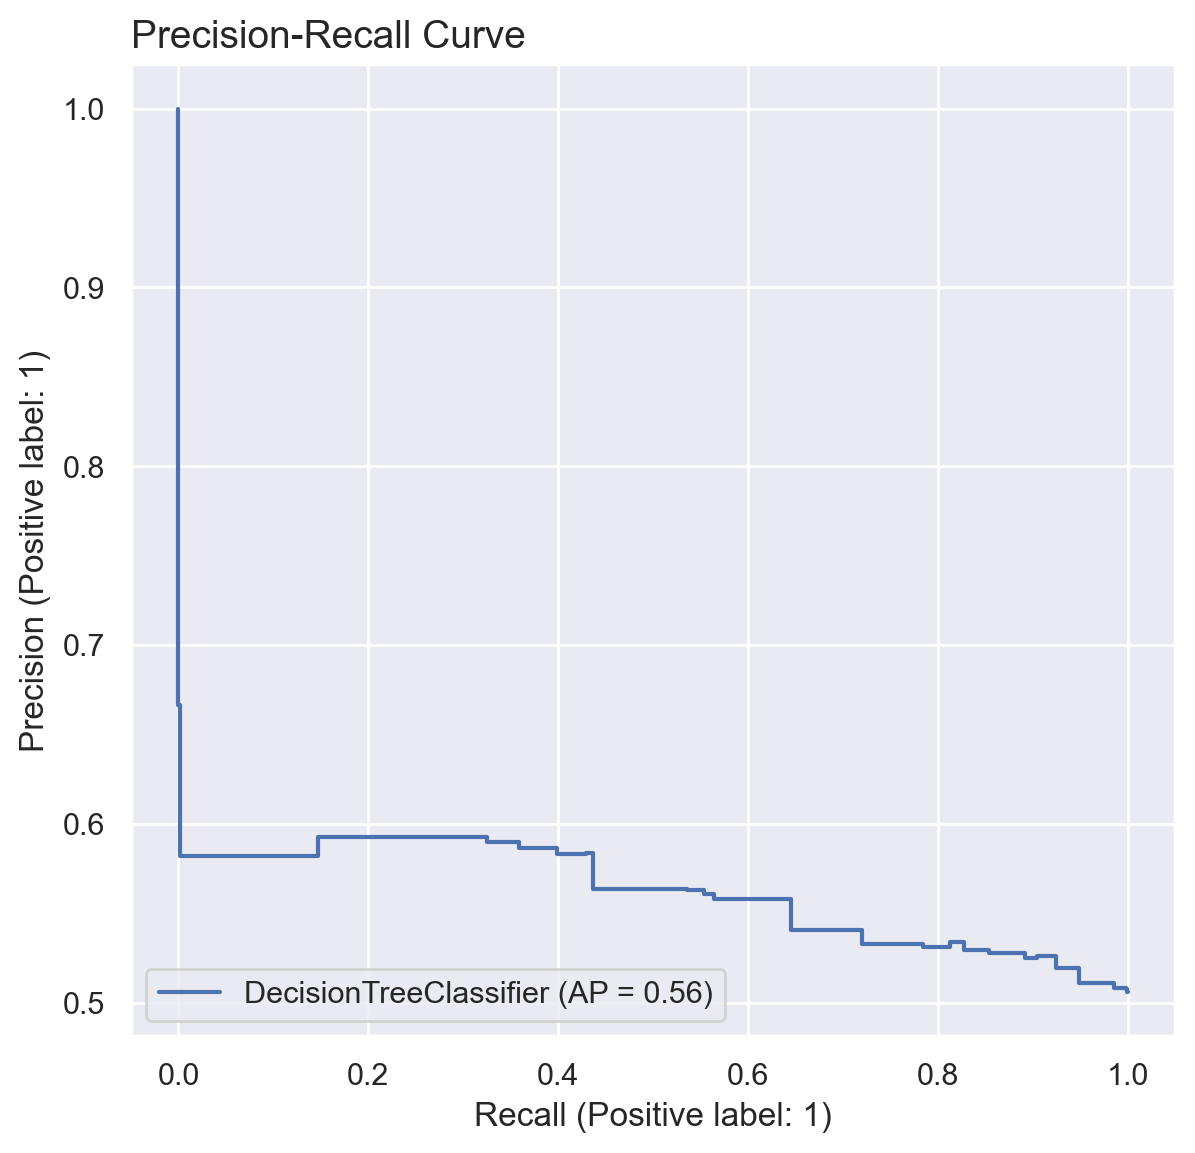

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(dt_best, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, however the accuracy of the model is quite low.  
The area under the curve is **0.58**, which tells us that this model has a bad class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.56**, the curve descends in a typical non-monotonic fashion, and the precision starts very low at **0.58**.  

<br/><br/>

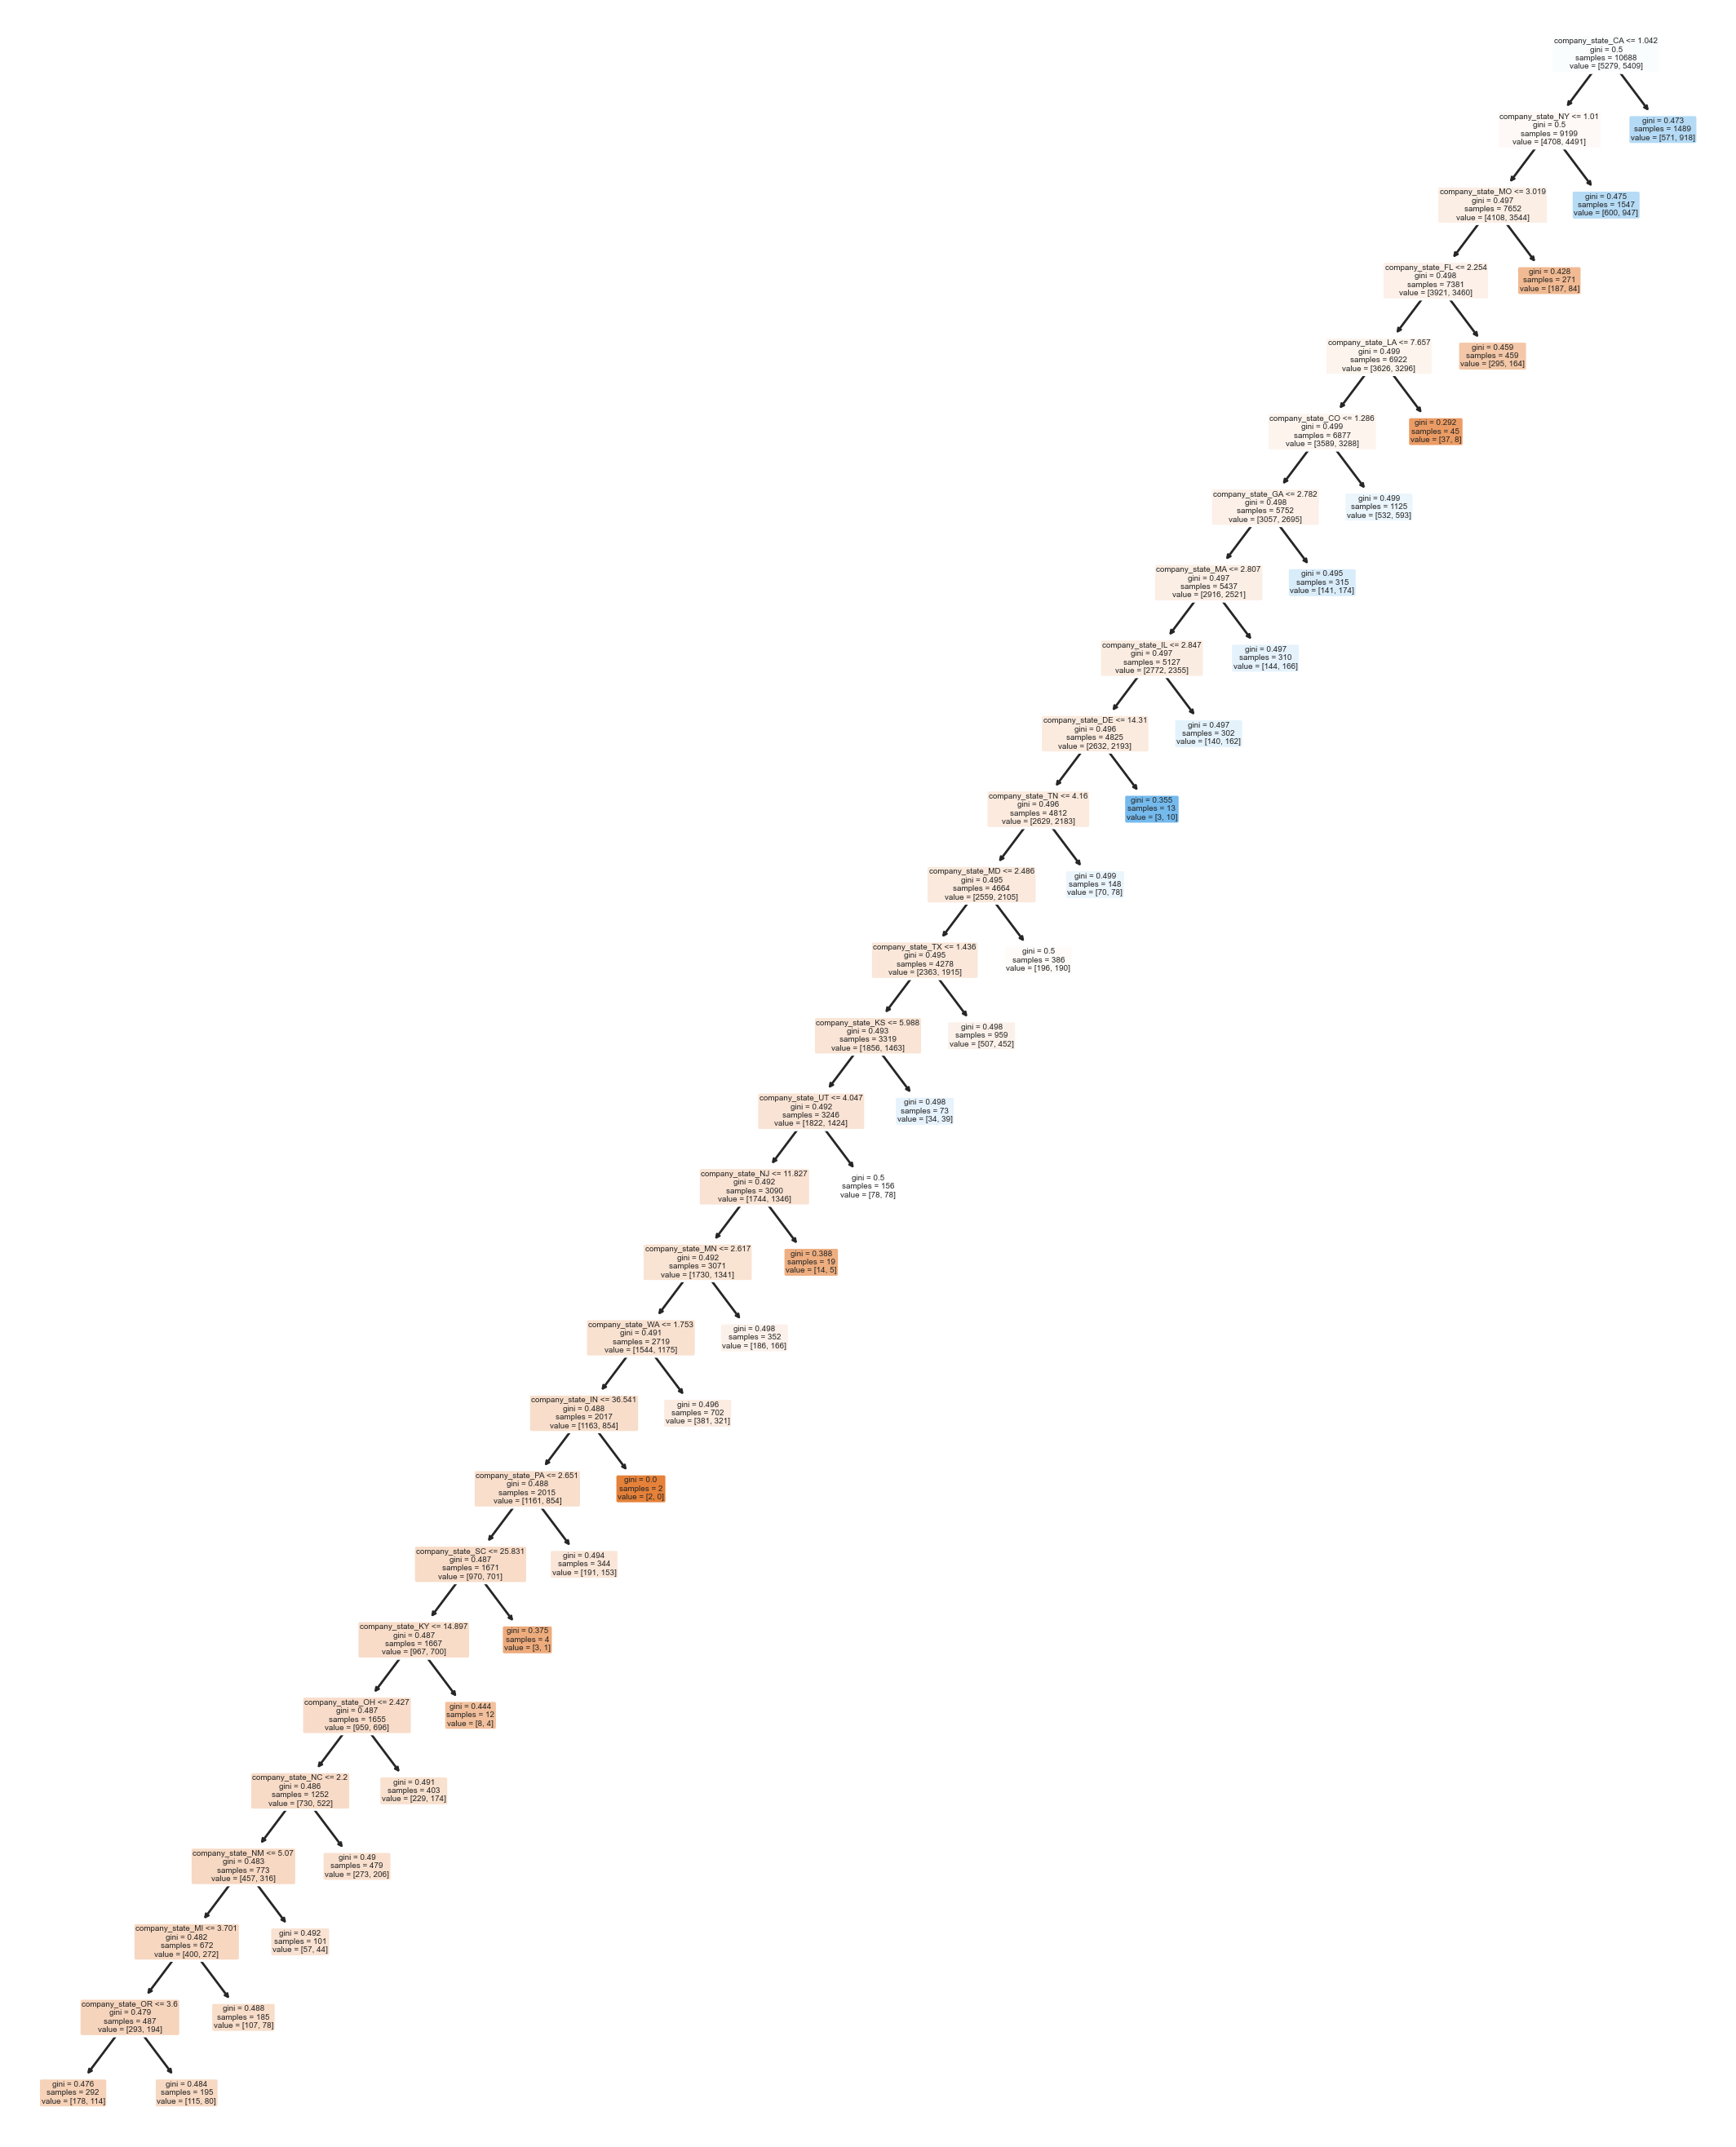

In [28]:
# Showing the Decision Tree using sklearn
plt.figure(figsize=(12,16))
tree.plot_tree(dt_best,
               max_depth=None,
               feature_names=X_train.columns,
               class_names=None,
               label='all',
               filled=True,
               impurity=True,
               node_ids=False,
               proportion=False,
               rounded=True,
               precision=3,
               ax=None,
               fontsize=None)

plt.show()

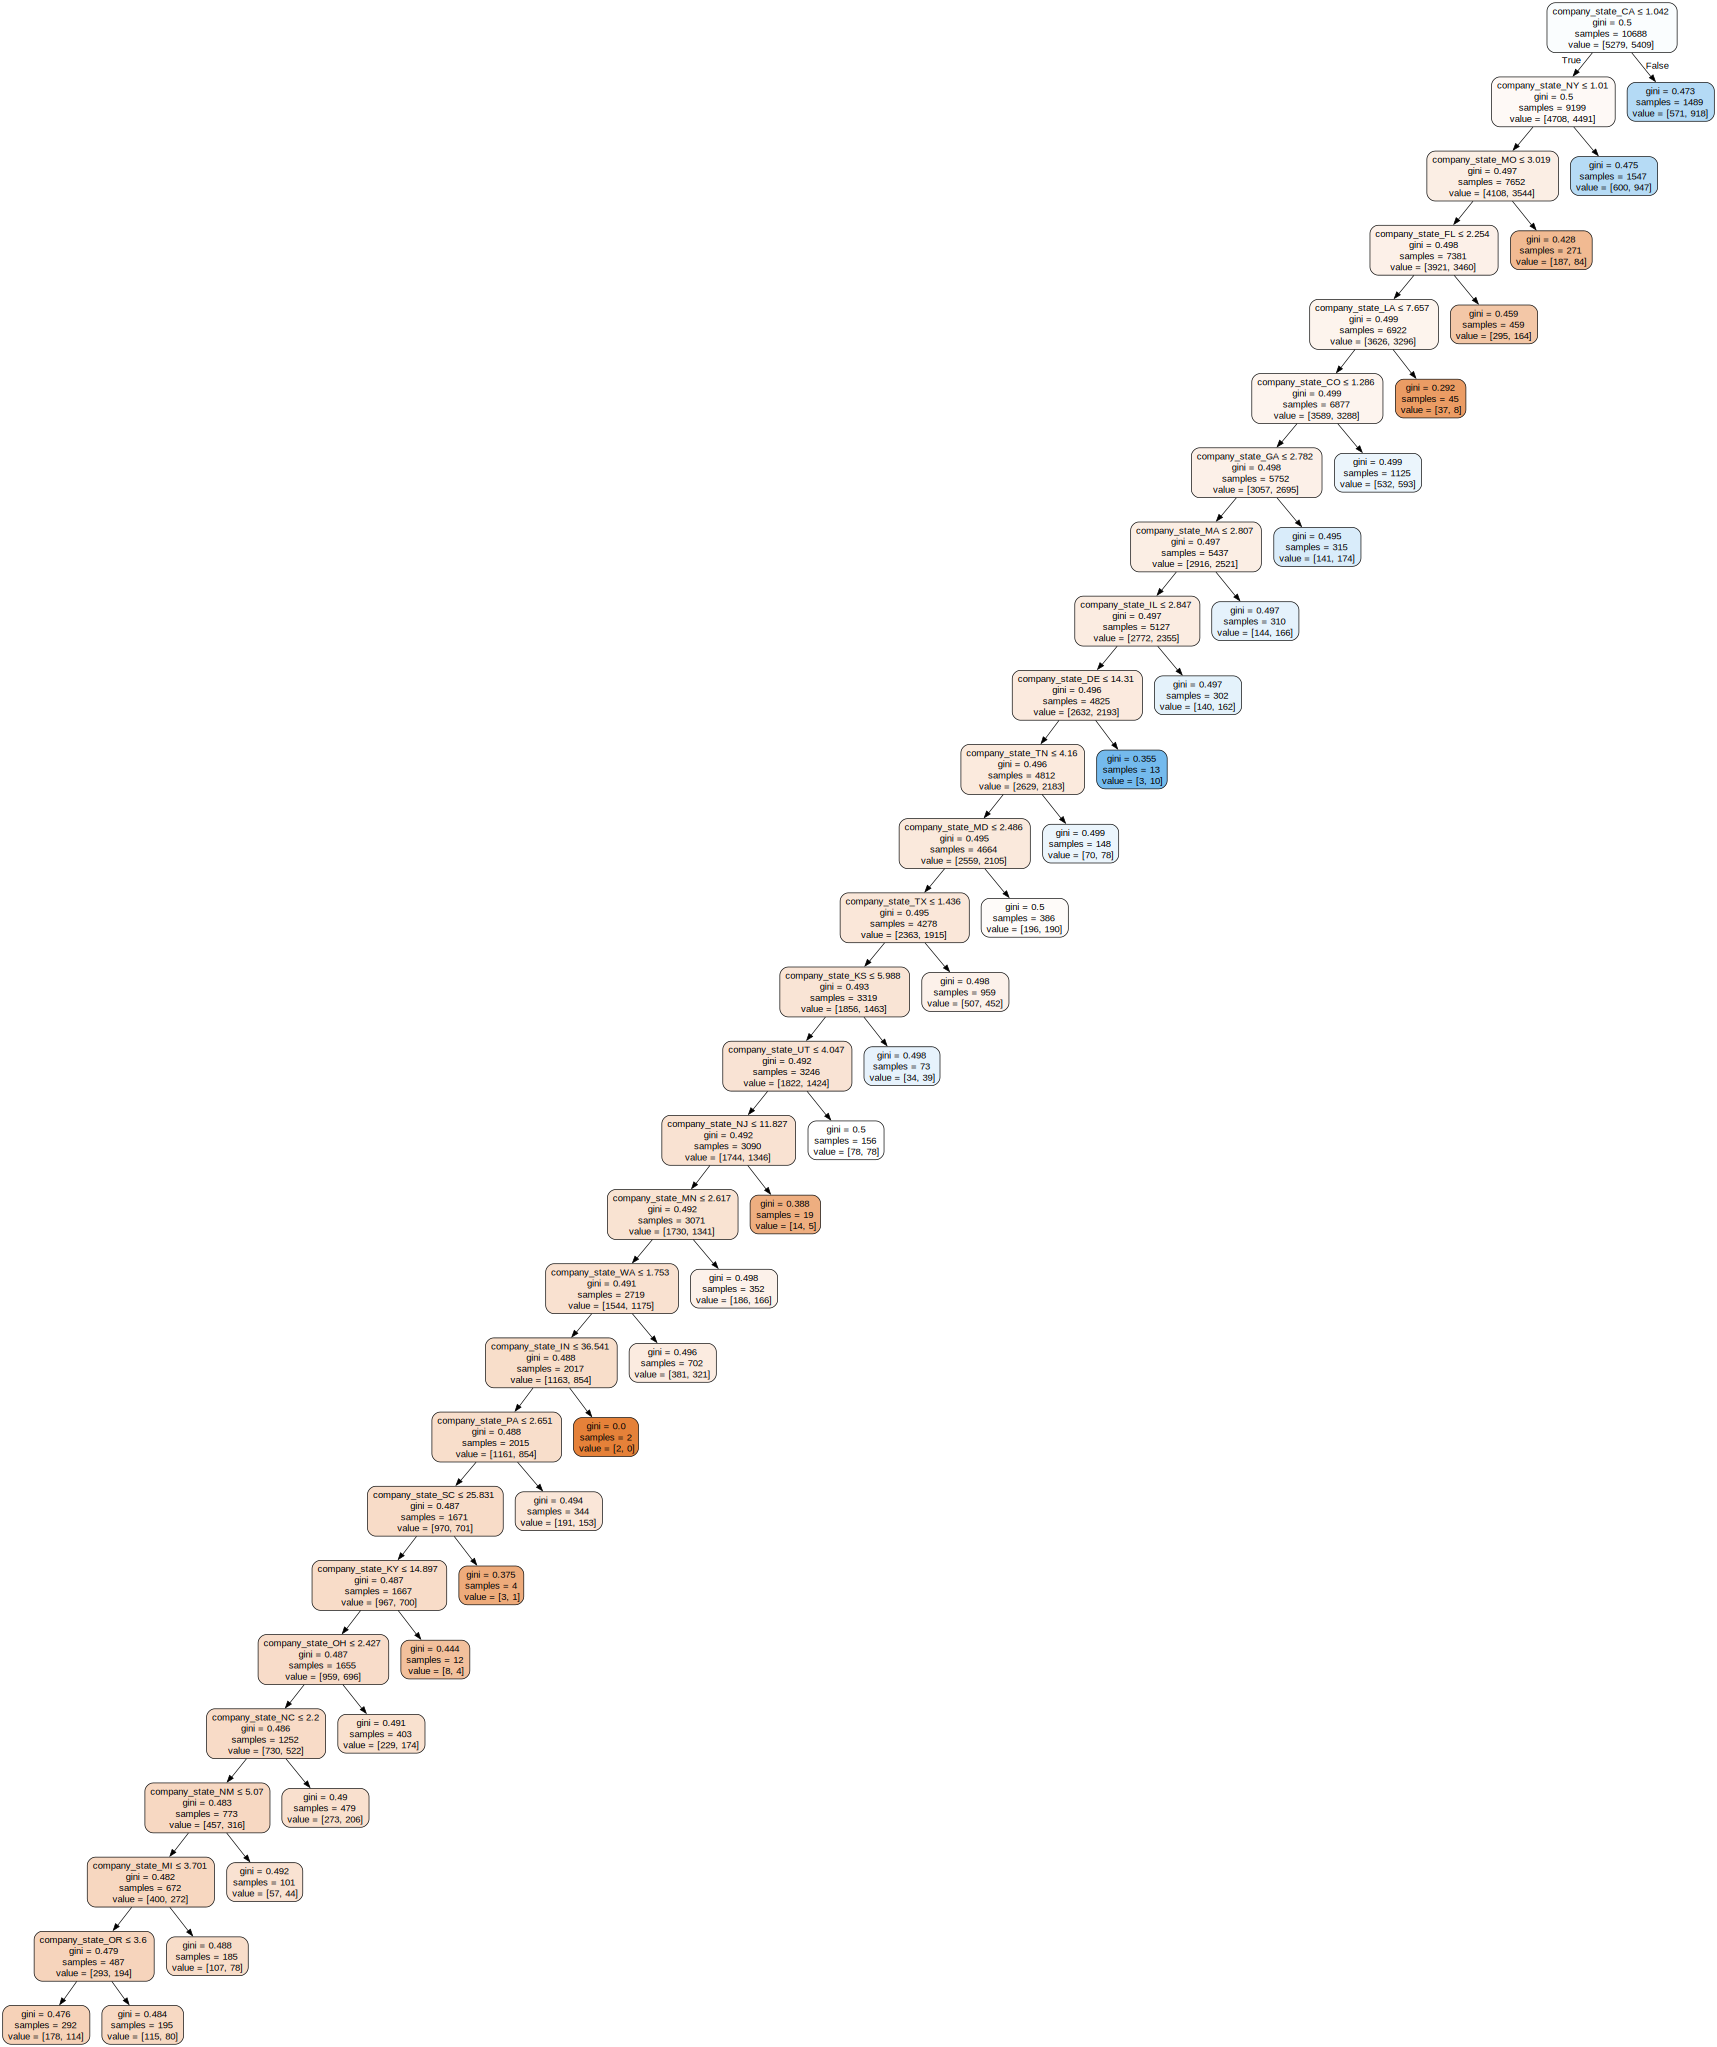

In [29]:
# Showing the Decision Tree using graphviz
dot_data = export_graphviz(dt_best,
                           out_file=None,
                           max_depth=None,
                           feature_names=X_train.columns,
                           class_names=None,
                           label='all',
                           filled=True,
                           leaves_parallel=False,
                           impurity=True,
                           node_ids=False,
                           proportion=False,
                           rotate=False,
                           rounded=True,
                           special_characters=True,
                           precision=3,
                           fontname='helvetica')

graph = graphviz.Source(dot_data) 

graph

The decision tree has a very simple shape as it has only one main branch and all the leaves come from it. This is likely due to using only one feature as a predictor.  
The nodes show varied levels of purity, however for most of them is pretty low.  



In [30]:
# Description to be improved










#### Random Forest with GridSearchCV

In [31]:
# Defining gridsearch parameters
randf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 5, 7]}

# Defining the model
randf = RandomForestClassifier(random_state = 1)

# Instantiating the gridsearch
rfc_gs = GridSearchCV(randf, randf_params, cv=5, n_jobs=10, verbose=1)

# Fitting the gridsearch
rfc_gs.fit(X_train, y_train)

# Extracting the model with the best parameters found in the gridsearch
rf_best = rfc_gs.best_estimator_

# Calculating the scores
a_rf_train = rf_best.score(X_train, y_train)
a_rf_test = rf_best.score(X_test, y_test)
a_rf_cv = (cross_val_score(rf_best, X_train, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
a_rf_df = pd.DataFrame([a_rf_train, a_rf_test, a_rf_cv],
                       index = ['train', 'test', 'CV'], columns = ['A. Random Forest'])

print('A. Random Forest Classifier Scores: \n')
print('train score: ', a_rf_train)
print('test score: ', a_rf_test)
print('CV score: ', a_rf_cv)

Fitting 5 folds for each of 1650 candidates, totalling 8250 fits
A. Random Forest Classifier Scores: 

train score:  0.5736339820359282
test score:  0.5568862275449101
CV score:  0.5675538586589027


Feature Importance & Model Coefficients 

In [32]:
# Collecting the model coefficients in a dataframe
rf_coef = pd.DataFrame(rf_best.feature_importances_, columns=['importance'], index=X.columns)
rf_coef.sort_values(by = 'importance', ascending = False)[:10]

importance
company_state_NY    0.229353
company_state_CA    0.217982
company_state_FL    0.119820
company_state_MO    0.118543
company_state_LA    0.065026
company_state_NC    0.047731
company_state_OR    0.034985
company_state_WA    0.032074
company_state_OH    0.026491
company_state_NJ    0.015262

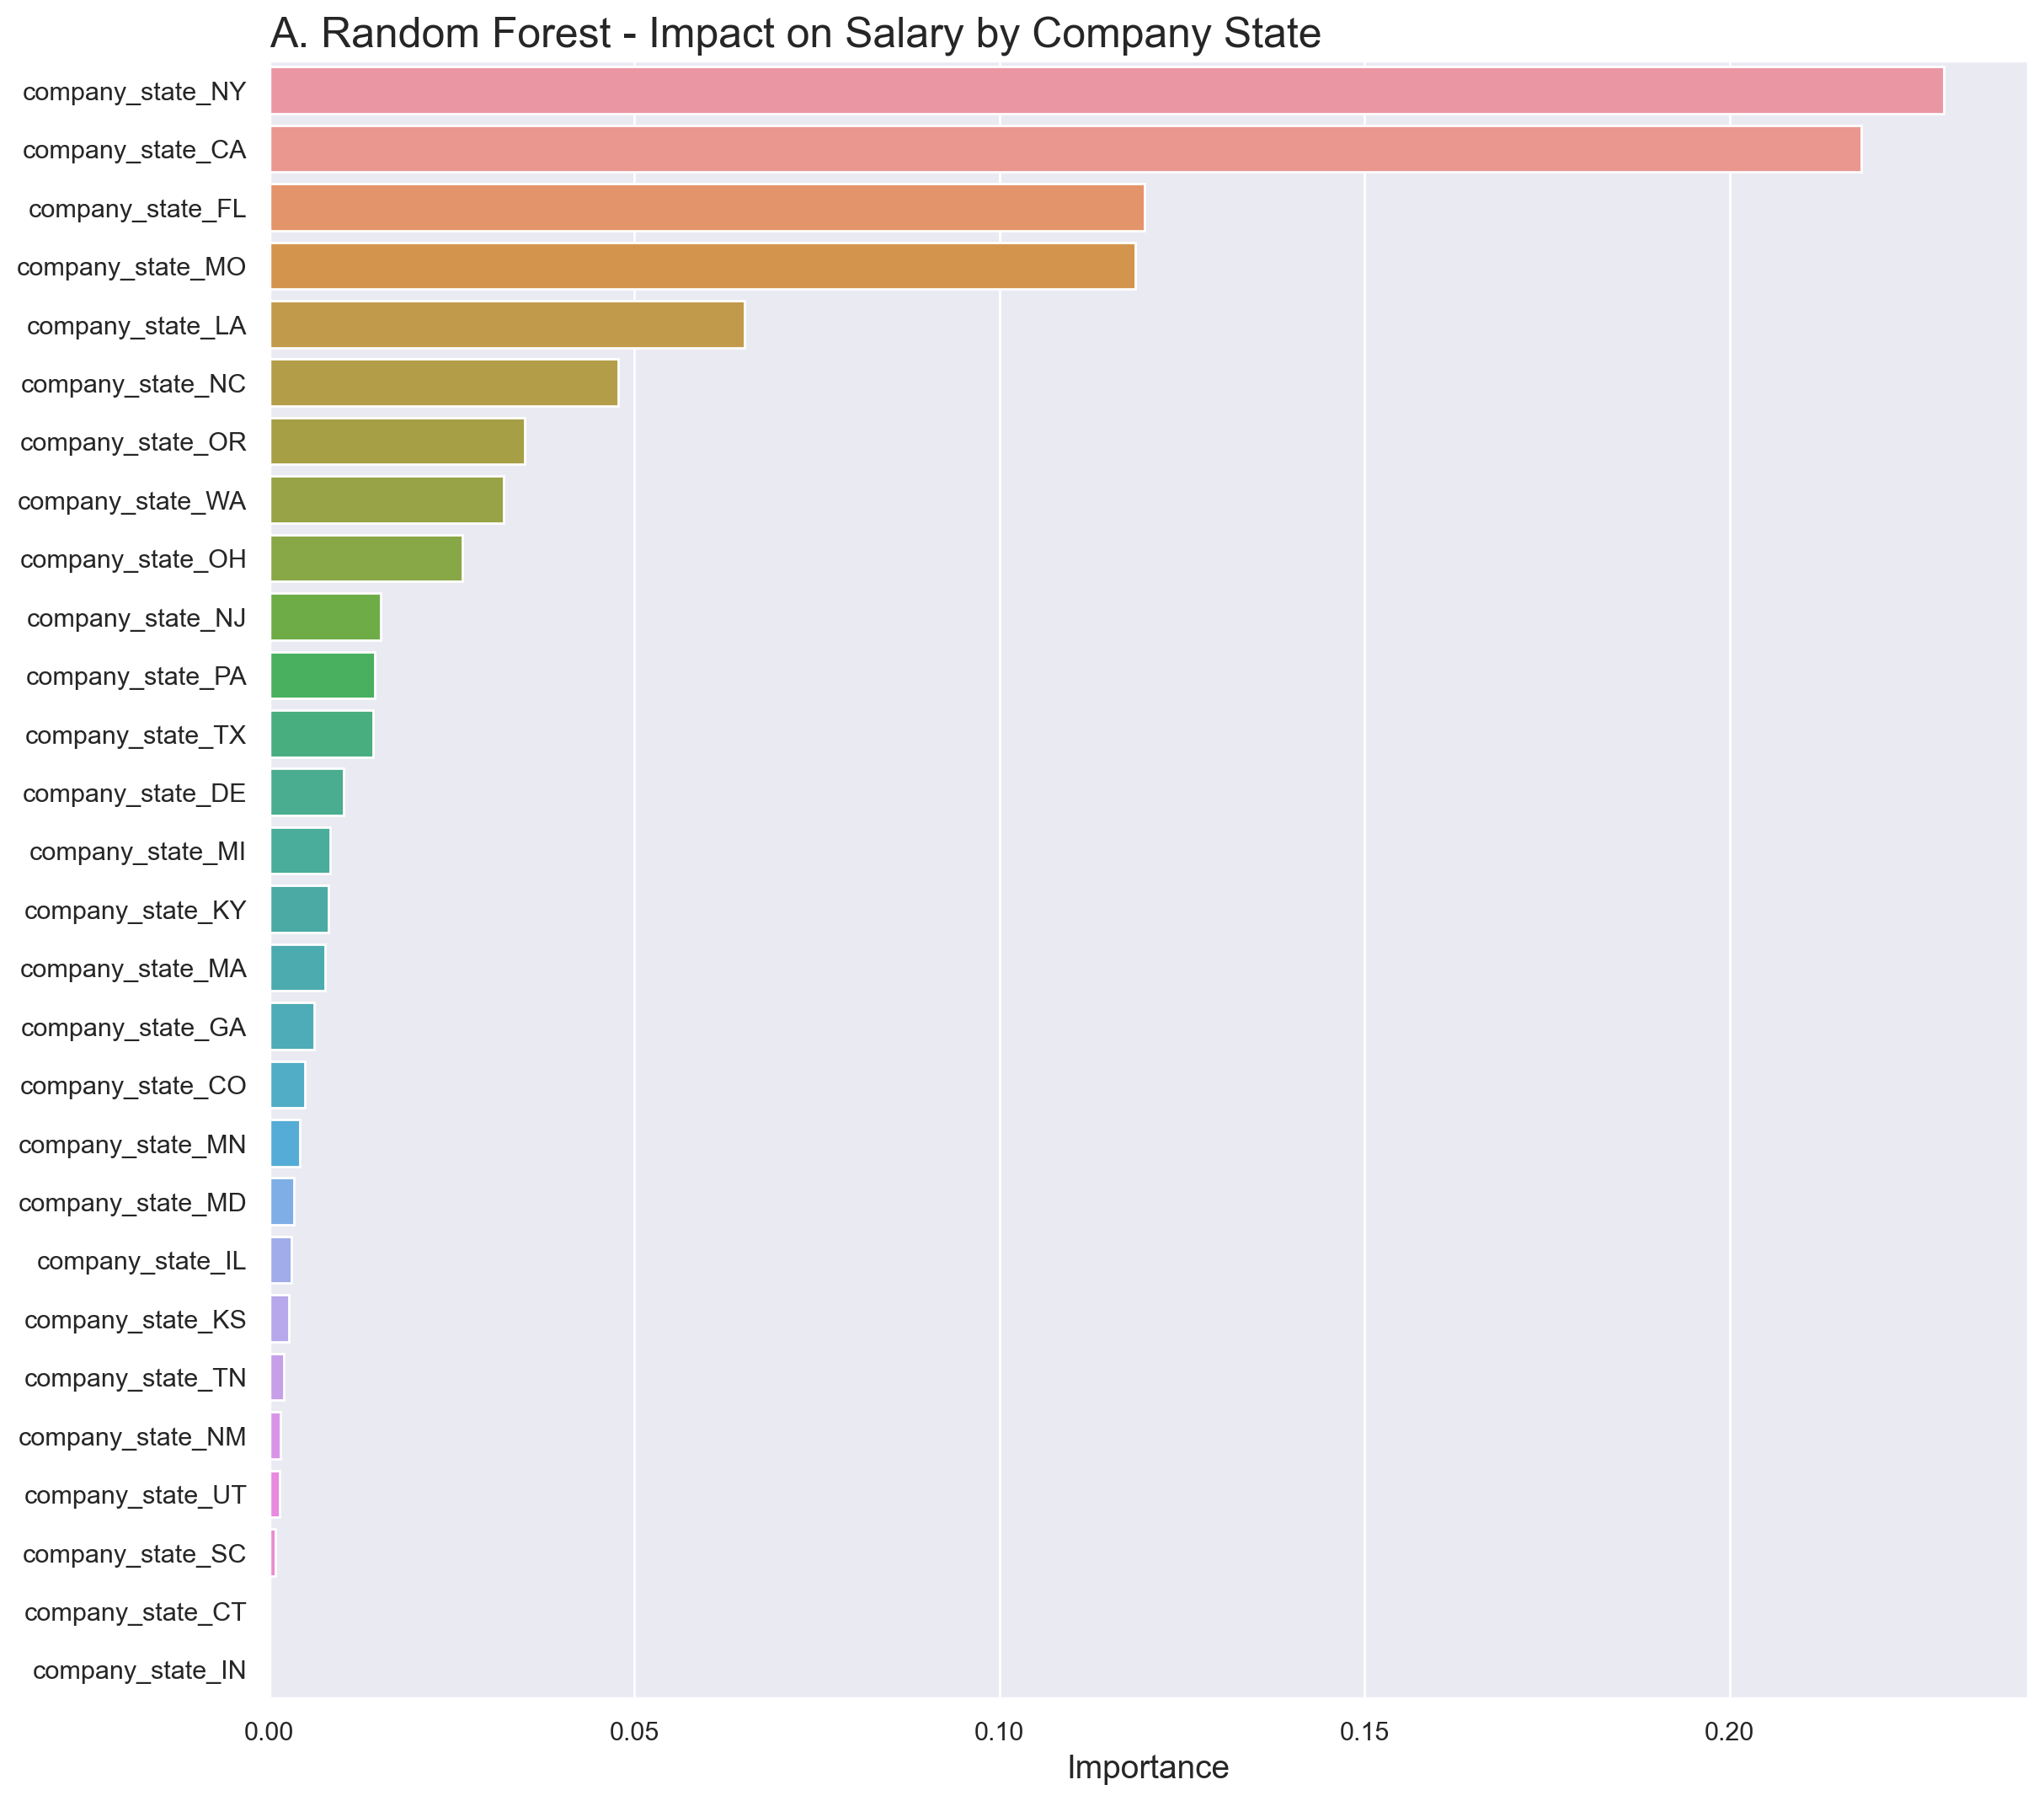

In [33]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=rf_coef.importance.values, y=rf_coef.importance.index,
            order=rf_coef.sort_values('importance', ascending=False).index, ax=ax)
ax.set_title('A. Random Forest - Impact on Salary by Company State', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show()

Feature importance in Random Forest is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this model, the states of **New York**, **California** and **Florida** have the highest values, indicating that these locations have the largest impact on salaries.  
On the other side, **Indiana**, **Connecticut** and **South Carolina** have the smallest impact on salaries.
<br/><br/>

Classification Report

In [34]:
predictions = rf_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.55      0.56      0.56      1320
           1       0.56      0.55      0.56      1352

    accuracy                           0.56      2672
   macro avg       0.56      0.56      0.56      2672
weighted avg       0.56      0.56      0.56      2672



Confusion Matrix

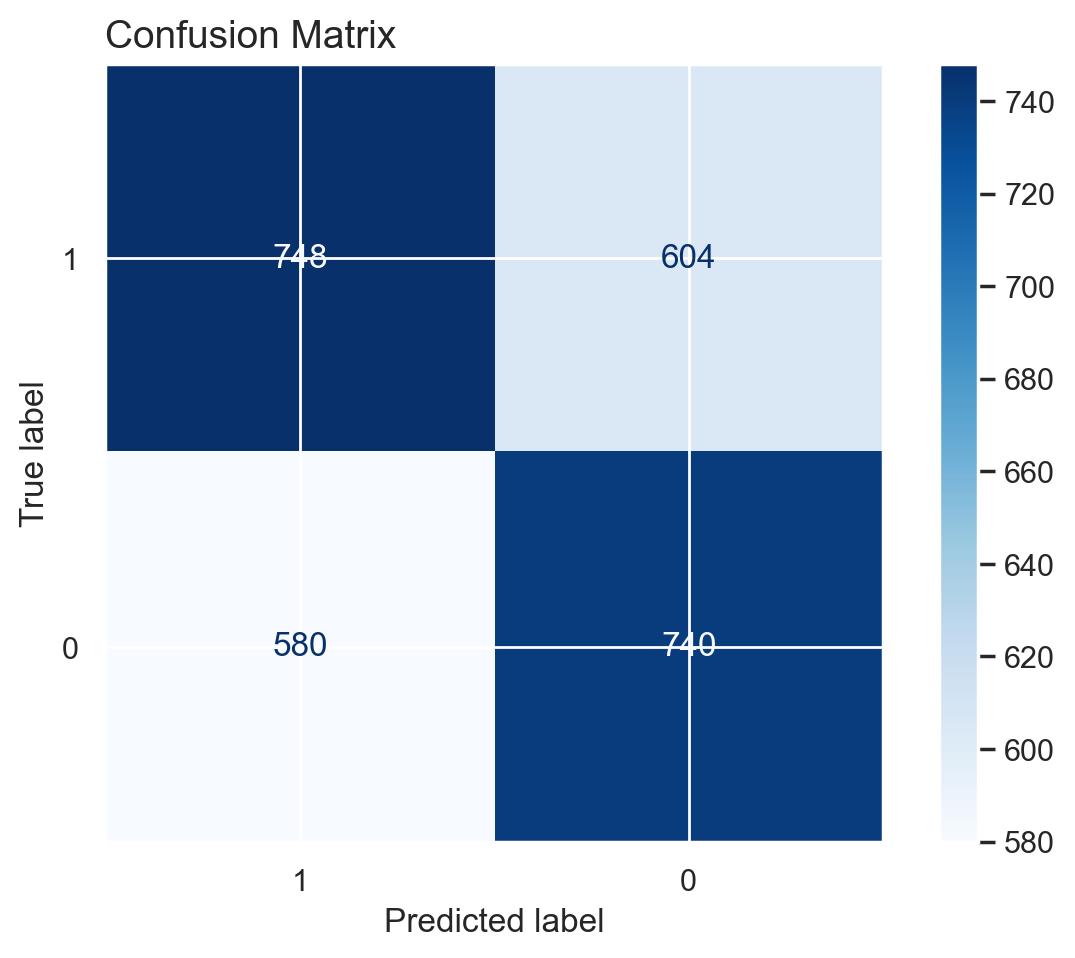

In [35]:
plot_confusion_matrix(rf_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

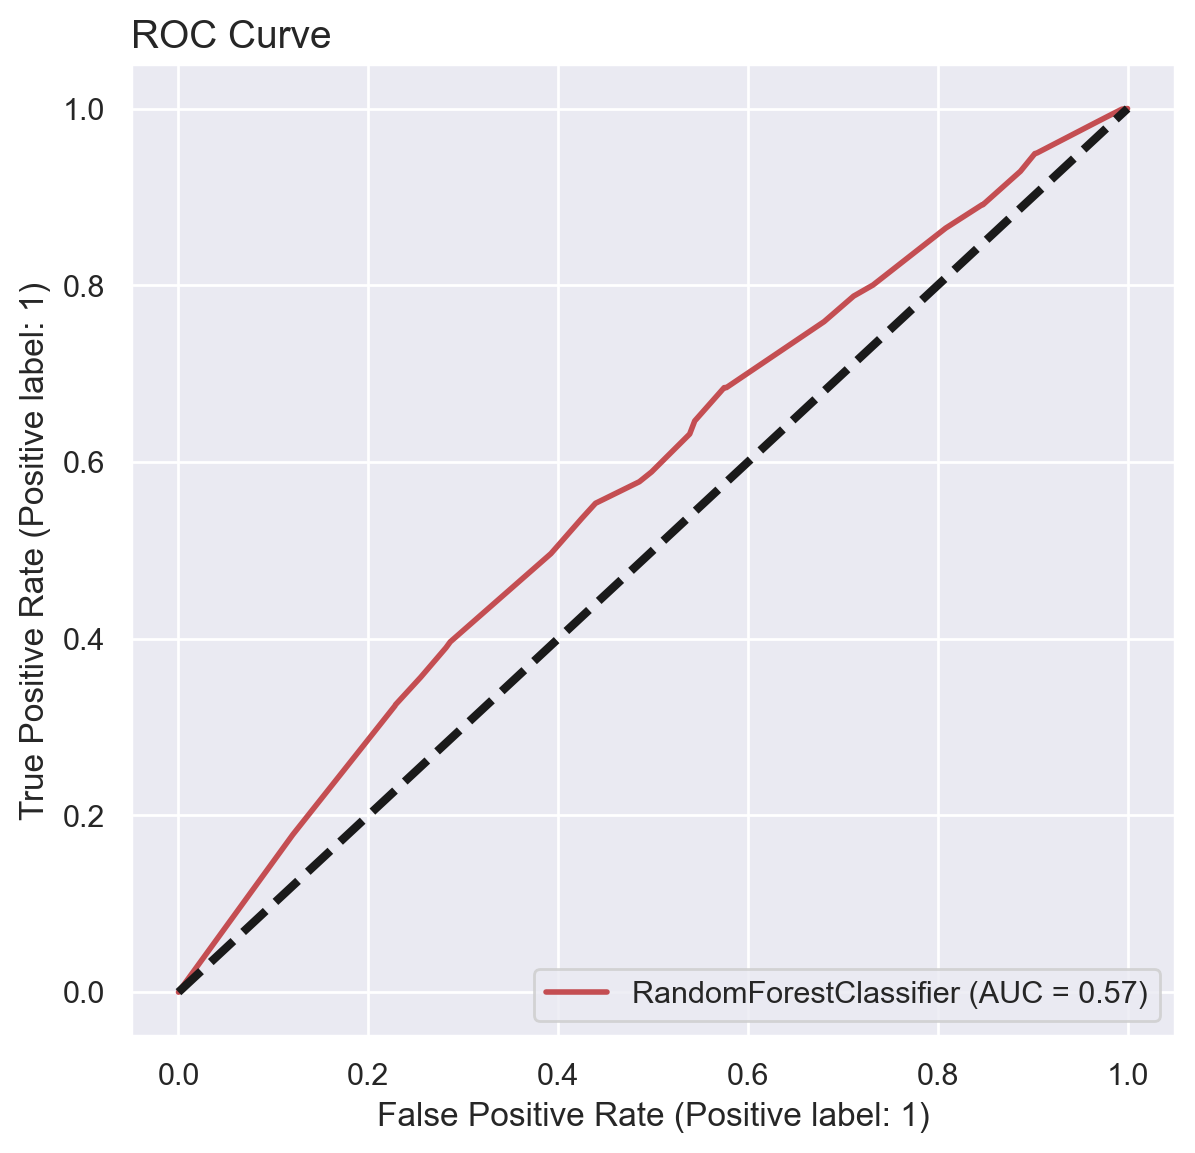

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(rf_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [37]:
print('ROC-AUC Score:', roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.5727777030661646


Precision-Recall Curve

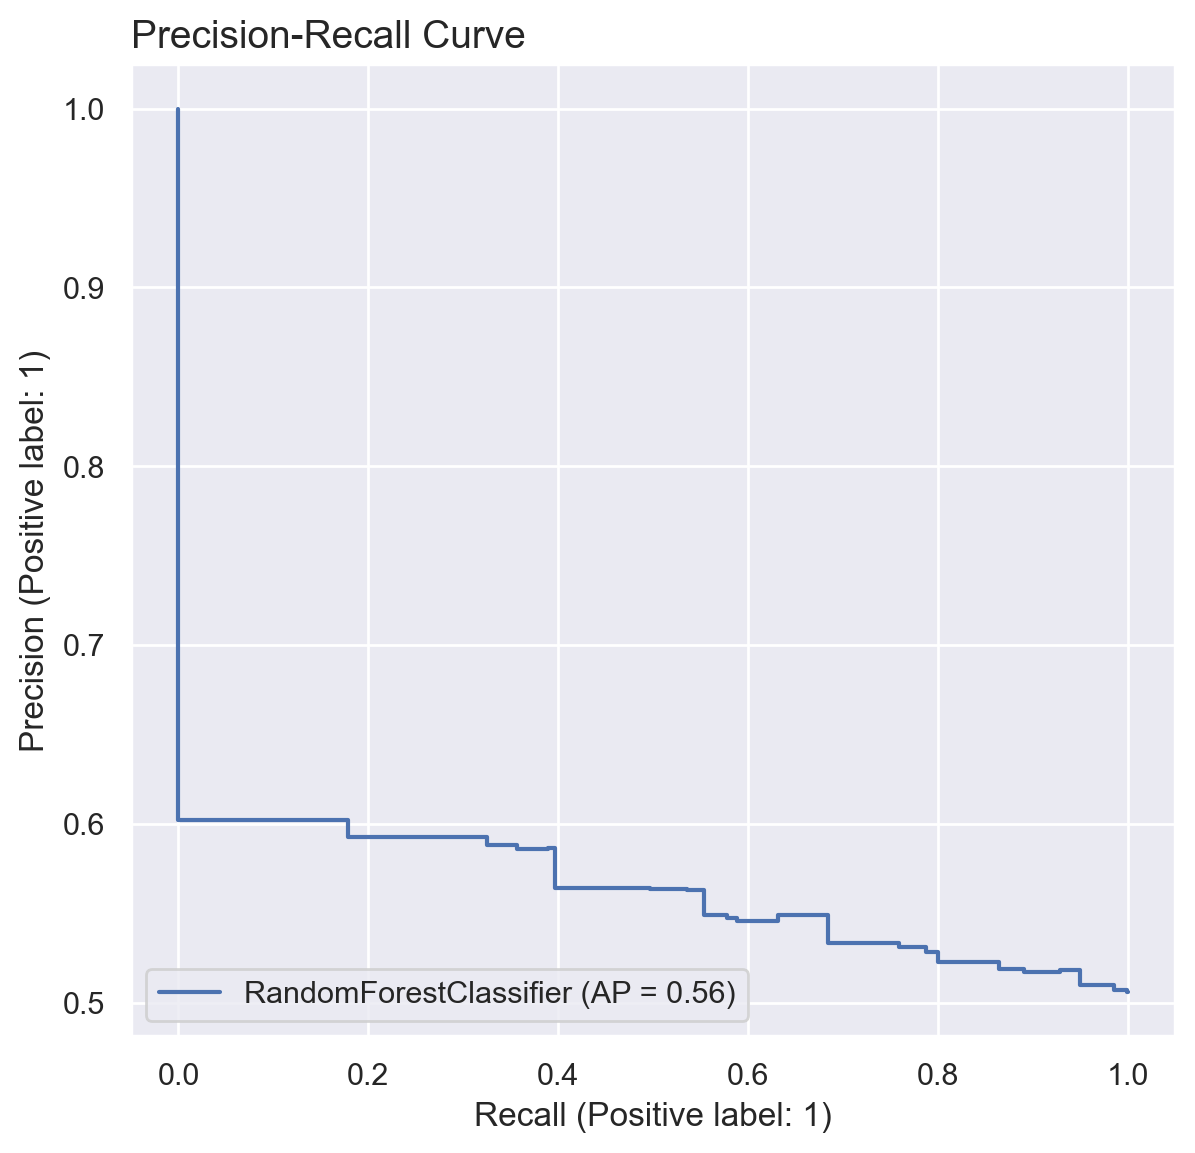

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(rf_best, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, however the accuracy of the model is pretty low.  
The area under the curve is **0.57**, which tells us that this model has a bad class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.56**, the curve descends in a typical non-monotonic fashion, and the precision starts very low at **0.60**.  

<br/><br/>

#### Model Scores Evaluation

In [39]:
A_models = pd.concat([a_logreg_df, a_dt_df, a_rf_df], axis = 1)
A_models

A. Logistic Reg  A. Decision Tree  A. Random Forest
train         0.573634          0.573634          0.573634
test          0.556886          0.556886          0.556886
CV            0.569329          0.569329          0.567554

In the three models implemented above, both **Logistic Regression** and **Decision Tree** achieved the highest CV score of **0.5693** (showing the same value up to the 15th digit!). 

Interestingly, the most important features for the first model were **California**, **New York** and **Colorado** (in this order), while for the second model they were **New York**, **California** and **Missouri**: these locations have the biggest impact in predicting job salaries.

Although Logistic Regression and Decision Tree performed the best, all the three model scores were quite close to one another, and were about 0.06 higher than the baseline of 0.5 indicating that the models made better predictions. However, it is likely that by adding other features these scores can improve.  
<br/><br/>

### *B. Using additional features created "manually" from the Job Title*

We are creating new variables in the dataframe, implementing functions that collect interesting features from the job title.  
Using more features should help improve the accuracy of the model.  

<br/><br/>

In [40]:
# Functions to create additional features from the job title

# Senior
def title_senior(row):
    if 'Senior' in row['job_title']:
        return 1
    elif 'senior' in row['job_title']:
        return 1
    elif 'Sr.' in row['job_title']:
        return 1
    elif 'sr.' in row['job_title']:
        return 1
    else:
        return 0

# Junior
def title_junior(row):
    if 'Junior' in row['job_title']:
        return 1
    elif 'junior' in row['job_title']:
        return 1
    elif 'Jr.' in row['job_title']:
        return 1
    elif 'jr.' in row['job_title']:
        return 1
    else:
        return 0

# Manager
def title_manager(row):
    if 'Manager' in row['job_title']:
        return 1
    elif 'manager' in row['job_title']:
        return 1
    else:
        return 0
    
# Principal
def title_principal(row):
    if 'Principal' in row['job_title']:
        return 1
    elif 'principal' in row['job_title']:
        return 1
    else:
        return 0

# Director
def title_director(row):
    if 'Director' in row['job_title']:
        return 1
    elif 'director' in row['job_title']:
        return 1
    else:
        return 0

# Lead
def title_lead(row):
    if 'Lead' in row['job_title']:
        return 1
    elif 'lead' in row['job_title']:
        return 1
    elif 'Leader' in row['job_title']:
        return 1
    elif 'leader' in row['job_title']:
        return 1
    else:
        return 0

# Associate
def title_associate(row):
    if 'Associate' in row['job_title']:
        return 1
    elif 'associate' in row['job_title']:
        return 1
    else:
        return 0

# Engineer
def title_engineer(row):
    if 'Engineer' in row['job_title']:
        return 1
    elif 'engineer' in row['job_title']:
        return 1
    else:
        return 0

# Scientist
def title_scientist(row):
    if 'Scientist' in row['job_title']:
        return 1
    elif 'scientist' in row['job_title']:
        return 1
    else:
        return 0
    
# Specialist
def title_specialist(row):
    if 'Specialist' in row['job_title']:
        return 1
    elif 'specialist' in row['job_title']:
        return 1
    else:
        return 0
    
# Researcher
def title_researcher(row):
    if 'Researcher' in row['job_title']:
        return 1
    elif 'researcher' in row['job_title']:
        return 1
    else:
        return 0

# Consultant
def title_consultant(row):
    if 'Consultant' in row['job_title']:
        return 1
    elif 'consultant' in row['job_title']:
        return 1
    else:
        return 0

# Analyst
def title_analyst(row):
    if 'Analyst' in row['job_title']:
        return 1
    elif 'analyst' in row['job_title']:
        return 1
    else:
        return 0    
    
# Architect
def title_architect(row):
    if 'Architect' in row['job_title']:
        return 1
    elif 'architect' in row['job_title']:
        return 1
    else:
        return 0
    
# Postdoc
def title_postdoc(row):
    if 'Postdoc' in row['job_title']:
        return 1
    elif 'postdoc' in row['job_title']:
        return 1
    elif 'Post-doc' in row['job_title']:
        return 1
    elif 'post-doc' in row['job_title']:
        return 1
    elif 'Postdoctoral' in row['job_title']:
        return 1
    elif 'Post Doctoral' in row['job_title']:
        return 1
    else:
        return 0

# Coordinator
def title_coordinator(row):
    if 'Coordinator' in row['job_title']:
        return 1
    elif 'coordinator' in row['job_title']:
        return 1
    elif 'Co-ordinator' in row['job_title']:
        return 1
    elif 'co-ordinator' in row['job_title']:
        return 1
    else:
        return 0
    
# Supervisor
def title_supervisor(row):
    if 'Supervisor' in row['job_title']:
        return 1
    elif 'supervisor' in row['job_title']:
        return 1
    else:
        return 0

# President
def title_president(row):
    if 'President' in row['job_title']:
        return 1
    elif 'president' in row['job_title']:
        return 1
    else:
        return 0
    
# Developer    
def title_developer(row):
    if 'Developer' in row['job_title']:
        return 1
    elif 'developer' in row['job_title']:
        return 1
    else:
        return 0    

# Designer
def title_designer(row):
    if 'Designer' in row['job_title']:
        return 1
    elif 'designer' in row['job_title']:
        return 1
    else:
        return 0
    
# Assistant
def title_assistant(row):
    if 'Assistant' in row['job_title']:
        return 1
    elif 'assistant' in row['job_title']:
        return 1
    else:
        return 0

In [41]:
# Creating the new columns and applying the functions
df['title_senior'] = df.apply(lambda row: title_senior(row), axis=1)
df['title_junior'] = df.apply(lambda row: title_junior(row), axis=1)
df['title_manager'] = df.apply(lambda row: title_manager(row), axis=1)
df['title_principal'] = df.apply(lambda row: title_principal(row), axis=1)
df['title_director'] = df.apply(lambda row: title_director(row), axis=1)
df['title_lead'] = df.apply(lambda row: title_lead(row), axis=1)
df['title_associate'] = df.apply(lambda row: title_associate(row), axis=1)
df['title_engineer'] = df.apply(lambda row: title_engineer(row), axis=1)
df['title_scientist'] = df.apply(lambda row: title_scientist(row), axis=1)
df['title_specialist'] = df.apply(lambda row: title_specialist(row), axis=1)
df['title_researcher'] = df.apply(lambda row: title_researcher(row), axis=1)
df['title_consultant'] = df.apply(lambda row: title_consultant(row), axis=1)
df['title_analyst'] = df.apply(lambda row: title_analyst(row), axis=1)
df['title_architect'] = df.apply(lambda row: title_architect(row), axis=1)
df['title_postdoc'] = df.apply(lambda row: title_postdoc(row), axis=1)
df['title_coordinator'] = df.apply(lambda row: title_coordinator(row), axis=1)
df['title_supervisor'] = df.apply(lambda row: title_supervisor(row), axis=1)
df['title_president'] = df.apply(lambda row: title_president(row), axis=1)
df['title_developer'] = df.apply(lambda row: title_developer(row), axis=1)
df['title_designer'] = df.apply(lambda row: title_designer(row), axis=1)
df['title_assistant'] = df.apply(lambda row: title_assistant(row), axis=1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13360 entries, 0 to 13359
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   job_title          13360 non-null  object 
 1   company_name       13360 non-null  object 
 2   company_rating     13360 non-null  float64
 3   company_location   13360 non-null  object 
 4   company_city       13360 non-null  object 
 5   company_state      13360 non-null  object 
 6   salary_amount      13360 non-null  float64
 7   salary_estimate    13360 non-null  object 
 8   multi_candidate    13360 non-null  object 
 9   multi_location     13360 non-null  int64  
 10  work_arrangement   13360 non-null  object 
 11  job_snippet        13360 non-null  object 
 12  high_salary        13360 non-null  int64  
 13  title_senior       13360 non-null  int64  
 14  title_junior       13360 non-null  int64  
 15  title_manager      13360 non-null  int64  
 16  title_principal    133

In [43]:
# Creating a new predictor matrix with more features
df_dum = pd.get_dummies(df, columns=['company_state', 'work_arrangement'], drop_first=True)
df_dum.drop(columns=['job_title', 'company_name', 'company_rating', 'company_location', 'company_city',
                     'salary_amount', 'salary_estimate', 'multi_candidate', 'multi_location', 'job_snippet',
                     'high_salary'], inplace=True)
X = df_dum

In [44]:
# Displaying the predictor matrix
X.head()

title_senior  title_junior  title_manager  title_principal  title_director  \
0             1             0              0                0               0   
1             1             0              0                0               0   
2             1             0              0                0               0   
3             0             0              0                1               0   
4             1             0              0                0               0   

   title_lead  title_associate  title_engineer  title_scientist  \
0           0                0               1                0   
1           0                0               1                0   
2           0                0               1                0   
3           0                0               1                0   
4           0                0               1                0   

   title_specialist  ...  company_state_OH  company_state_OR  \
0                 0  ...                 0                 0   
1                 0  ...                 0                 0   
2                 0  ...                 0                 0   
3                 0  ...                 0                 0   
4                 0  ...                 0                 0   

   company_state_PA  company_state_SC  company_state_TN  company_state_TX  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   company_state_UT  company_state_WA  work_arrangement_On-site  \
0                 0                 0                         0   
1                 0                 0                         0   
2                 0                 0                         0   
3                 0                 0                         0   
4                 0                 0                         0   

   work_arrangement_Remote  
0                        1  
1                        1  
2                        1  
3                        1  
4                        1  

[5 rows x 51 columns]

In [45]:
# Creating a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

In [46]:
# Checking the shape of the modelling sets
print('Training set shape')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('')
print('Test set shape')
print('X:', X_test.shape)
print('y:', y_test.shape)

Training set shape
X: (10688, 51)
y: (10688,)

Test set shape
X: (2672, 51)
y: (2672,)


In [47]:
# Instantiating the scaler
scaler = StandardScaler()

# Rescaling variables
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### Logistic Regression

In [48]:
# Instantiating the model 
logreg = LogisticRegression(solver='saga', multi_class='auto', max_iter=1000)

# Fitting the model
logreg.fit(X_train, y_train)

# Calculating scores
b_logreg_train = logreg.score(X_train, y_train)
b_logreg_test = logreg.score(X_test, y_test)
b_logreg_cv = (cross_val_score(logreg, X_train, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
b_logreg_df = pd.DataFrame([b_logreg_train, b_logreg_test, b_logreg_cv],
                           index = ['train', 'test', 'CV'], columns=['B. Logistic Reg'])

print('B. Logistic Regression Scores: \n')
print('train score: ', b_logreg_train)
print('test score: ', b_logreg_test)
print('CV score: ', b_logreg_cv)

B. Logistic Regression Scores: 

train score:  0.7482223053892215
test score:  0.7421407185628742
CV score:  0.746539084096236


Feature Importance & Model Coefficients

In [49]:
# Collecting the model coefficients in a dataframe
lr_coef = pd.DataFrame(logreg.coef_[0], index=X_train.columns, columns=['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[:5]

coefficients
work_arrangement_Remote      0.583584
title_engineer               0.551154
company_state_NY             0.531580
company_state_CA             0.471234
title_director               0.458660

In [50]:
# Adding odds ratios in the dataframe
lr_coef['odds_ratio'] = np.exp(lr_coef['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)

coefficients  odds_ratio
work_arrangement_Remote       0.583584    1.792450
title_engineer                0.551154    1.735254
company_state_NY              0.531580    1.701618
company_state_CA              0.471234    1.601970
title_director                0.458660    1.581952
title_senior                  0.399459    1.491017
title_architect               0.379066    1.460920
title_principal               0.300520    1.350561
title_lead                    0.294062    1.341867
title_president               0.289187    1.335341
title_scientist               0.178310    1.195195
work_arrangement_On-site      0.153569    1.165988
title_manager                 0.132954    1.142198
company_state_CO              0.132580    1.141771
company_state_WA              0.130998    1.139966
company_state_IL              0.125954    1.134230
title_researcher              0.119539    1.126977
company_state_TX              0.113299    1.119967
company_state_GA              0.108967    1.115125
company_state_MA              0.095191    1.099868
company_state_MD              0.085431    1.089187
company_state_DE              0.083267    1.086832
company_state_UT              0.023021    1.023288
title_developer               0.022439    1.022693
title_consultant              0.020351    1.020559
company_state_TN              0.020032    1.020234
company_state_NC              0.017289    1.017439
company_state_KS              0.009480    1.009525
title_designer                0.005834    1.005851
company_state_CT              0.000000    1.000000
company_state_PA             -0.002065    0.997937
company_state_MN             -0.002170    0.997832
company_state_KY             -0.002191    0.997811
company_state_NJ             -0.009915    0.990134
company_state_NM             -0.010284    0.989769
company_state_SC             -0.011007    0.989053
company_state_MI             -0.020706    0.979507
company_state_OR             -0.021335    0.978891
title_supervisor             -0.024085    0.976202
company_state_FL             -0.032612    0.967914
company_state_OH             -0.035807    0.964826
company_state_MO             -0.057862    0.943780
company_state_LA             -0.069163    0.933175
company_state_IN             -0.070234    0.932176
title_junior                 -0.123944    0.883430
title_specialist             -0.232603    0.792468
title_associate              -0.272552    0.761434
title_assistant              -0.297697    0.742526
title_analyst                -0.307852    0.735024
title_coordinator            -0.435024    0.647249
title_postdoc                -0.498908    0.607194

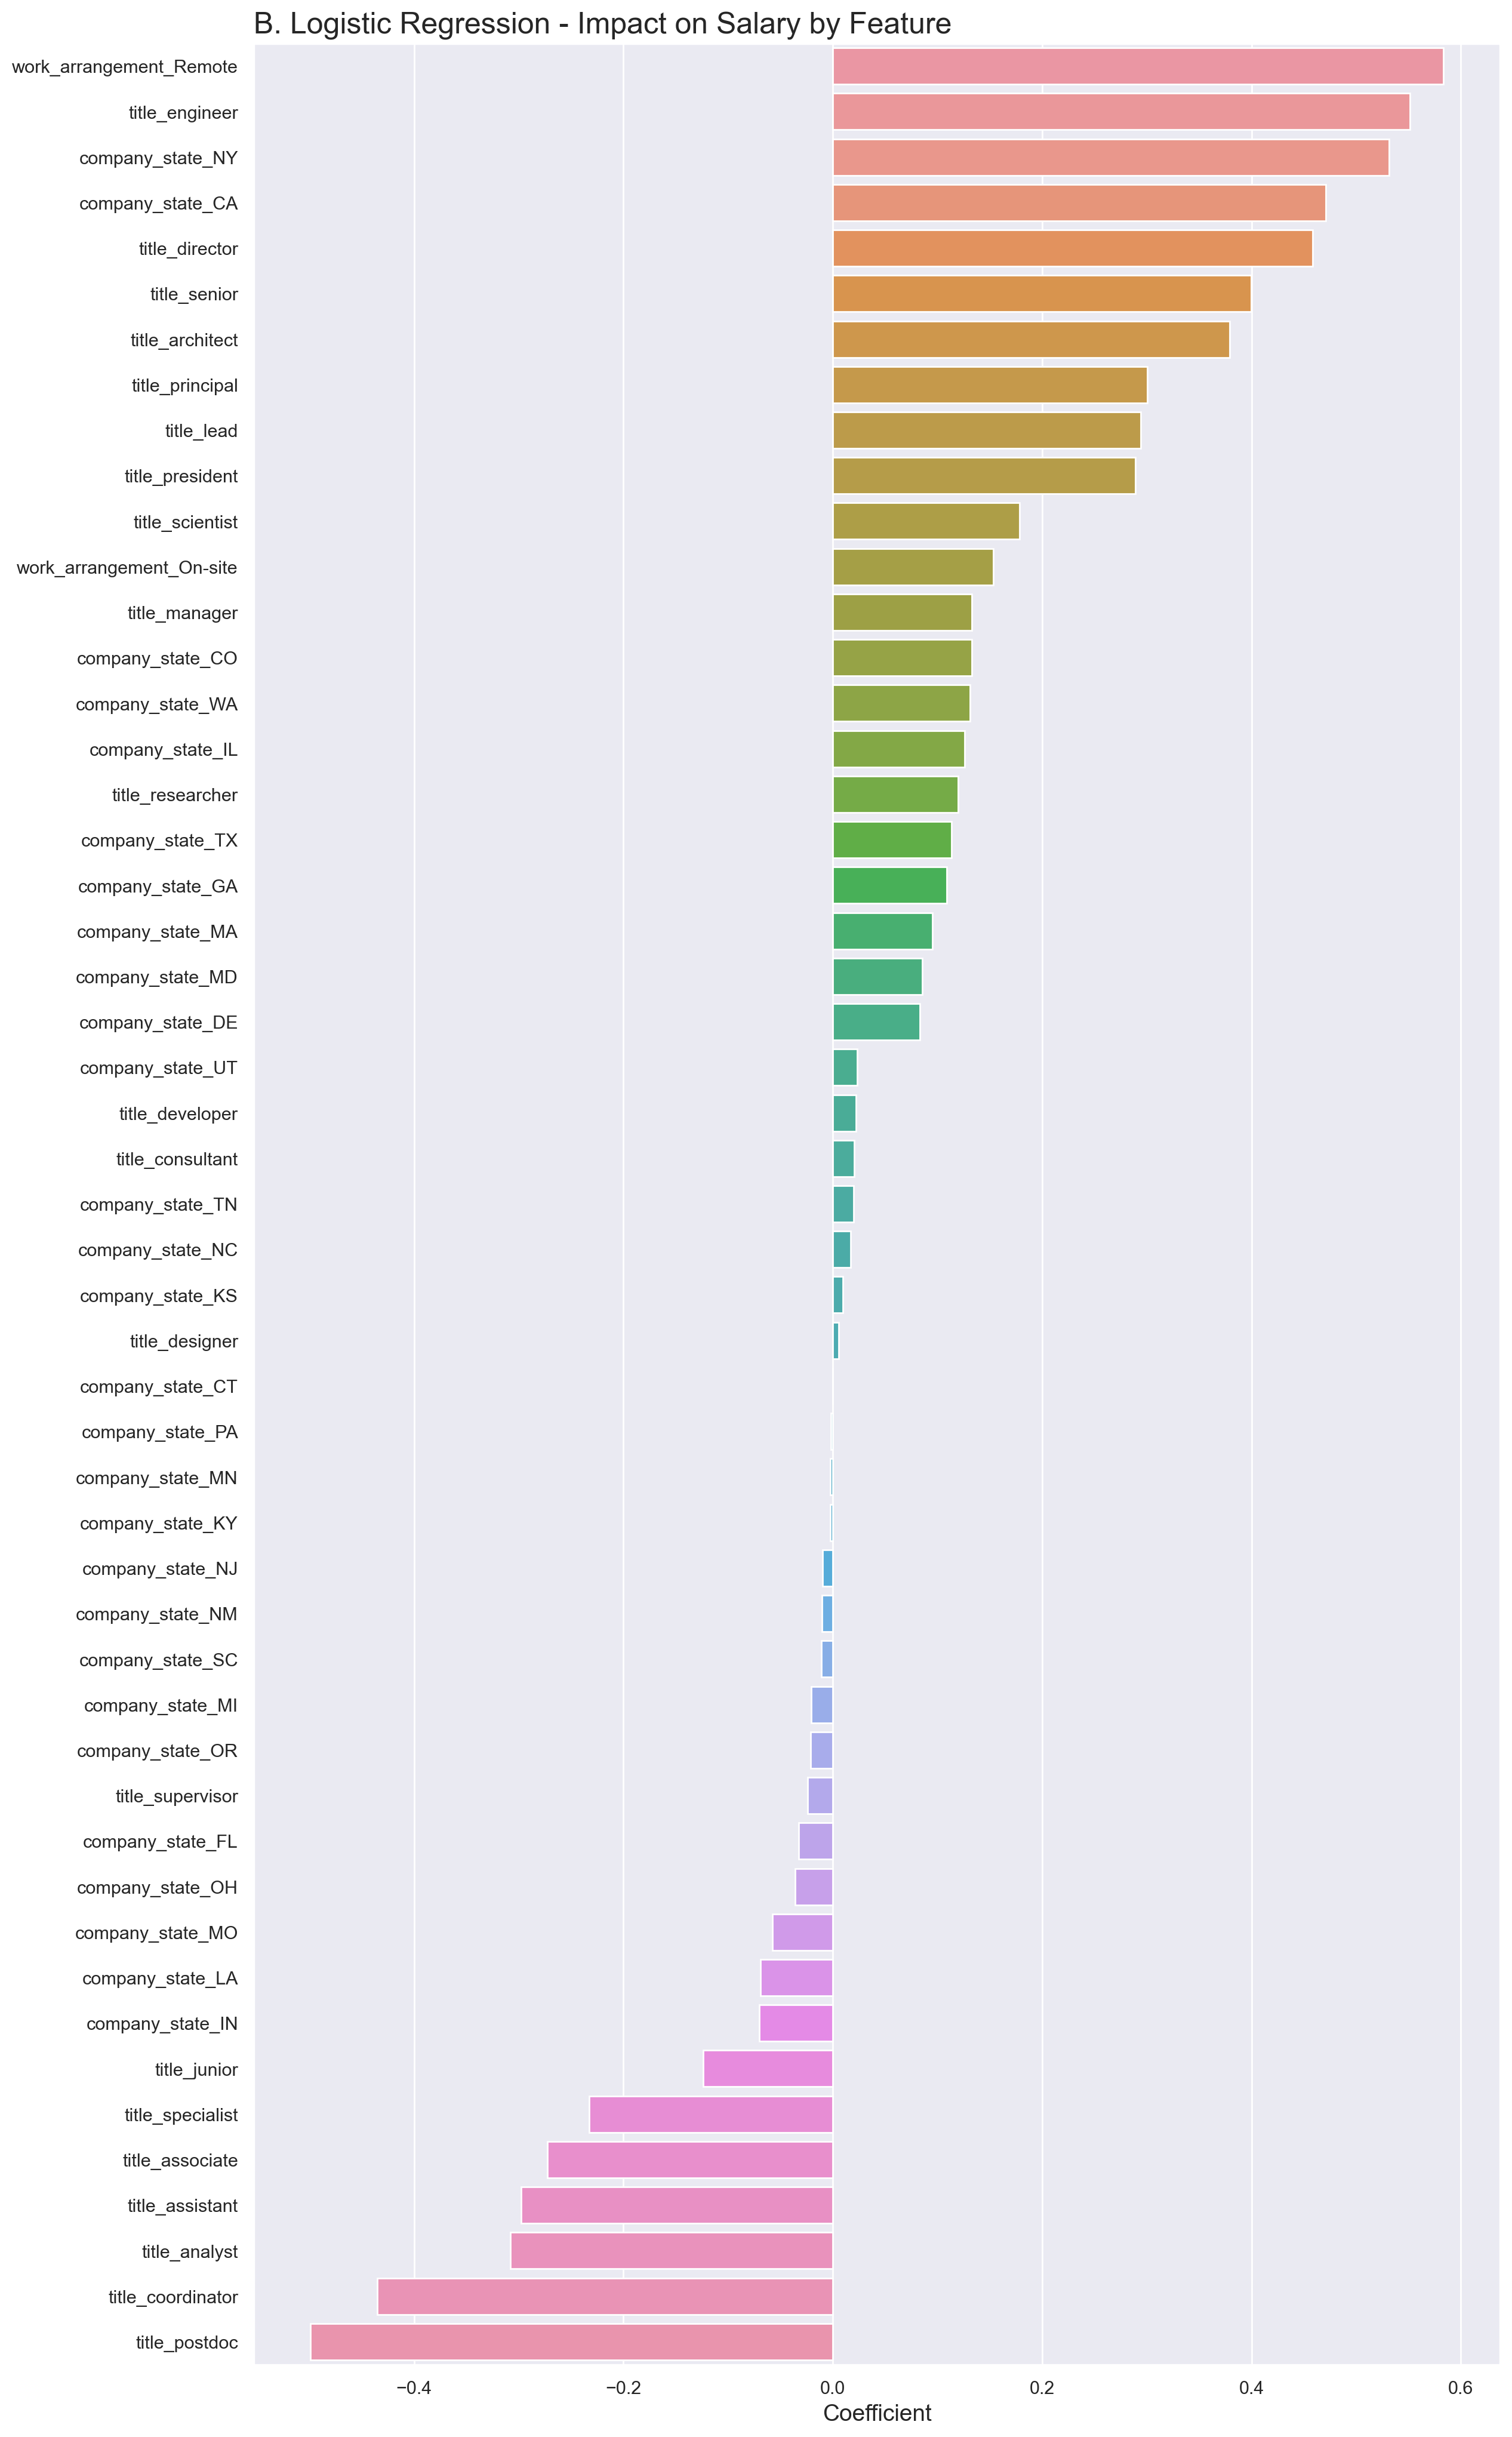

In [51]:
# Plotting the coefficients
fig, ax = plt.subplots(figsize = (12,24))

sns.barplot(x=lr_coef.coefficients.values, y=lr_coef.coefficients.index,
            order=lr_coef.sort_values('coefficients', ascending=False).index, ax=ax)
ax.set_title('B. Logistic Regression - Impact on Salary by Feature', loc='left', fontsize=18)
ax.set_xlabel('Coefficient', fontsize = 14)

plt.show()

Logistic Regression coefficients describe the size and the direction of the relationship between a predictor and the target variable.  
Similarly, the odds ratio is a statistic that quantifies the strength of the association between two events.

In this new model, a **remote** work arrangement, a job title containing **engineer** and a job located in the state of **New York** has a large influence on having a high paying salary since their coefficients are positive and relatively large: there is a 79% increase in the odds of earning a high salary with a job offering a remote work arrangement (73% for the engineer title and 70% for the New York location).
On the other side, job openings containing the titles **postdoc**, **coordinator** and **analyst** have relatively large (and negative) coefficients, so for those job titles the salary would likely be well below median: there is a 39% decrease in the odds of earning a high salary (or a 39% increase in the odds of earning a low salary) with a job title related to postdoc (35% for coordinator and 27% for analyst).  

<br/><br/>

Classification Report

In [52]:
predictions = logreg.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1320
           1       0.74      0.75      0.75      1352

    accuracy                           0.74      2672
   macro avg       0.74      0.74      0.74      2672
weighted avg       0.74      0.74      0.74      2672



Confusion Matrix

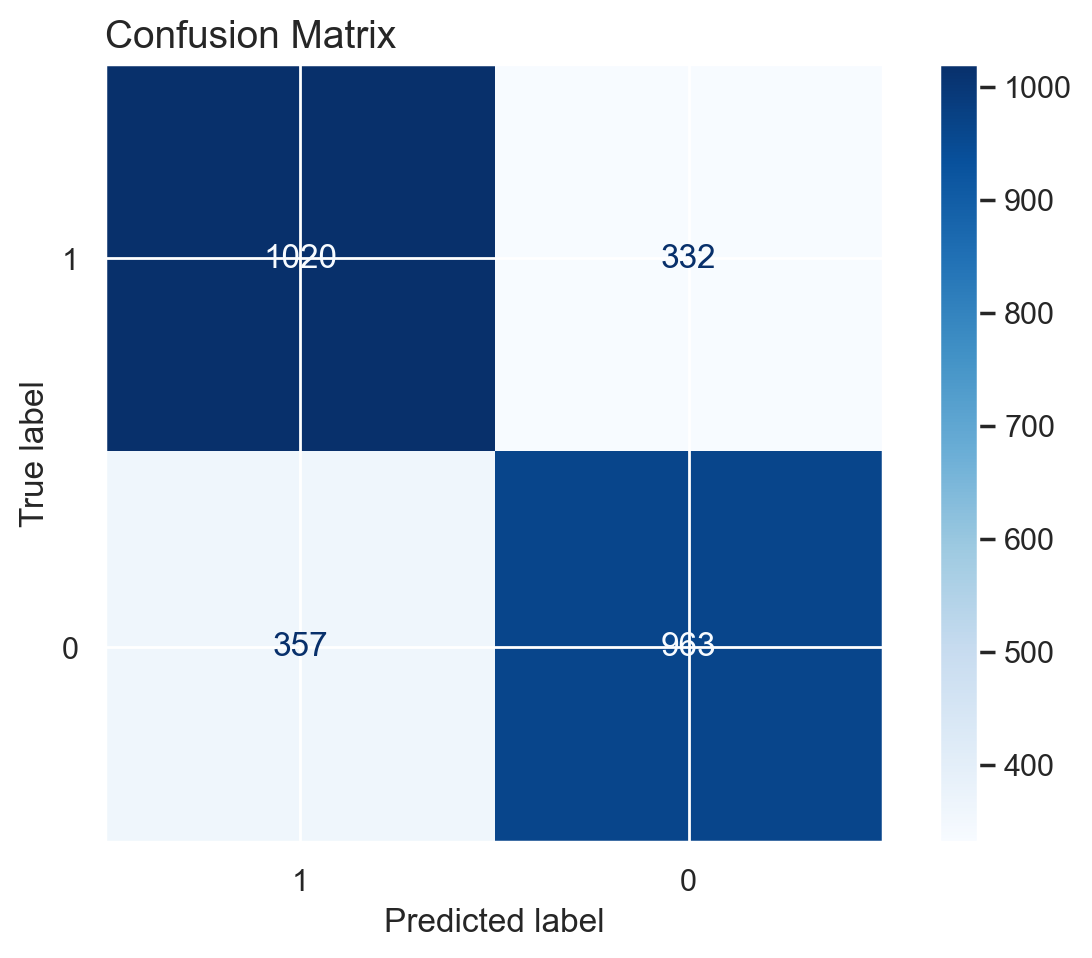

In [53]:
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

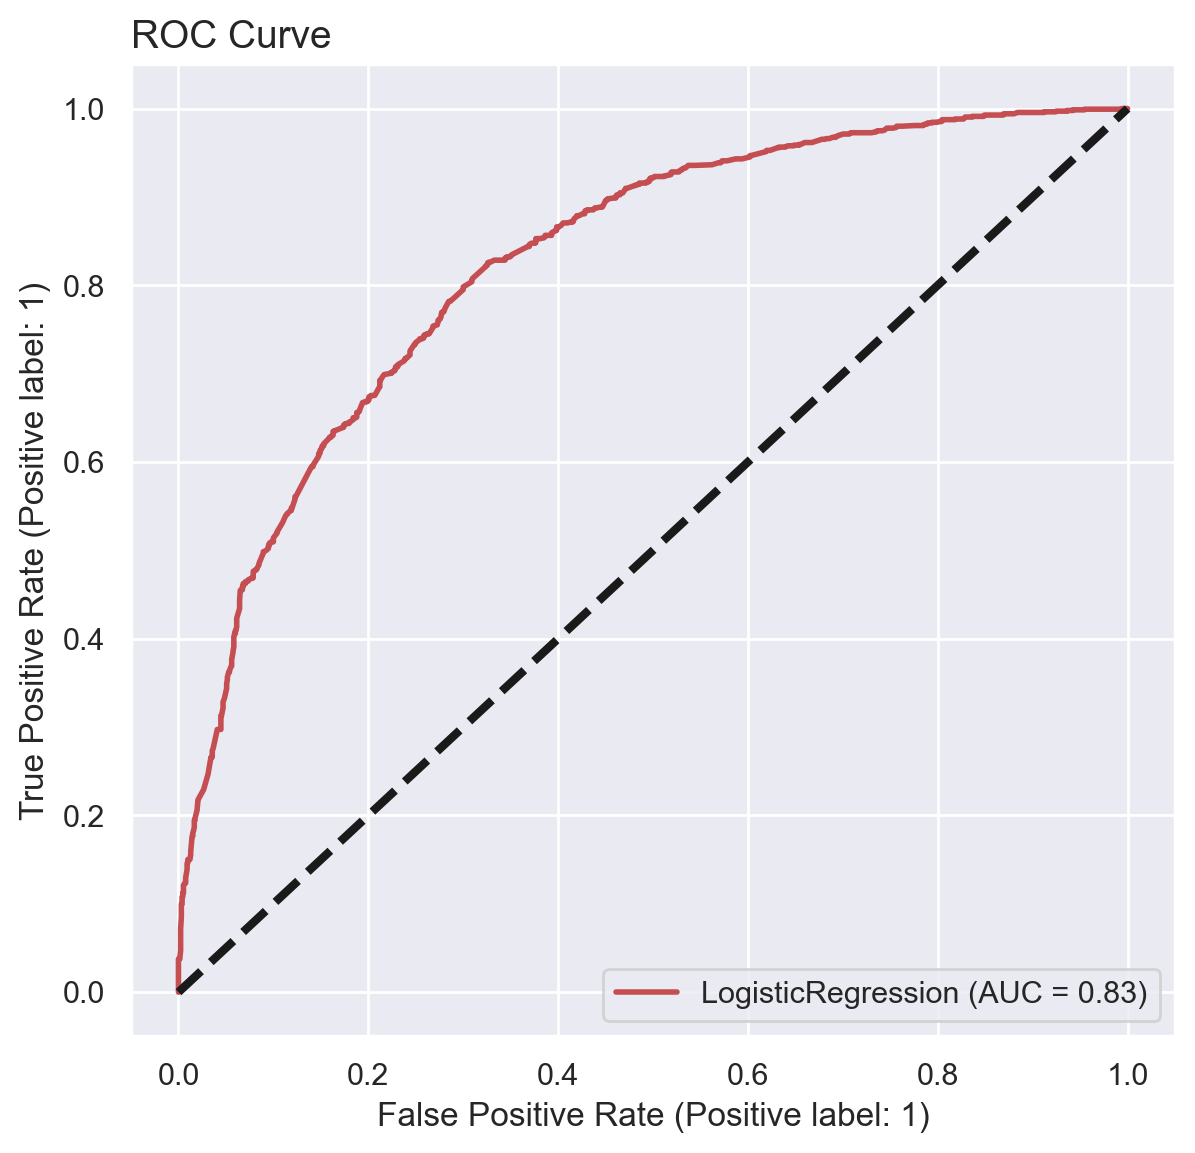

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(logreg, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [55]:
print('ROC-AUC Score:', roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.8259542540792542


Precision-Recall Curve

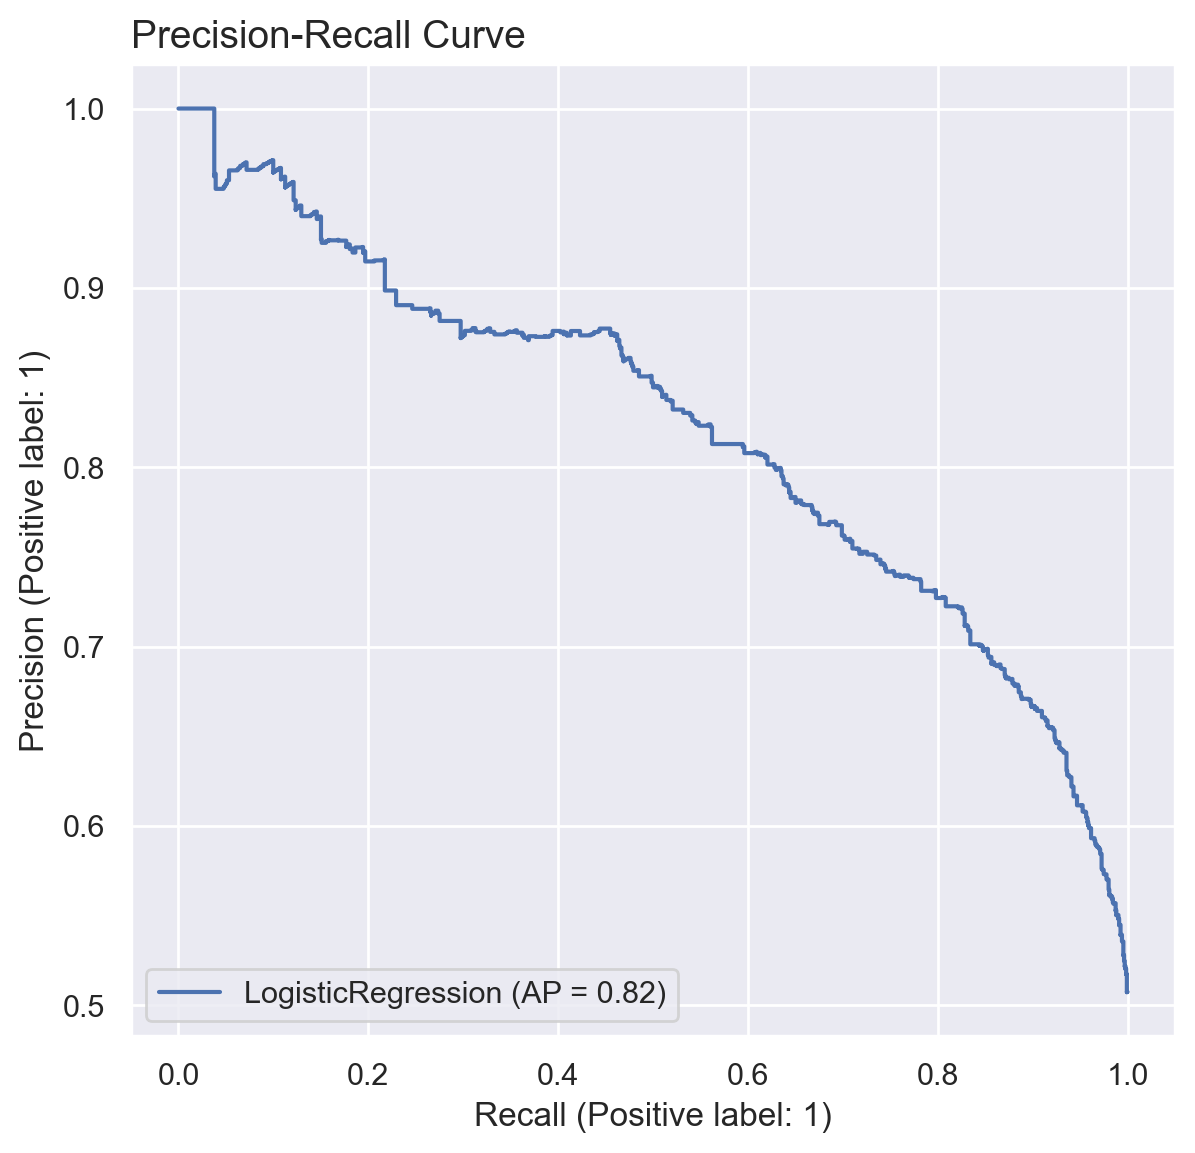

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(logreg, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is fairly good.  
The ROC area under the curve is **0.83**, which tells us that this model has a good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.82**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.70** when recall is around **0.85**.  

<br/><br/>

#### Decision Tree with GridSearchCV

In [57]:
# Defining gridsearch parameters
dtree_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]}


# Defining the model
dtree = DecisionTreeClassifier(random_state = 1)

# Instantiating the gridsearch
dtc_gs = GridSearchCV(dtree, dtree_params, cv=5, n_jobs=10, verbose=1)

# Fitting the gridsearch
dtc_gs.fit(X_train, y_train)

# Extracting the model with the best parameters found in the gridsearch
dt_best = dtc_gs.best_estimator_

# Calculating the scores
b_dt_train = dt_best.score(X_train, y_train)
b_dt_test = dt_best.score(X_test, y_test)
b_dt_cv = (cross_val_score(dt_best, X_train, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
b_dt_df = pd.DataFrame([b_dt_train, b_dt_test, b_dt_cv],
                       index = ['train', 'test', 'CV'], columns = ['B. Decision Tree'])

print('B. Decision Tree Classifier Scores: \n')
print('train score: ', b_dt_train)
print('test score: ', b_dt_test)
print('CV score: ', b_dt_cv)

Fitting 5 folds for each of 1936 candidates, totalling 9680 fits
B. Decision Tree Classifier Scores: 

train score:  0.7834955089820359
test score:  0.7451347305389222
CV score:  0.7439205144644966


Feature Importance & Model Coefficients

In [58]:
# Collecting the model coefficients in a dataframe
dt_coef = pd.DataFrame(dt_best.feature_importances_, columns=['importance'], index=X.columns)
dt_coef.sort_values(by = 'importance', ascending = False)[:10]

importance
title_engineer             0.217556
work_arrangement_Remote    0.070796
title_director             0.062853
title_architect            0.056798
title_scientist            0.048873
company_state_NY           0.045624
title_senior               0.042777
title_principal            0.041446
company_state_CA           0.040048
title_lead                 0.039449

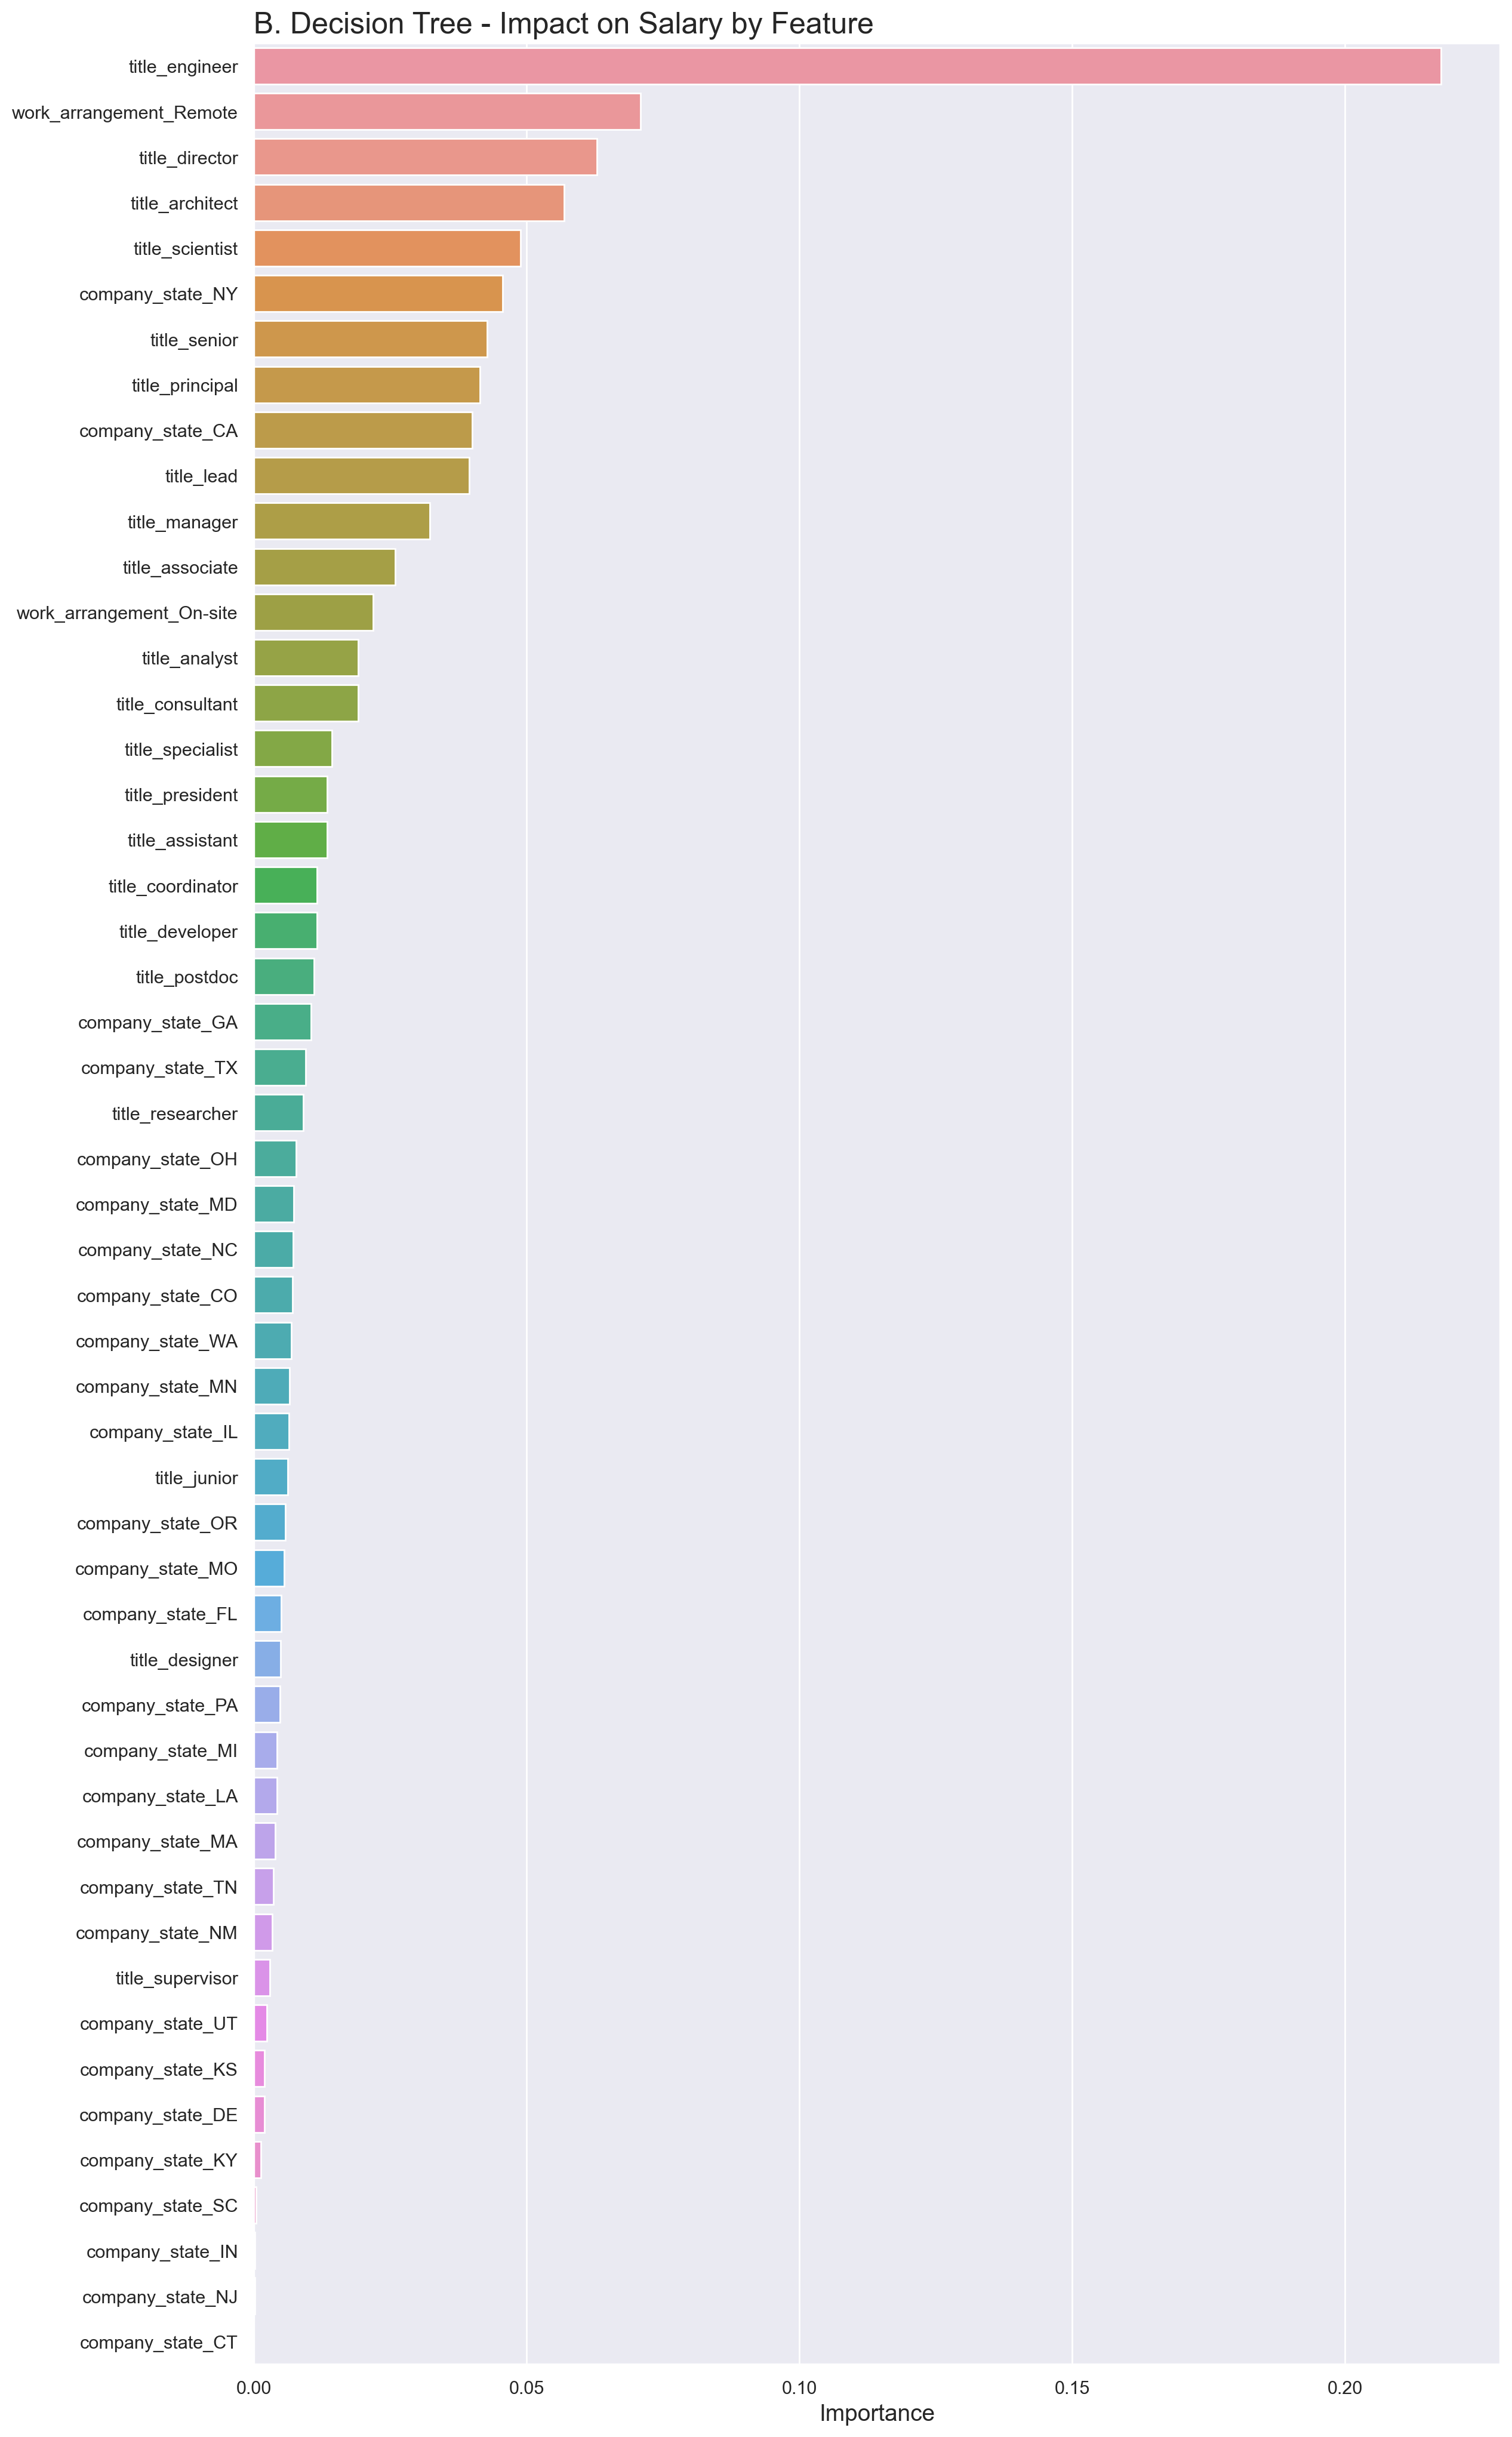

In [59]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,24))

sns.barplot(x=dt_coef.importance.values, y=dt_coef.importance.index,
            order=dt_coef.sort_values('importance', ascending=False).index, ax=ax)
ax.set_title('B. Decision Tree - Impact on Salary by Feature', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show()

Feature importance in Decision Tree is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this new model, a job title containing **engineer**, a **remote** work arrangement and a job title containing **director** have the highest values, indicating that these features have the largest impact on salaries.  
On the other side, jobs located in the states of **Connecticut**, **New Jersey** and **Indiana** have the smallest impact on salaries.  

<br/><br/>

Classification Report

In [60]:
predictions = dt_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1320
           1       0.76      0.73      0.74      1352

    accuracy                           0.75      2672
   macro avg       0.75      0.75      0.75      2672
weighted avg       0.75      0.75      0.75      2672



Confusion Matrix

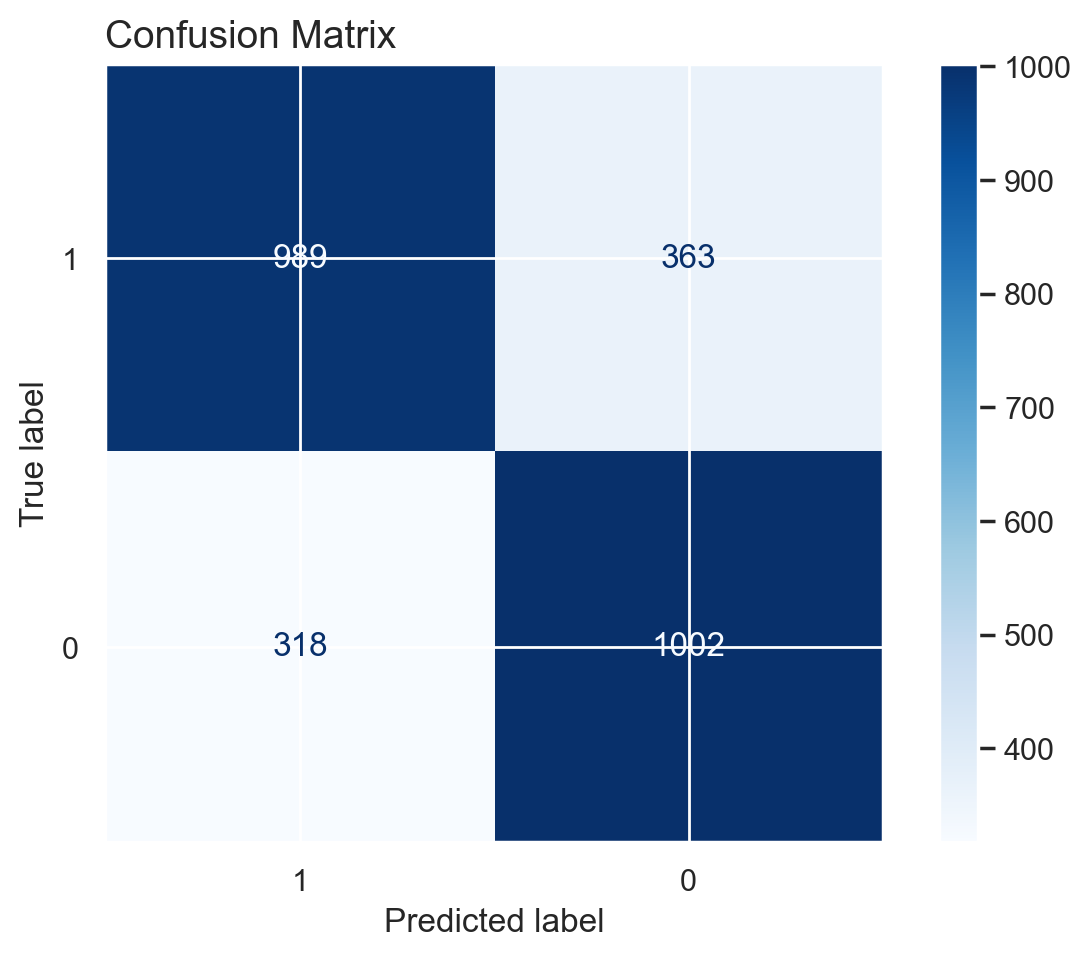

In [61]:
plot_confusion_matrix(dt_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

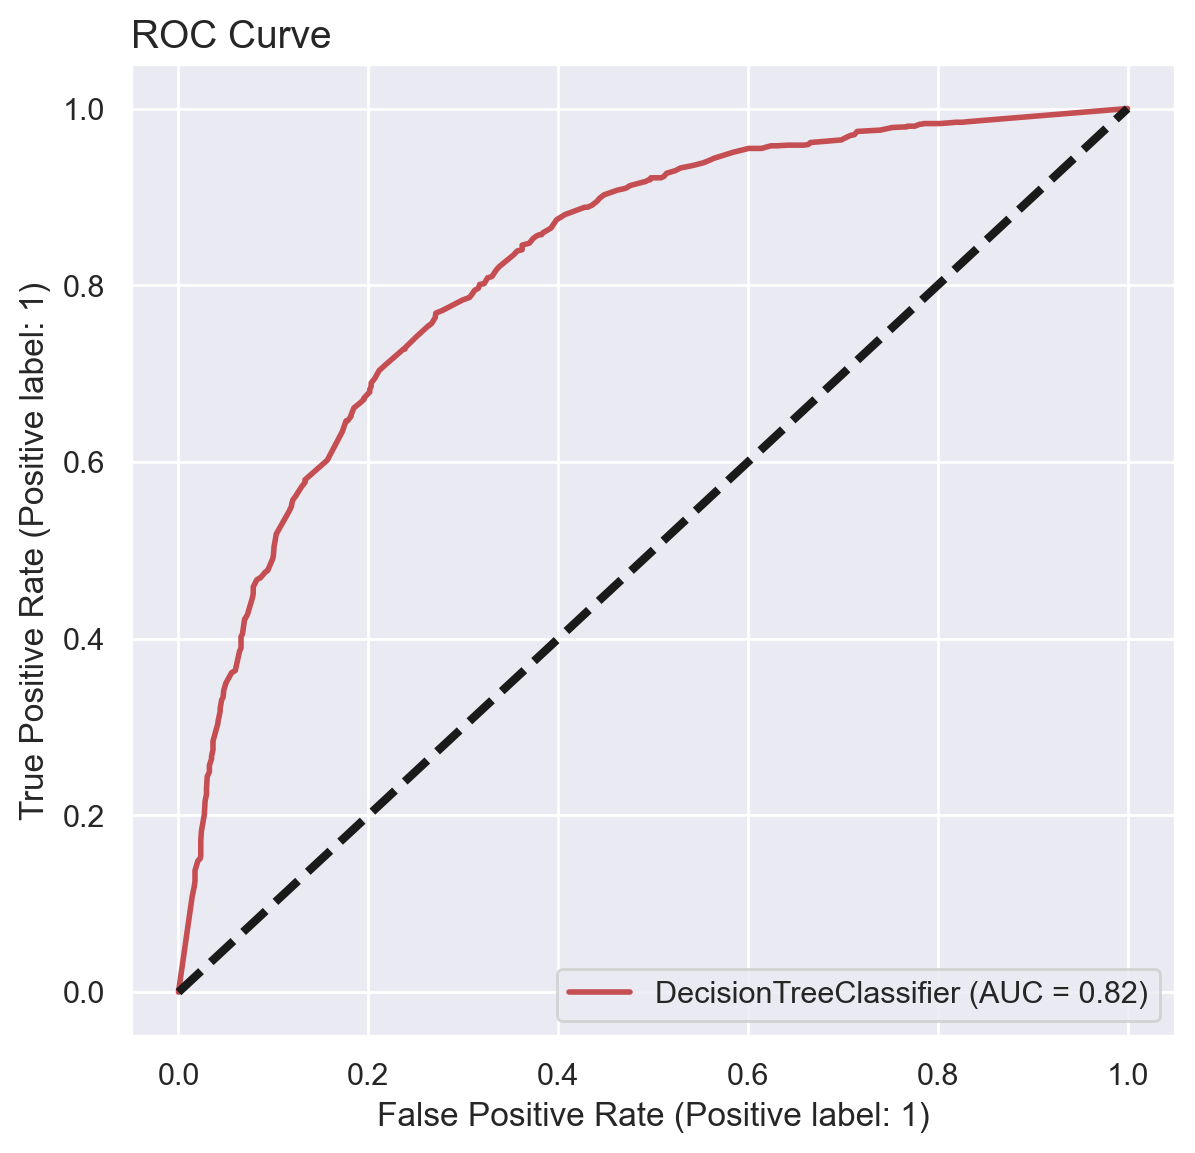

In [62]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(dt_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [63]:
print('ROC-AUC Score:', roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.8232307356105433


Precision-Recall Curve

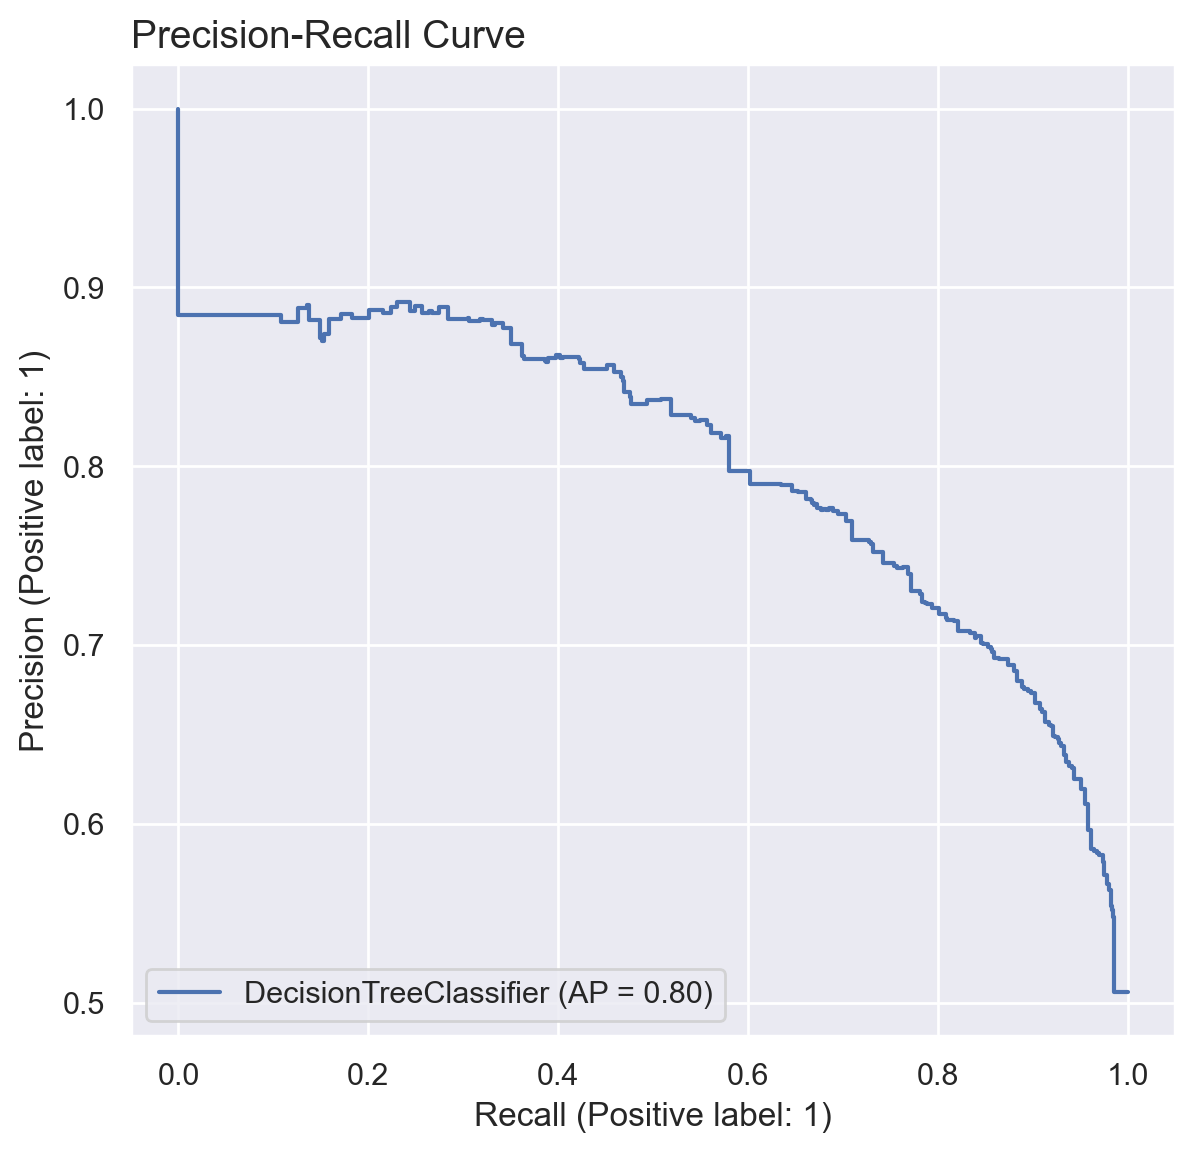

In [64]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(dt_best, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is fairly good.  
The area under the curve is **0.82**, which tells us that this model has a good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.80**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.75** when recall is around **0.70**.  

<br/><br/>

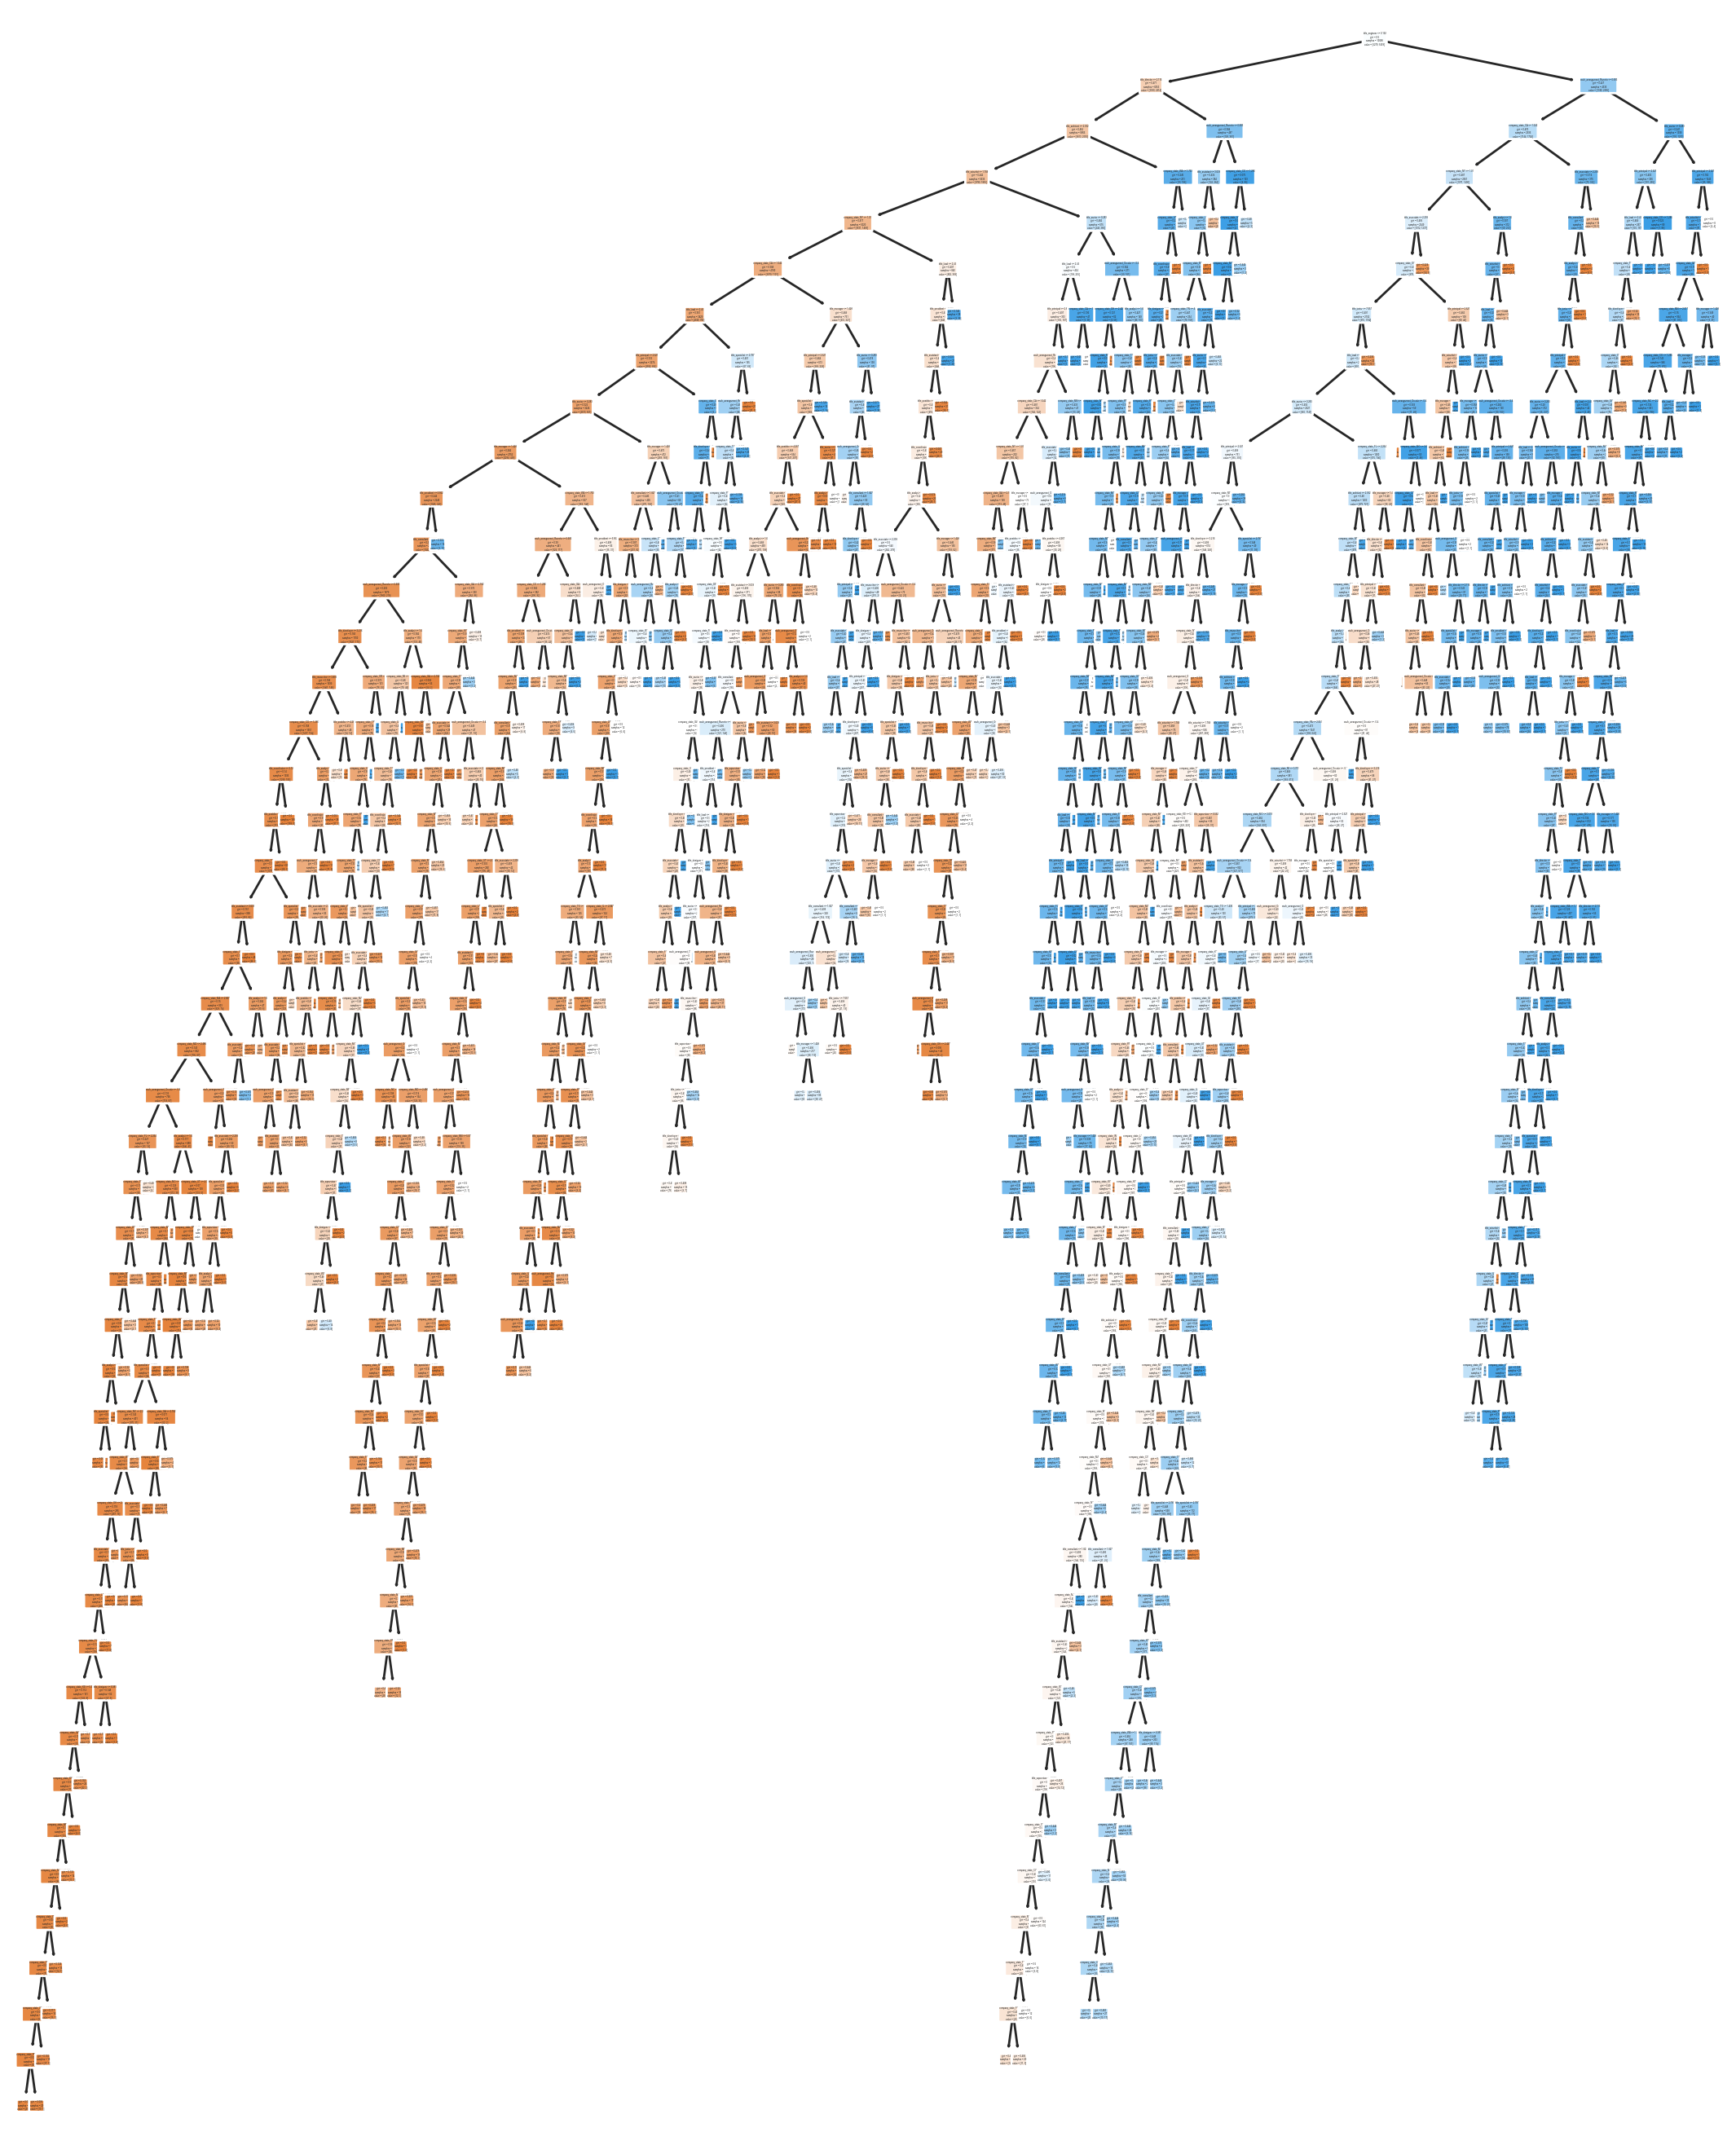

In [65]:
# Showing the Decision Tree using sklearn
plt.figure(figsize=(12,16))
tree.plot_tree(dt_best,
               max_depth=None,
               feature_names=X_train.columns,
               class_names=None,
               label='all',
               filled=True,
               impurity=True,
               node_ids=False,
               proportion=False,
               rounded=True,
               precision=3,
               ax=None,
               fontsize=None)

plt.show()

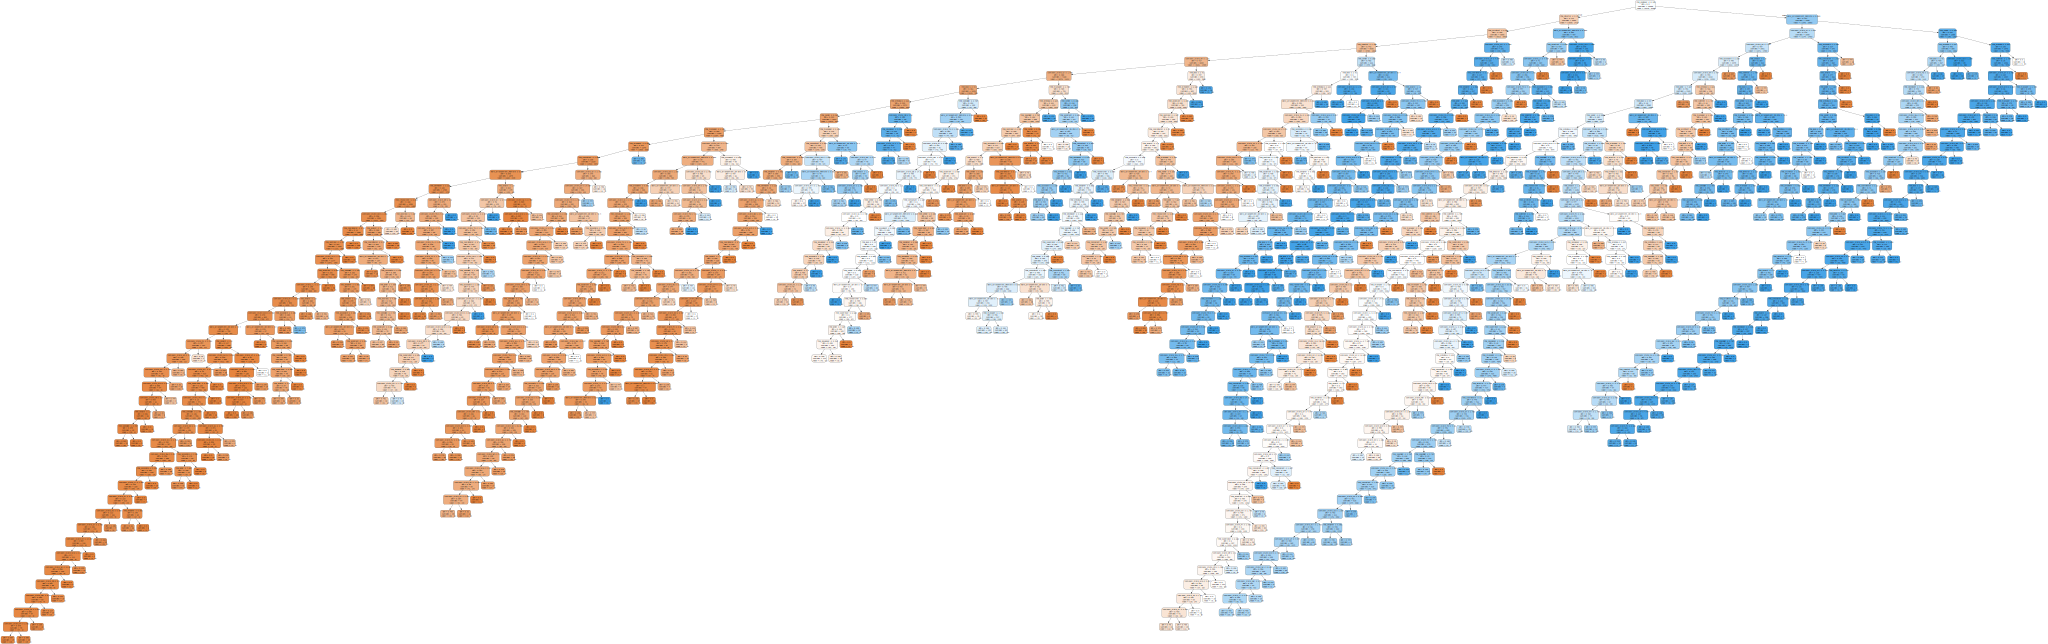

In [66]:
# Showing the Decision Tree using graphviz
dot_data = export_graphviz(dt_best,
                           out_file=None,
                           max_depth=None,
                           feature_names=X_train.columns,
                           class_names=None,
                           label='all',
                           filled=True,
                           leaves_parallel=False,
                           impurity=True,
                           node_ids=False,
                           proportion=False,
                           rotate=False,
                           rounded=True,
                           special_characters=True,
                           precision=3,
                           fontname='helvetica')

graph = graphviz.Source(dot_data) 

graph

In [67]:
# Comments on the decision tree





#### Random Forest with GridSearchCV

In [68]:
# Defining gridsearch parameters
randf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 5, 7]}

# Defining the model
randf = RandomForestClassifier(random_state = 1)

# Instantiating the gridsearch
rfc_gs = GridSearchCV(randf, randf_params, cv=5, n_jobs=10, verbose=1)

# Fitting the gridsearch
rfc_gs.fit(X_train, y_train)

# Extracting the model with the best parameters found in the gridsearch
rf_best = rfc_gs.best_estimator_

# Calculating the scores
b_rf_train = rf_best.score(X_train, y_train)
b_rf_test = rf_best.score(X_test, y_test)
b_rf_cv = (cross_val_score(rf_best, X_train, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
b_rf_df = pd.DataFrame([b_rf_train, b_rf_test, b_rf_cv],
                       index = ['train', 'test', 'CV'], columns = ['B. Random Forest'])

print('B. Random Forest Classifier Scores: \n')
print('train score: ', b_rf_train)
print('test score: ', b_rf_test)
print('CV score: ', b_rf_cv)

Fitting 5 folds for each of 1650 candidates, totalling 8250 fits
B. Random Forest Classifier Scores: 

train score:  0.7738585329341318
test score:  0.7537425149700598
CV score:  0.7486921166128869


Feature Importance & Model Coefficients 

In [69]:
# Collecting the model coefficients in a dataframe
rf_coef = pd.DataFrame(rf_best.feature_importances_, columns=['importance'], index=X.columns)
rf_coef.sort_values(by = 'importance', ascending = False)[:10]

importance
title_engineer              0.153069
title_senior                0.126432
work_arrangement_Remote     0.090022
title_analyst               0.065150
work_arrangement_On-site    0.049900
title_director              0.046023
title_architect             0.038133
title_coordinator           0.037365
title_principal             0.035528
title_lead                  0.033910

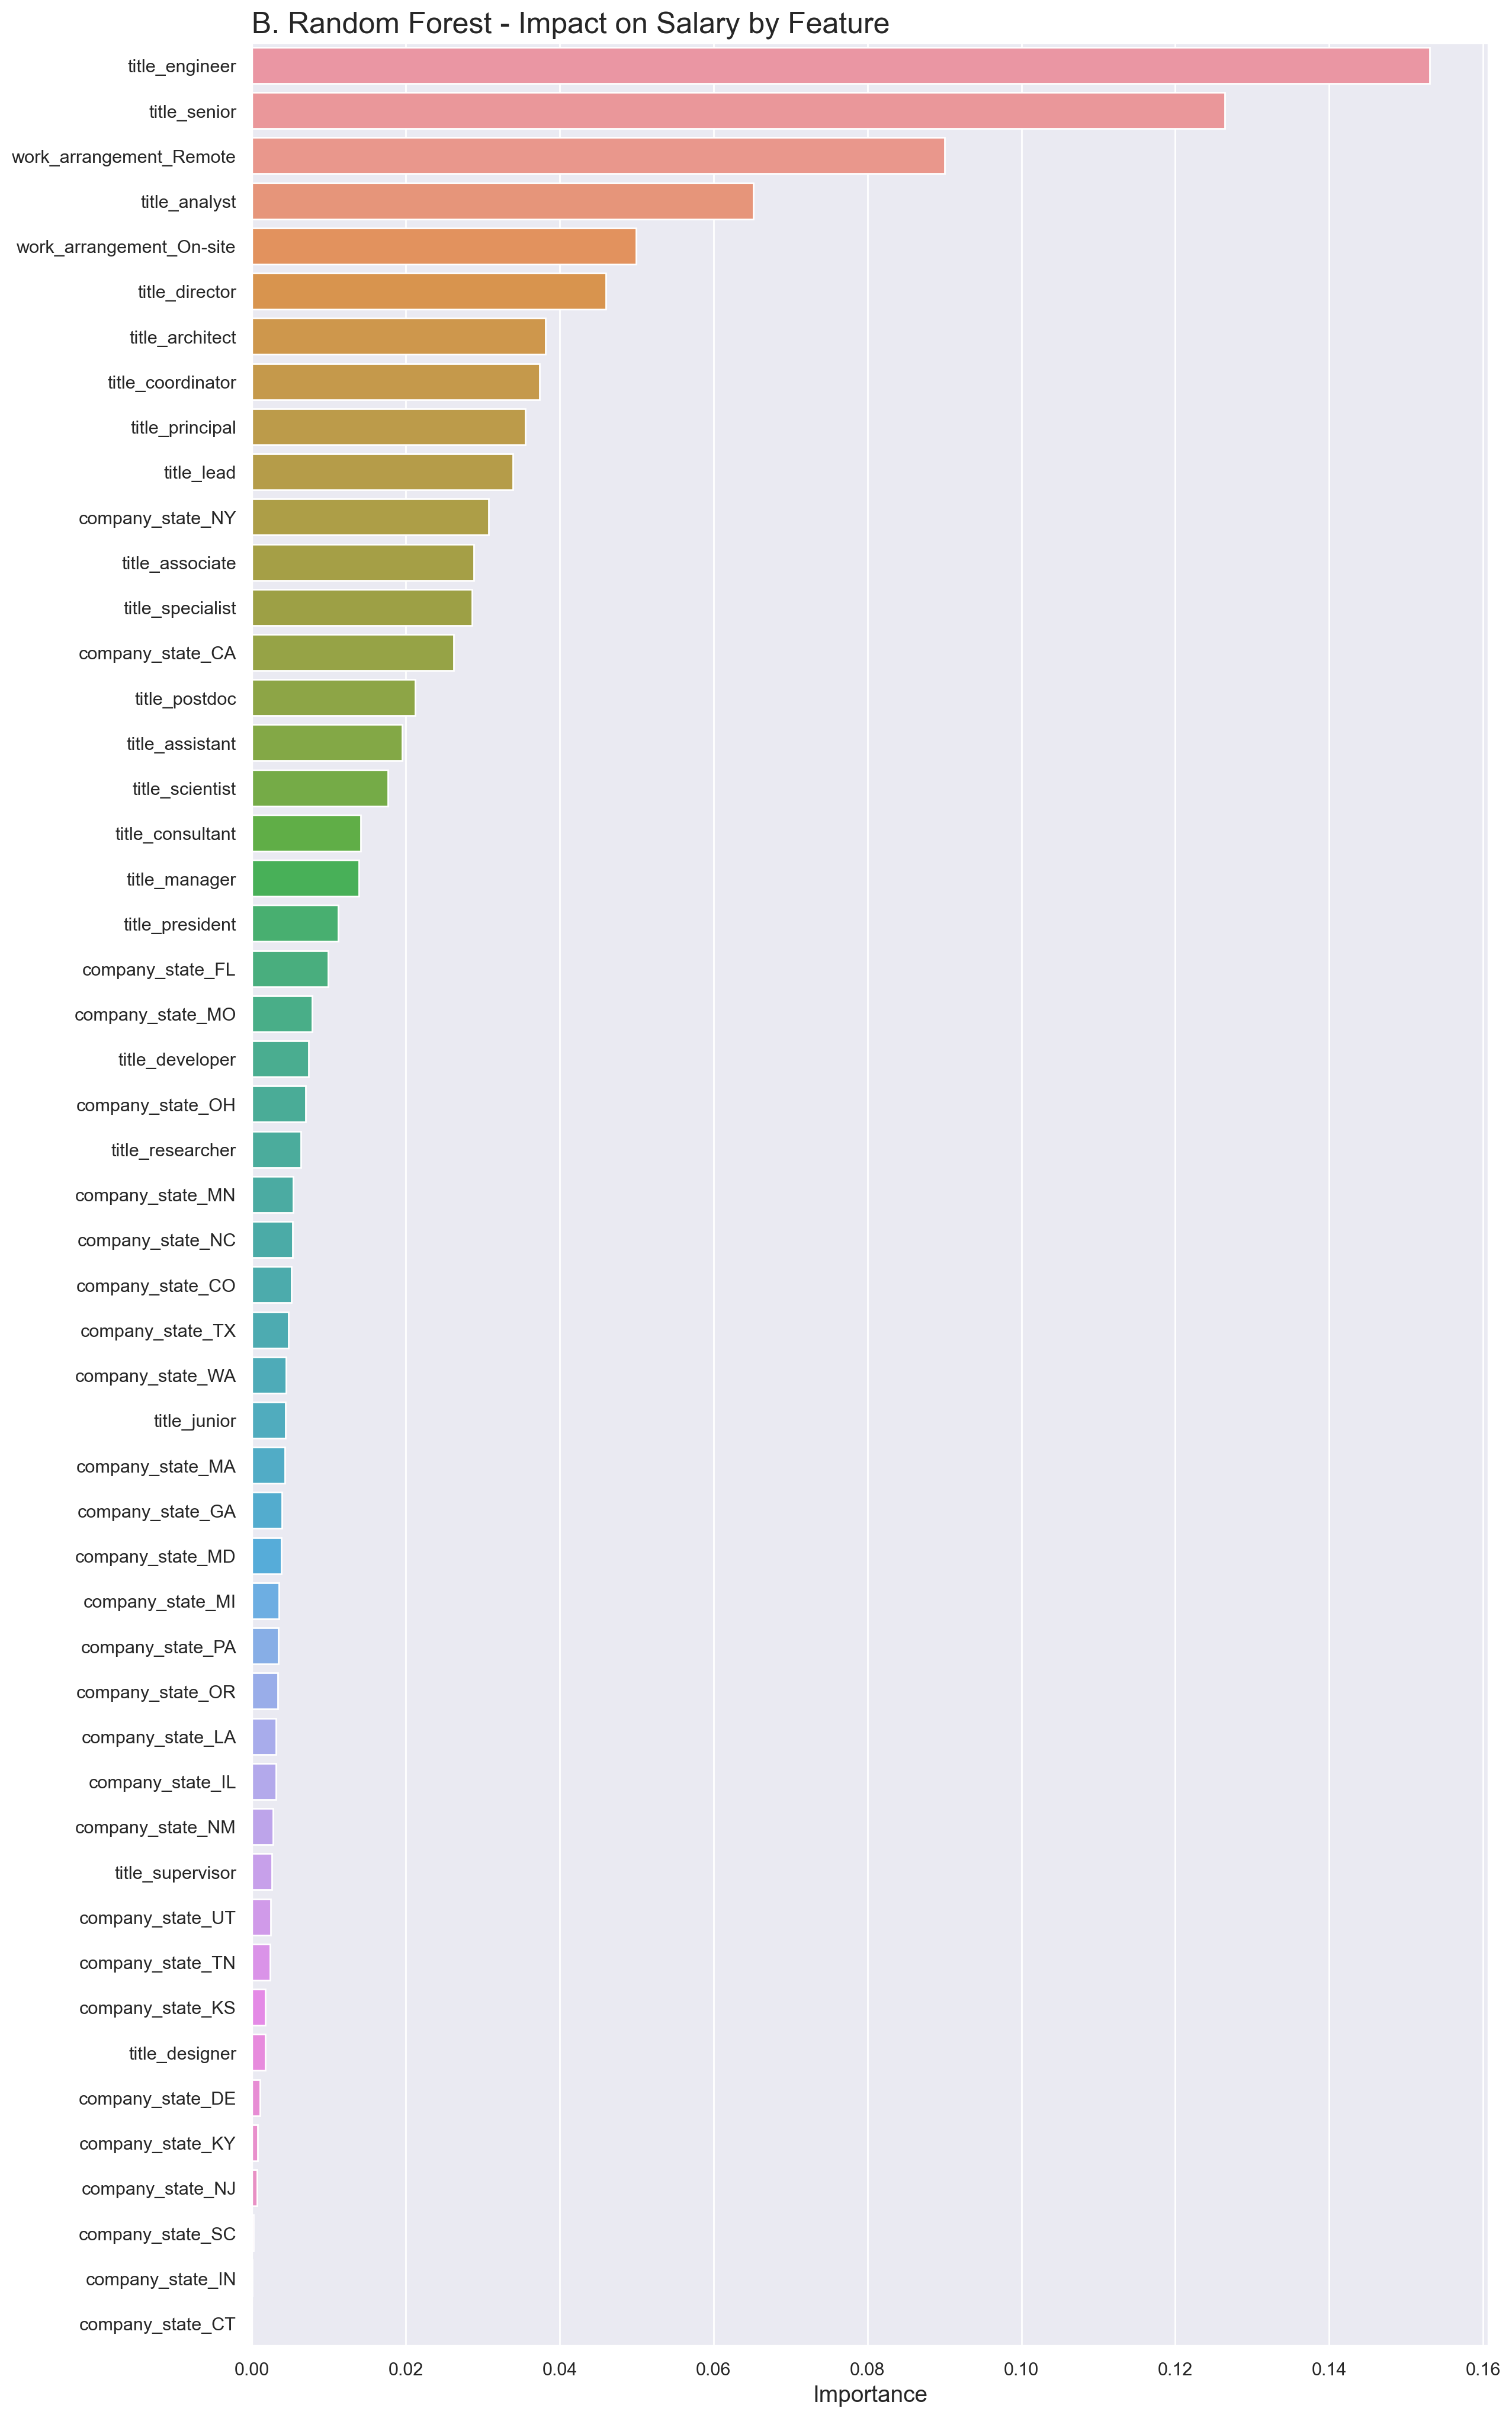

In [70]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,24))

sns.barplot(x=rf_coef.importance.values, y=rf_coef.importance.index,
            order=rf_coef.sort_values('importance', ascending=False).index, ax=ax)
ax.set_title('B. Random Forest - Impact on Salary by Feature', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show() 

Feature importance in Random Forest is based on node impurity and describes the size of the relationship between a predictor and the target variable.  
In this new model, a job title containing **engineer**, a job title containing **senior** and a **remote** work arrangement have the highest values, indicating that these features have the largest impact on salaries.  
On the other side, jobs located in the states of **Connecticut**, **Indiana** and **South Carolina** have the smallest impact on salaries.  

<br/><br/>

Classification Report

In [71]:
predictions = rf_best.predict(X_test)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1320
           1       0.73      0.81      0.77      1352

    accuracy                           0.75      2672
   macro avg       0.76      0.75      0.75      2672
weighted avg       0.76      0.75      0.75      2672



Confusion Matrix

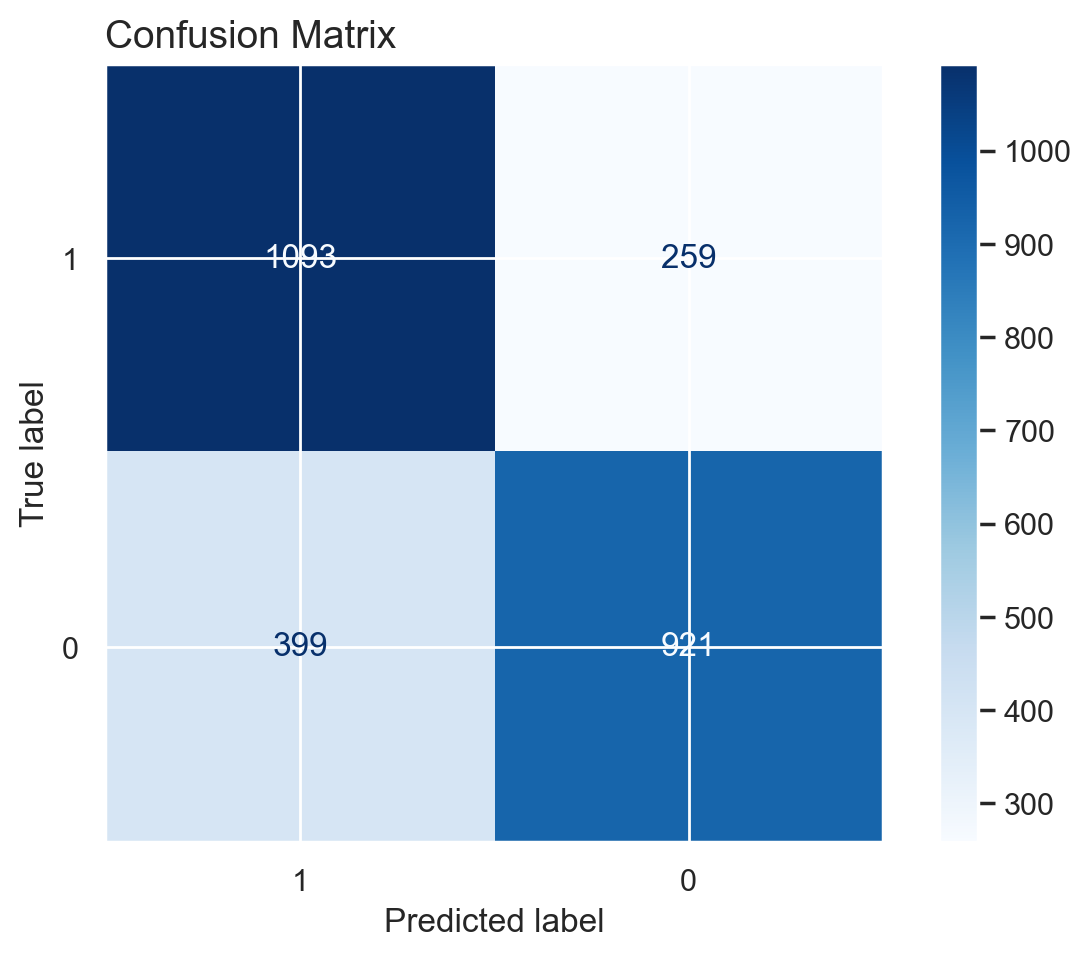

In [72]:
plot_confusion_matrix(rf_best, X_test, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

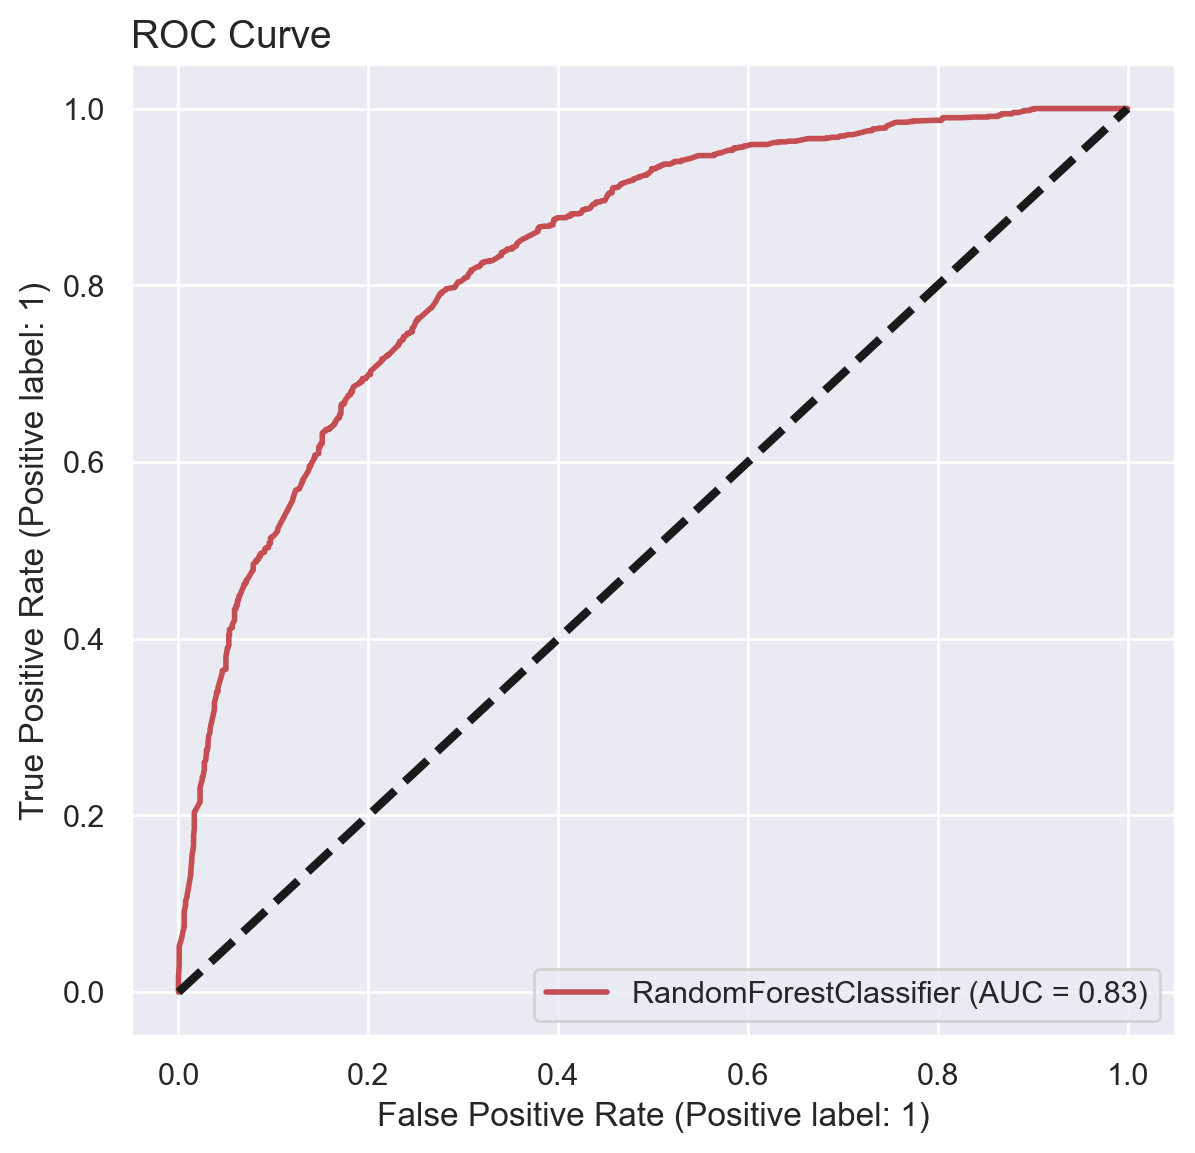

In [73]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(rf_best, X_test, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [74]:
print('ROC-AUC Score:', roc_auc_score(y_test, rf_best.predict_proba(X_test)[:, 1]))

ROC-AUC Score: 0.834266294602833


Precision-Recall Curve

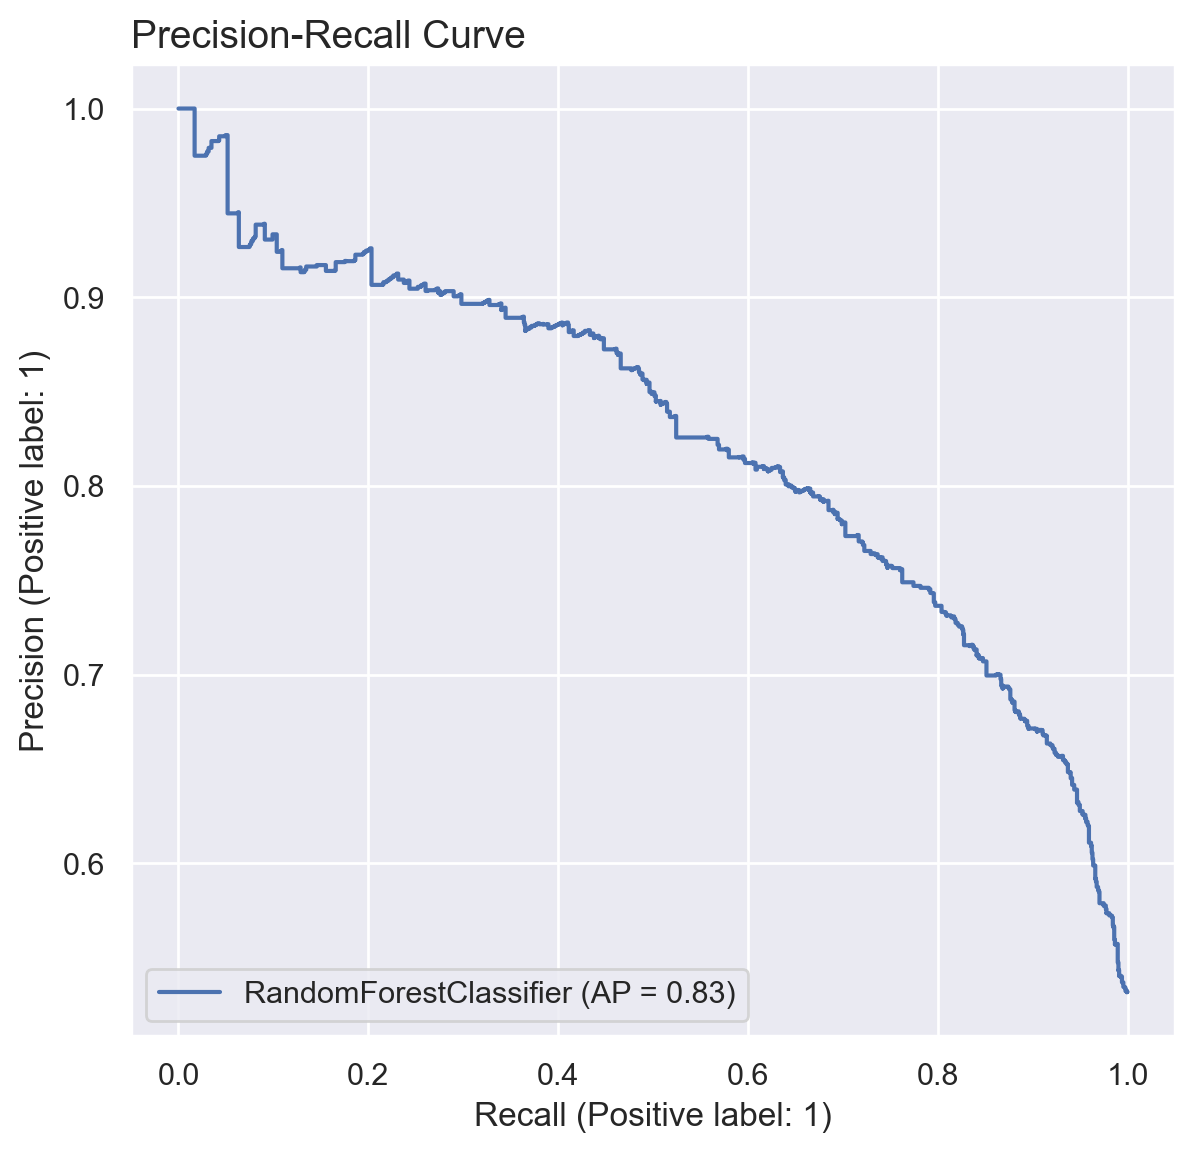

In [75]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(rf_best, X_test, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is fairly good.  
The area under the curve is **0.83**, which tells us that this model has a good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.83**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.75** when recall is around **0.80**.  

<br/><br/>

#### Model Scores Evaluation

In [76]:
B_models = pd.concat([b_logreg_df, b_dt_df, b_rf_df], axis = 1)
B_models

B. Logistic Reg  B. Decision Tree  B. Random Forest
train         0.748222          0.783496          0.773859
test          0.742141          0.745135          0.753743
CV            0.746539          0.743921          0.748692

In the three models implemented above, **Random Forest** achieved the highest CV score of **0.7486**  

The most important features for this model were **title_engineer**, **title_senior** and **title_director**. According to the Random Forest Classifier, upper level positions and engineering related jobs have the biggest impact in predicting job salaries.

Although the Random Forest Classifer performed the best, all the three model scores were quite close to one another, and were about 0.23 higher than the baseline of 0.5 indicating that the models made substantially better predictions.  
Since these models did significantly better than the previous models that relied only on location, it can be concluded that factors such as job titles and roles can affect the salary level.  
<br/><br/>

### *C. Using additional features created with CountVectorizer*

We are creating new variables in the dataframe, by using CountVectorizer to extract features from text.  

<br/><br/>

In [77]:
# Creating a new predictor matrix with more features
X = df[['job_title', 'company_state', 'work_arrangement']].copy()
X = pd.get_dummies(X, columns = ['company_state', 'work_arrangement'], drop_first = True)

In [78]:
# Creating a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=1)

In [79]:
# Checking the shape of the modelling sets
print('Training set shape')
print('X:', X_train.shape)
print('y:', y_train.shape)
print('')
print('Test set shape')
print('X:', X_test.shape)
print('y:', y_test.shape)

Training set shape
X: (10688, 31)
y: (10688,)

Test set shape
X: (2672, 31)
y: (2672,)


In [80]:
# Copying X_train and X_test to reuse with TfidfVectorizer
X_train_cvec = X_train.copy()
X_test_cvec = X_test.copy()

In [81]:
# Instantiating and fitting CountVectorizer on the job title column
cvec = CountVectorizer(token_pattern='\w+', stop_words = 'english')
cvec.fit(X_train_cvec['job_title'])

CountVectorizer(stop_words='english', token_pattern='\\w+')

In [82]:
# Transforming and displaying the training set
X_train_job_title = pd.DataFrame(cvec.transform(X_train_cvec['job_title']).toarray(),
                                 columns=cvec.get_feature_names_out())
X_train_job_title.head()

0  000  00028506  0038528  00809  02  0205  0245  0266  0272  ...  ykt  yn  \
0  0    0         0        0      0   0     0     0     0     0  ...    0   0   
1  0    0         0        0      0   0     0     0     0     0  ...    0   0   
2  0    0         0        0      0   0     0     0     0     0  ...    0   0   
3  0    0         0        0      0   0     0     0     0     0  ...    0   0   
4  0    0         0        0      0   0     0     0     0     0  ...    0   0   

   york  yorktown  young  youth  zero  zone  zones  zoning  
0     0         0      0      0     0     0      0       0  
1     0         0      0      0     0     0      0       0  
2     0         0      0      0     0     0      0       0  
3     0         0      0      0     0     0      0       0  
4     0         0      0      0     0     0      0       0  

[5 rows x 3504 columns]

In [83]:
# Transforming the test set
X_test_job_title = pd.DataFrame(cvec.transform(X_test_cvec['job_title']).toarray(),
                                columns=cvec.get_feature_names_out())

In [84]:
# Displaying the most frequent words in the training set
X_train_job_title.sum(axis = 0).sort_values(ascending = False).iloc[:20]

engineer      4273
senior        3351
data          1407
research      1310
manager       1001
software       883
sr             855
analyst        855
scientist      718
consultant     675
remote         653
director       542
associate      475
principal      406
business       404
cloud          396
lead           369
project        351
specialist     333
systems        301
dtype: int64

In [85]:
# Resetting X_train index to concatenate vectorised matrix back
X_train_cvec.reset_index(drop = True, inplace = True)
# Dropping the job title column as this information is in the vectorised matrix
X_train_cvec.drop(columns = ['job_title'], inplace = True)

In [86]:
# Concatenating the vectorised matrix to the original dataframe
X_train_cvec = pd.concat([X_train_cvec, X_train_job_title], axis = 1)
X_train_cvec.head()

company_state_CA  company_state_CO  company_state_CT  company_state_DE  \
0                 0                 1                 0                 0   
1                 0                 0                 0                 0   
2                 1                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   company_state_FL  company_state_GA  company_state_IL  company_state_IN  \
0                 0                 0                 0                 0   
1                 1                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   company_state_KS  company_state_KY  ...  ykt  yn  york  yorktown  young  \
0                 0                 0  ...    0   0     0         0      0   
1                 0                 0  ...    0   0     0         0      0   
2                 0                 0  ...    0   0     0         0      0   
3                 0                 0  ...    0   0     0         0      0   
4                 0                 0  ...    0   0     0         0      0   

   youth  zero  zone  zones  zoning  
0      0     0     0      0       0  
1      0     0     0      0       0  
2      0     0     0      0       0  
3      0     0     0      0       0  
4      0     0     0      0       0  

[5 rows x 3534 columns]

In [87]:
# Resetting X_test index to concatenate vectorised matrix back
X_test_cvec.reset_index(drop = True, inplace = True)
# Dropping the job title column as this information is in the vectorised matrix
X_test_cvec.drop(columns = ['job_title'], inplace = True)

In [88]:
# Concatenating the vectorised matrix to the original dataframe
X_test_cvec = pd.concat([X_test_cvec, X_test_job_title], axis = 1)
X_test_cvec.head()

company_state_CA  company_state_CO  company_state_CT  company_state_DE  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 1                 0                 0                 0   
4                 0                 0                 0                 0   

   company_state_FL  company_state_GA  company_state_IL  company_state_IN  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   company_state_KS  company_state_KY  ...  ykt  yn  york  yorktown  young  \
0                 0                 0  ...    0   0     0         0      0   
1                 0                 0  ...    0   0     0         0      0   
2                 0                 0  ...    0   0     0         0      0   
3                 0                 0  ...    0   0     0         0      0   
4                 0                 0  ...    0   0     0         0      0   

   youth  zero  zone  zones  zoning  
0      0     0     0      0       0  
1      0     0     0      0       0  
2      0     0     0      0       0  
3      0     0     0      0       0  
4      0     0     0      0       0  

[5 rows x 3534 columns]

#### Logistic Regression

In [89]:
# Instantiating the model 
logreg = LogisticRegression(solver='saga', multi_class='auto', max_iter=1000)

# Fitting the model
logreg.fit(X_train_cvec, y_train)

# Calculating scores
c_logreg_train = logreg.score(X_train_cvec, y_train)
c_logreg_test = logreg.score(X_test_cvec, y_test)
c_logreg_cv = (cross_val_score(logreg, X_train_cvec, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
c_logreg_df = pd.DataFrame([c_logreg_train, c_logreg_test, c_logreg_cv],
                           index = ['train', 'test', 'CV'], columns=['C. Logistic Reg'])

print('C. Logistic Regression Scores: \n')
print('train score: ', c_logreg_train)
print('test score: ', c_logreg_test)
print('CV score: ', c_logreg_cv)

C. Logistic Regression Scores: 

train score:  0.8570359281437125
test score:  0.8080089820359282
CV score:  0.8071652424646928


Feature Importance & Model Coefficients

In [90]:
# Collecting the model coefficients in a dataframe
lr_coef = pd.DataFrame(logreg.coef_[0], index=X_train_cvec.columns, columns=['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[:5]

coefficients
startup           2.449270
fullstack         2.348531
quantitative      2.183058
leader            2.151326
global            2.110904

In [91]:
# Adding odds ratios in the dataframe
lr_coef['odds_ratio'] = np.exp(lr_coef['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[:25]

coefficients  odds_ratio
startup           2.449270   11.579896
fullstack         2.348531   10.470175
quantitative      2.183058    8.873401
leader            2.151326    8.596246
global            2.110904    8.255704
vp                2.080816    8.010999
avp               2.079444    8.000017
applied           2.008859    7.454805
vice              1.990297    7.317707
director          1.972817    7.190903
fpga              1.945596    6.997800
vision            1.922368    6.837127
physician         1.916078    6.794261
sap               1.909333    6.748584
corporate         1.863860    6.448579
android           1.860844    6.429158
javascript        1.841781    6.307760
unified           1.838125    6.284741
prisma            1.830150    6.234824
tableau           1.807713    6.096487
president         1.791488    5.998370
ai                1.781885    5.941042
mobile            1.718339    5.575262
ipo               1.717775    5.572119
architect         1.717277    5.569340

In [92]:
# Adding odds ratios in the dataframe
lr_coef['odds_ratio'] = np.exp(lr_coef['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[-25:]

coefficients  odds_ratio
commissioning         -1.281484    0.277625
journey               -1.283107    0.277175
associate             -1.284304    0.276843
tia                   -1.293319    0.274359
databricks            -1.299307    0.272721
hydrogeologist        -1.301706    0.272067
gis                   -1.316440    0.268088
virtualization        -1.340541    0.261704
generation            -1.377704    0.252157
connectall            -1.406401    0.245024
oregon                -1.431367    0.238982
planner               -1.436488    0.237761
sustainability        -1.461078    0.231986
analyst               -1.507594    0.221442
school                -1.528627    0.216833
assistant             -1.606109    0.200667
interdisciplinary     -1.670911    0.188076
dshs                  -1.712900    0.180342
accountant            -1.715503    0.179873
jr                    -1.822384    0.161640
california            -1.851103    0.157064
entry                 -1.903386    0.149063
coordinator           -1.937605    0.144049
technician            -2.065285    0.126782
postdoctoral          -2.805702    0.060464

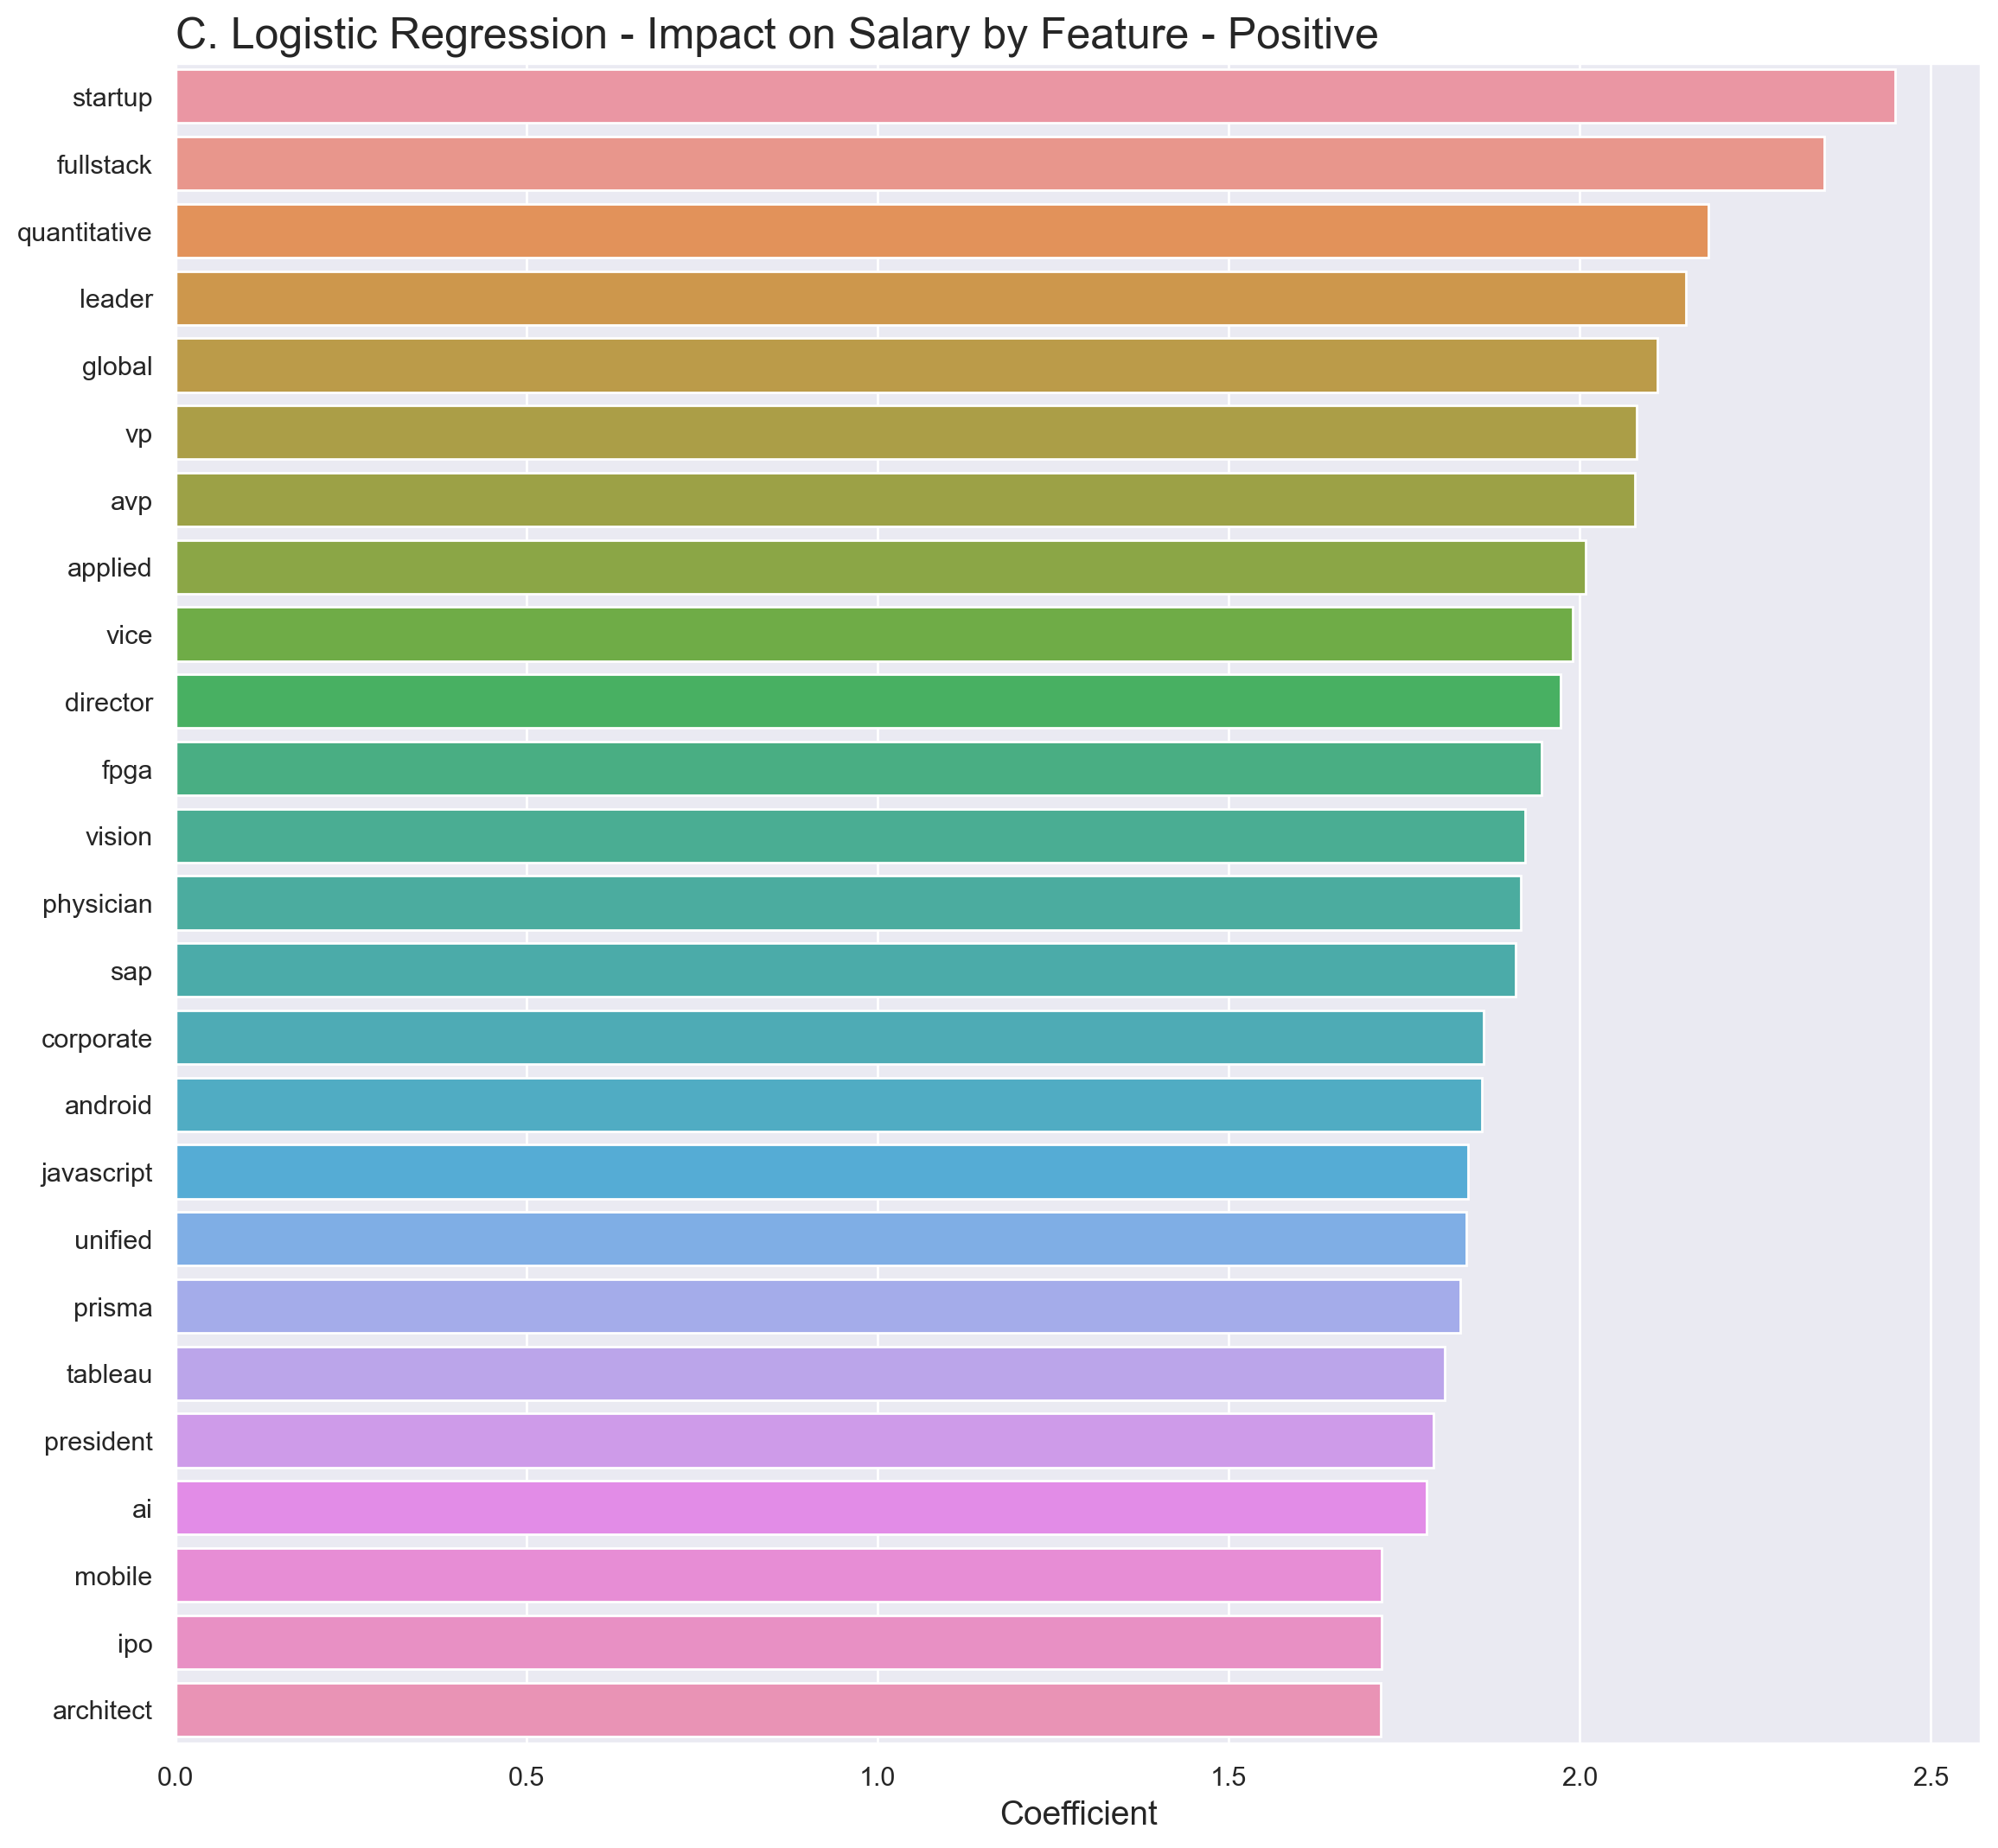

In [93]:
# Plotting the coefficients
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=lr_coef.coefficients.values, y=lr_coef.coefficients.index,
            order=lr_coef.sort_values('coefficients', ascending=False)[:25].index, ax=ax)
ax.set_title('C. Logistic Regression - Impact on Salary by Feature - Positive', loc='left', fontsize=18)
ax.set_xlabel('Coefficient', fontsize = 14)

plt.show()

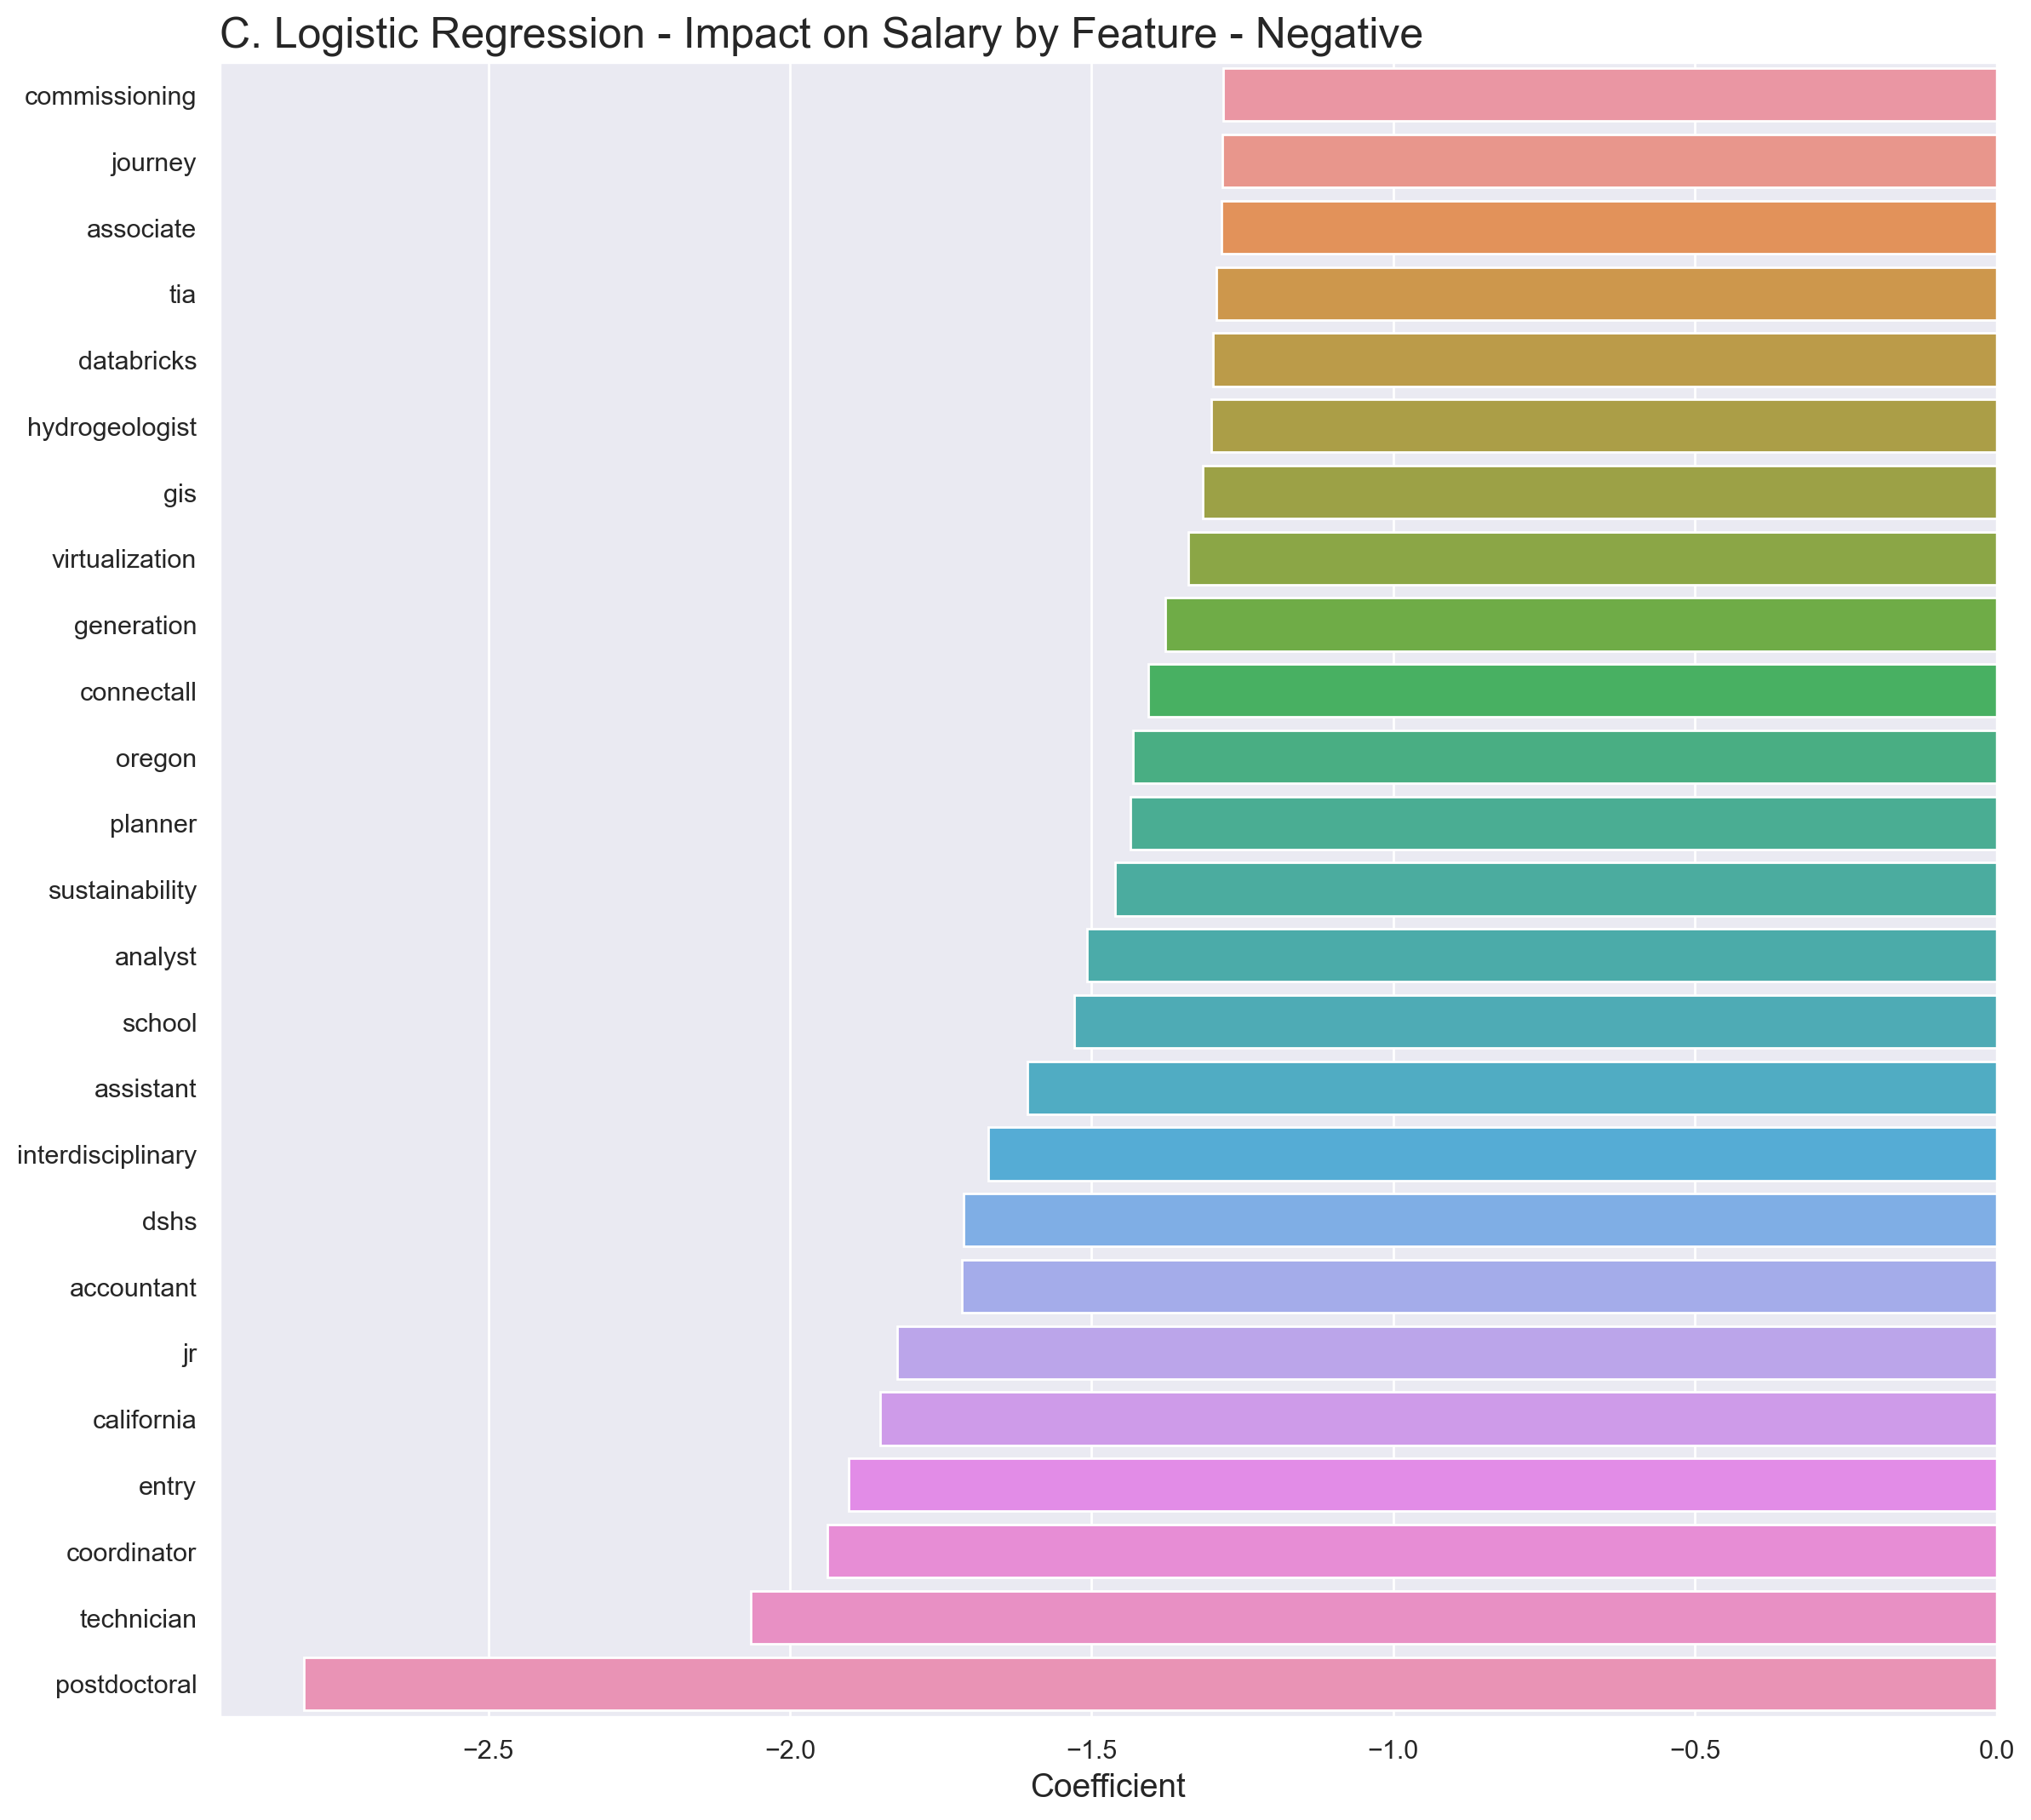

In [94]:
# Plotting the coefficients
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=lr_coef.coefficients.values, y=lr_coef.coefficients.index,
            order=lr_coef.sort_values('coefficients', ascending=False)[-25:].index, ax=ax)
ax.set_title('C. Logistic Regression - Impact on Salary by Feature - Negative', loc='left', fontsize=18)
ax.set_xlabel('Coefficient', fontsize = 14)

plt.show()

Logistic Regression coefficients describe the size and the direction of the relationship between a predictor and the target variable.  
Similarly, the odds ratio is a statistic that quantifies the strength of the association between two events.

In this model, job titles containing **startup**, **fullstack** and **quantitative** have a large influence on having a high paying salary since their coefficients are positive and relatively large: there is a 1,058% increase in the odds of earning a high salary with a job title related to startup (947% for fullstack and 787% for quantitative).
On the other side, job titles containing **postdoctoral**, **technician** and **coordinator** have relatively large (and negative) coefficients, so for those openings the salary would likely be well below median: there is a 94% decrease in the odds of earning a high salary (or a 94% increase in the odds of earning a low salary) with a job title related to postdoctoral (87% for technician and 86% for coordinator).  

<br/><br/>

In [95]:
# CHECK COMMENTS ABOVE

Classification Report

In [96]:
predictions = logreg.predict(X_test_cvec)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1320
           1       0.81      0.82      0.81      1352

    accuracy                           0.81      2672
   macro avg       0.81      0.81      0.81      2672
weighted avg       0.81      0.81      0.81      2672



Confusion Matrix

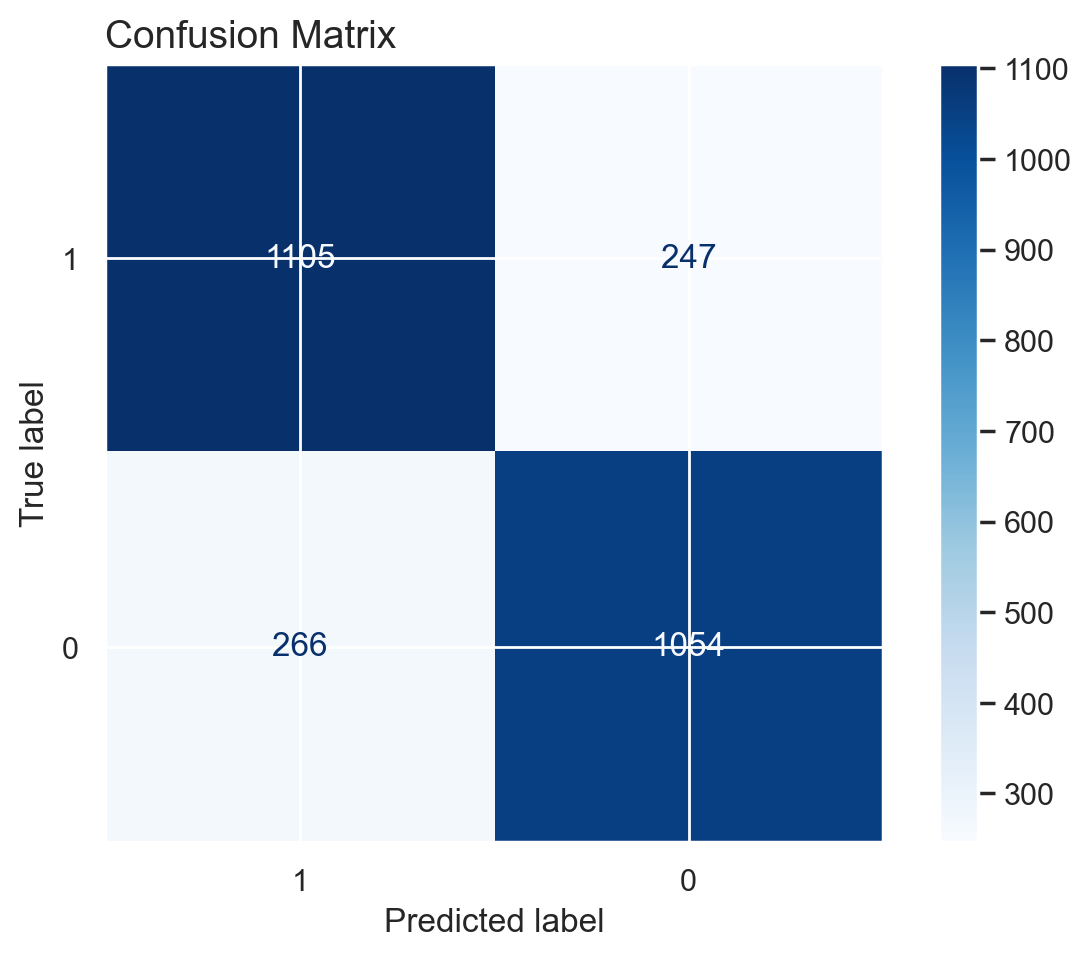

In [97]:
plot_confusion_matrix(logreg, X_test_cvec, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

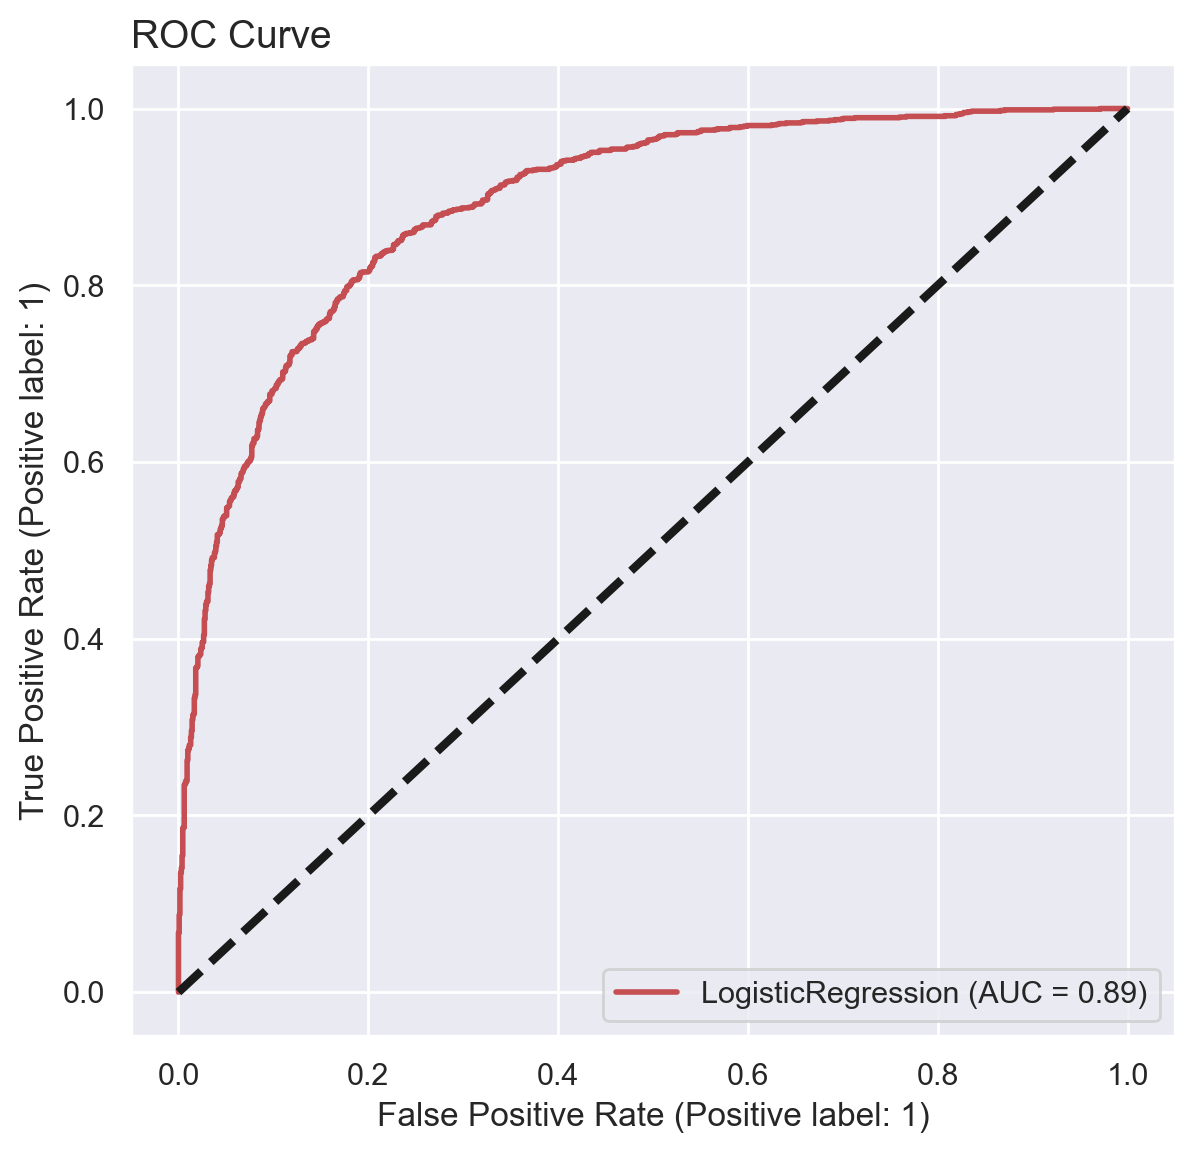

In [98]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(logreg, X_test_cvec, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [99]:
print('ROC-AUC Score:', roc_auc_score(y_test, logreg.predict_proba(X_test_cvec)[:, 1]))

ROC-AUC Score: 0.8920376098260713


Precision-Recall Curve

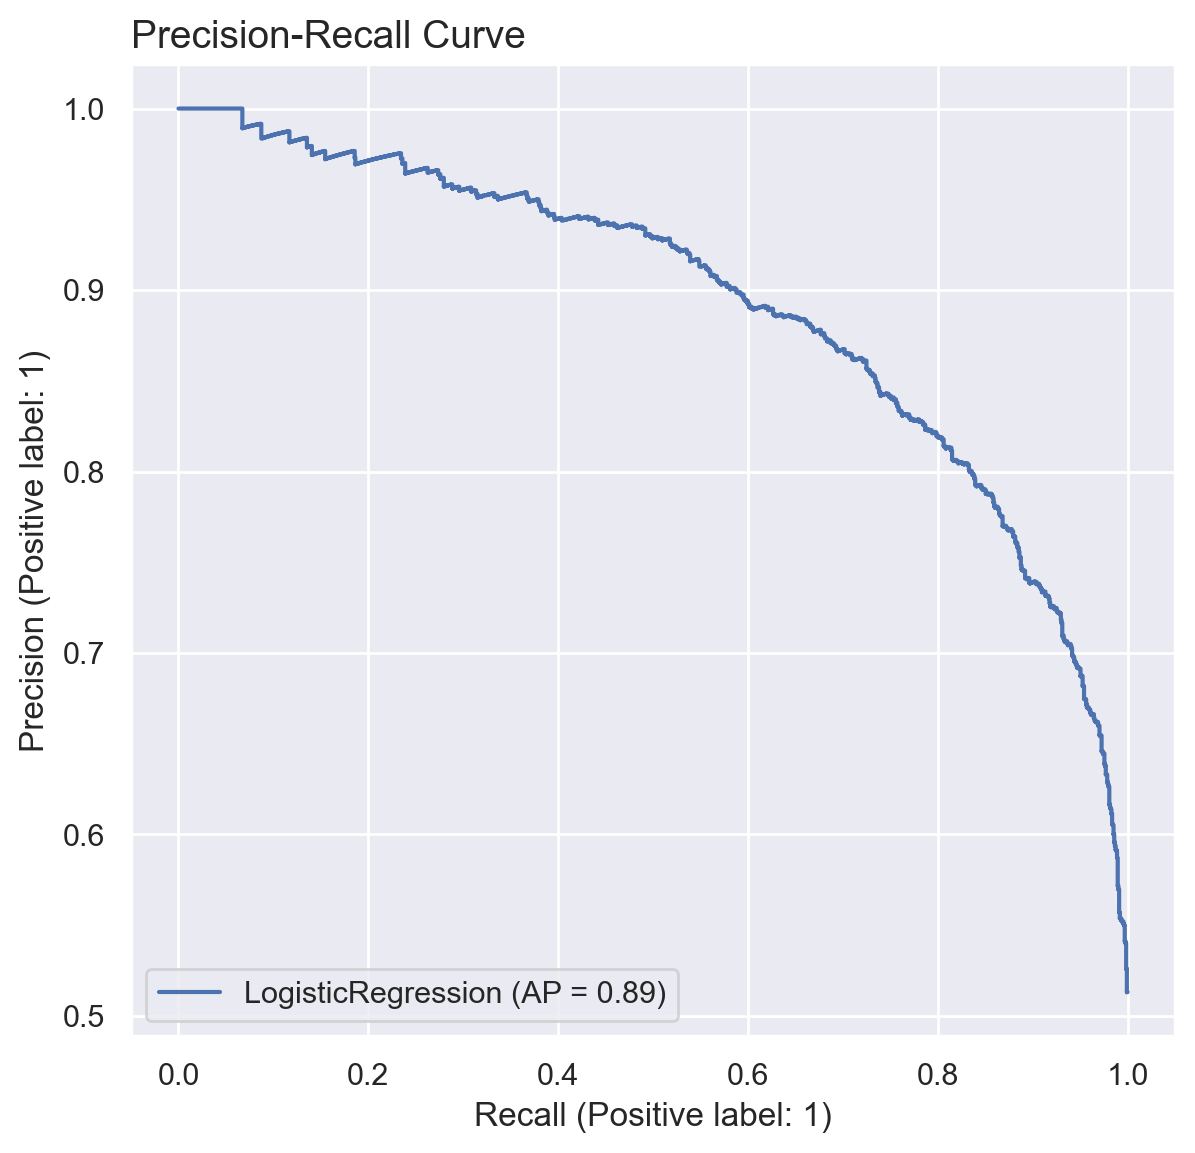

In [100]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(logreg, X_test_cvec, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is good.  
The ROC area under the curve is **0.89**, which tells us that this model has a good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.89**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.75** when recall is around **0.90**.  

<br/><br/>

#### Decision Tree with GridSearchCV

In [101]:
# Defining gridsearch parameters
dtree_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]}


# Defining the model
dtree = DecisionTreeClassifier(random_state = 1)

# Instantiating the gridsearch
dtc_gs = GridSearchCV(dtree, dtree_params, cv=5, n_jobs=10, verbose=1)

# Fitting the gridsearch
dtc_gs.fit(X_train_cvec, y_train)

# Extracting the model with the best parameters found in the gridsearch
dt_best = dtc_gs.best_estimator_

# Calculating the scores
c_dt_train = dt_best.score(X_train_cvec, y_train)
c_dt_test = dt_best.score(X_test_cvec, y_test)
c_dt_cv = (cross_val_score(dt_best, X_train_cvec, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
c_dt_df = pd.DataFrame([c_dt_train, c_dt_test, c_dt_cv],
                       index = ['train', 'test', 'CV'], columns = ['C. Decision Tree'])

print('C. Decision Tree Classifier Scores: \n')
print('train score: ', c_dt_train)
print('test score: ', c_dt_test)
print('CV score: ', c_dt_cv)

Fitting 5 folds for each of 1936 candidates, totalling 9680 fits
C. Decision Tree Classifier Scores: 

train score:  0.9460142215568862
test score:  0.8061377245508982
CV score:  0.7991204282766281


Feature Importance & Model Coefficients

In [102]:
# Collecting the model coefficients in a dataframe
dt_coef = pd.DataFrame(dt_best.feature_importances_, columns=['importance'], index=X_train_cvec.columns)
dt_coef.sort_values(by = 'importance', ascending = False)[:10]

importance
engineer                   0.106156
work_arrangement_Remote    0.033533
director                   0.032078
architect                  0.030240
company_state_NY           0.021820
scientist                  0.021746
data                       0.019823
principal                  0.019283
senior                     0.018784
company_state_CA           0.016292

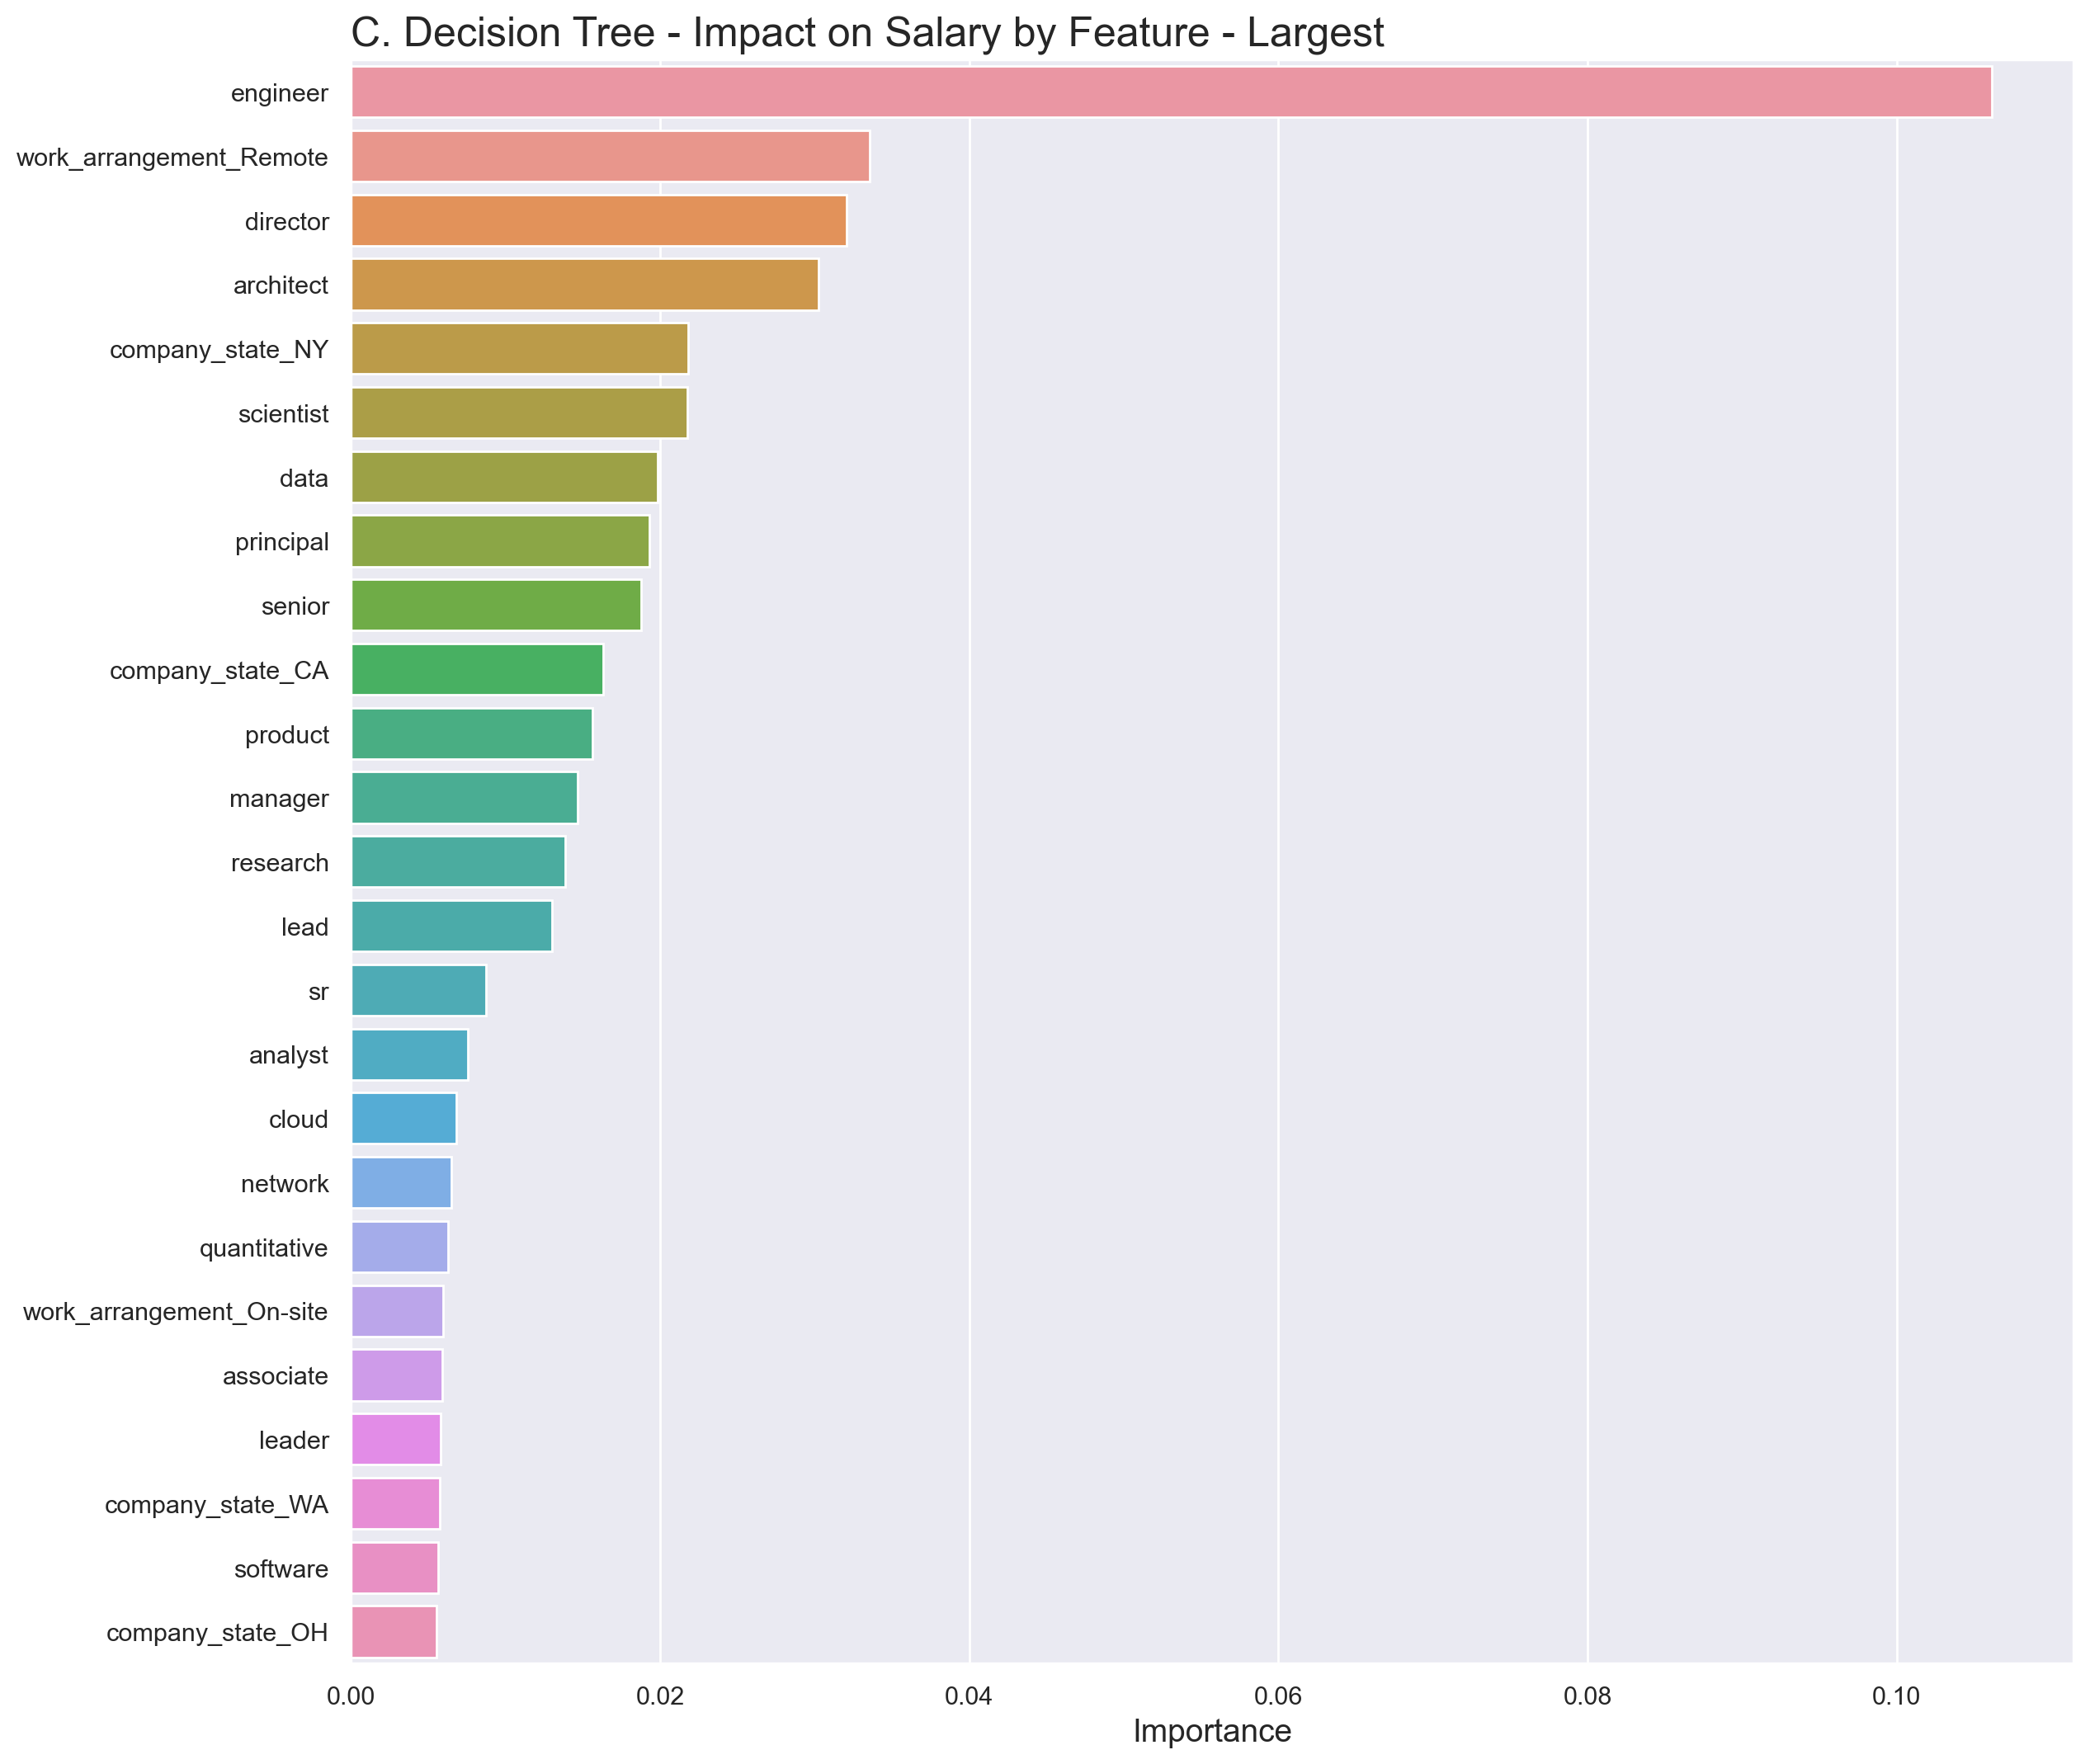

In [103]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=dt_coef.importance.values, y=dt_coef.importance.index,
            order=dt_coef.sort_values('importance', ascending=False)[:25].index, ax=ax)
ax.set_title('C. Decision Tree - Impact on Salary by Feature - Largest', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show()

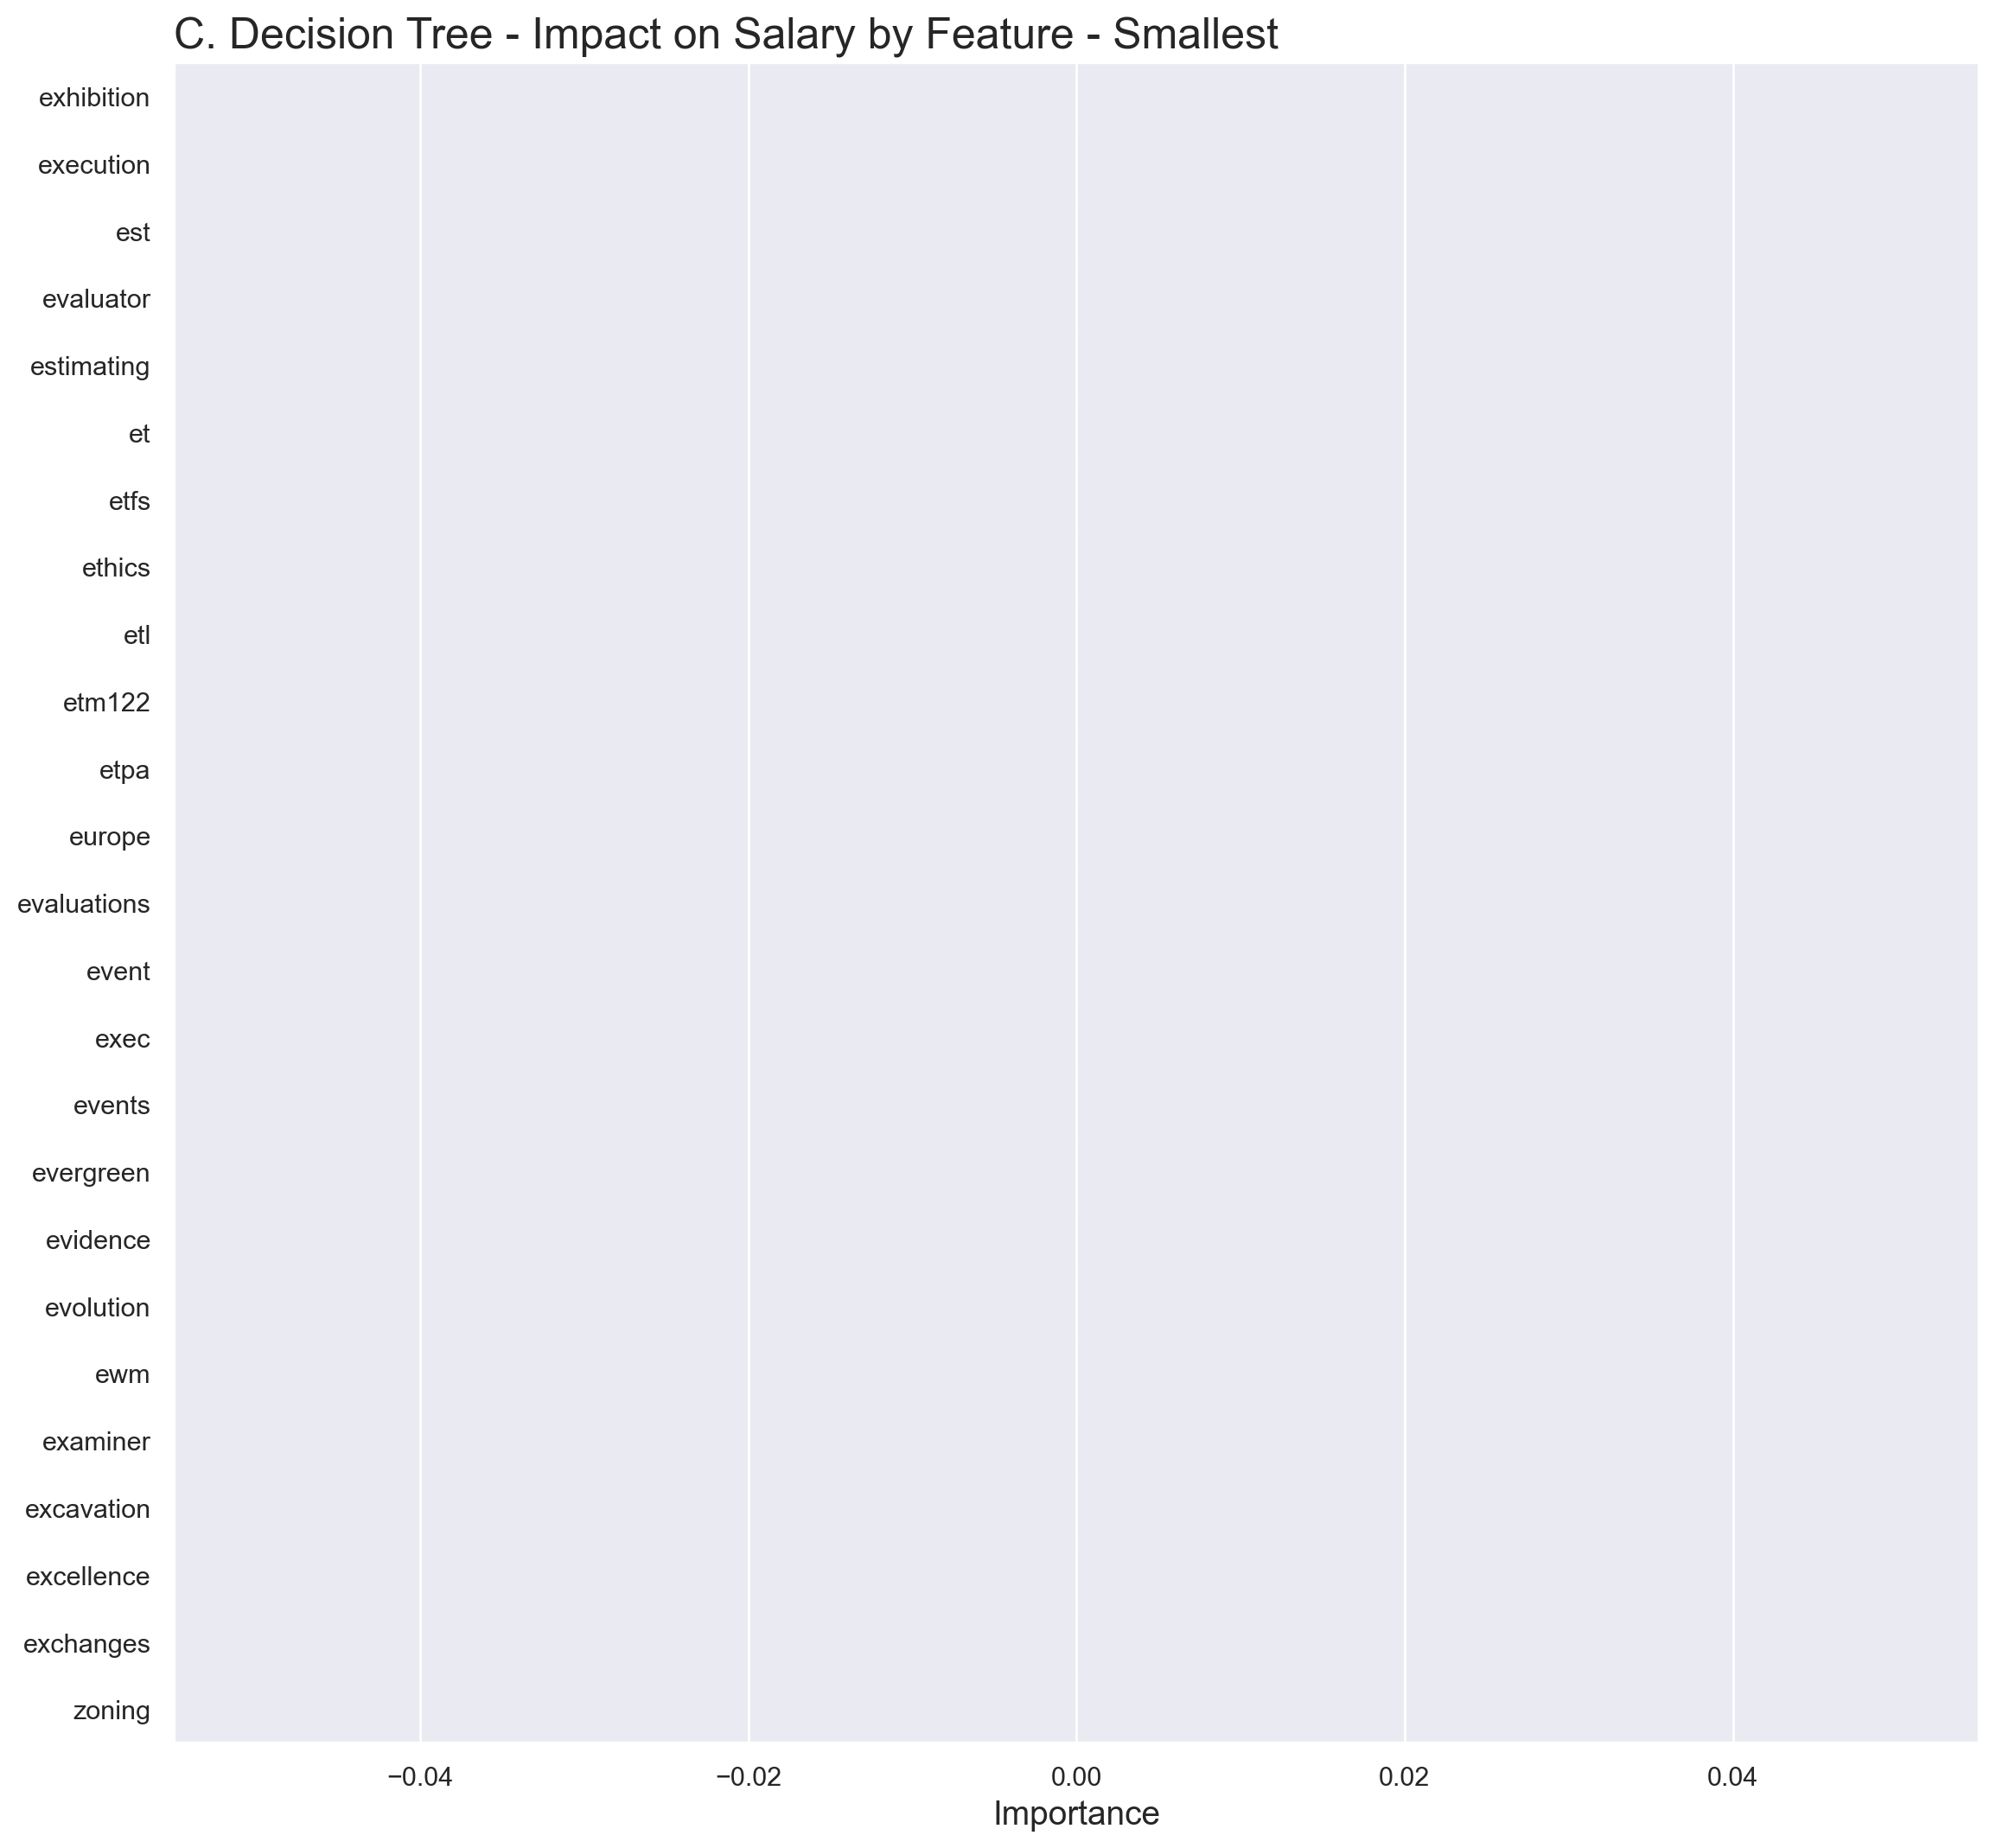

In [104]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=dt_coef.importance.values, y=dt_coef.importance.index,
            order=dt_coef.sort_values('importance', ascending=False)[-25:].index, ax=ax)
ax.set_title('C. Decision Tree - Impact on Salary by Feature - Smallest', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show()

Classification Report

In [105]:
predictions = dt_best.predict(X_test_cvec)

print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80      1320
           1       0.81      0.81      0.81      1352

    accuracy                           0.81      2672
   macro avg       0.81      0.81      0.81      2672
weighted avg       0.81      0.81      0.81      2672



Confusion Matrix

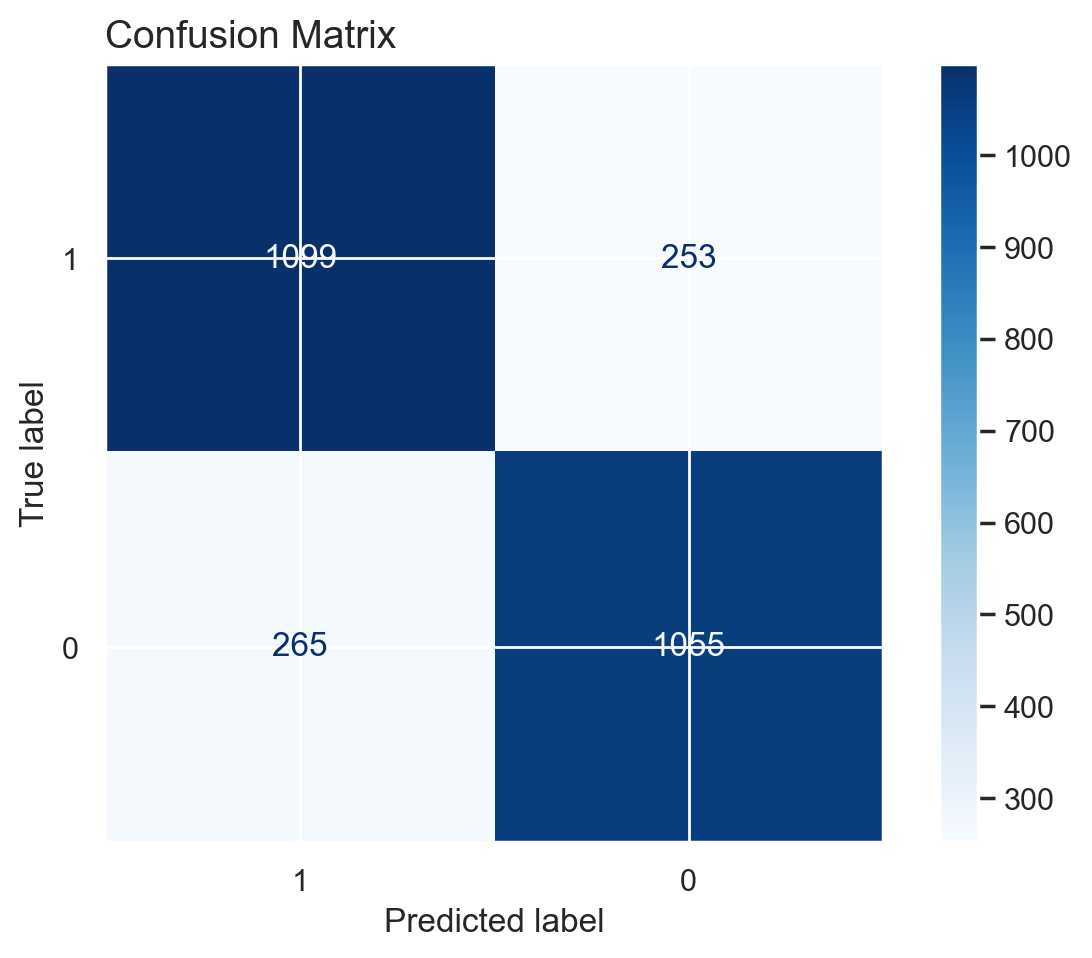

In [106]:
plot_confusion_matrix(dt_best, X_test_cvec, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

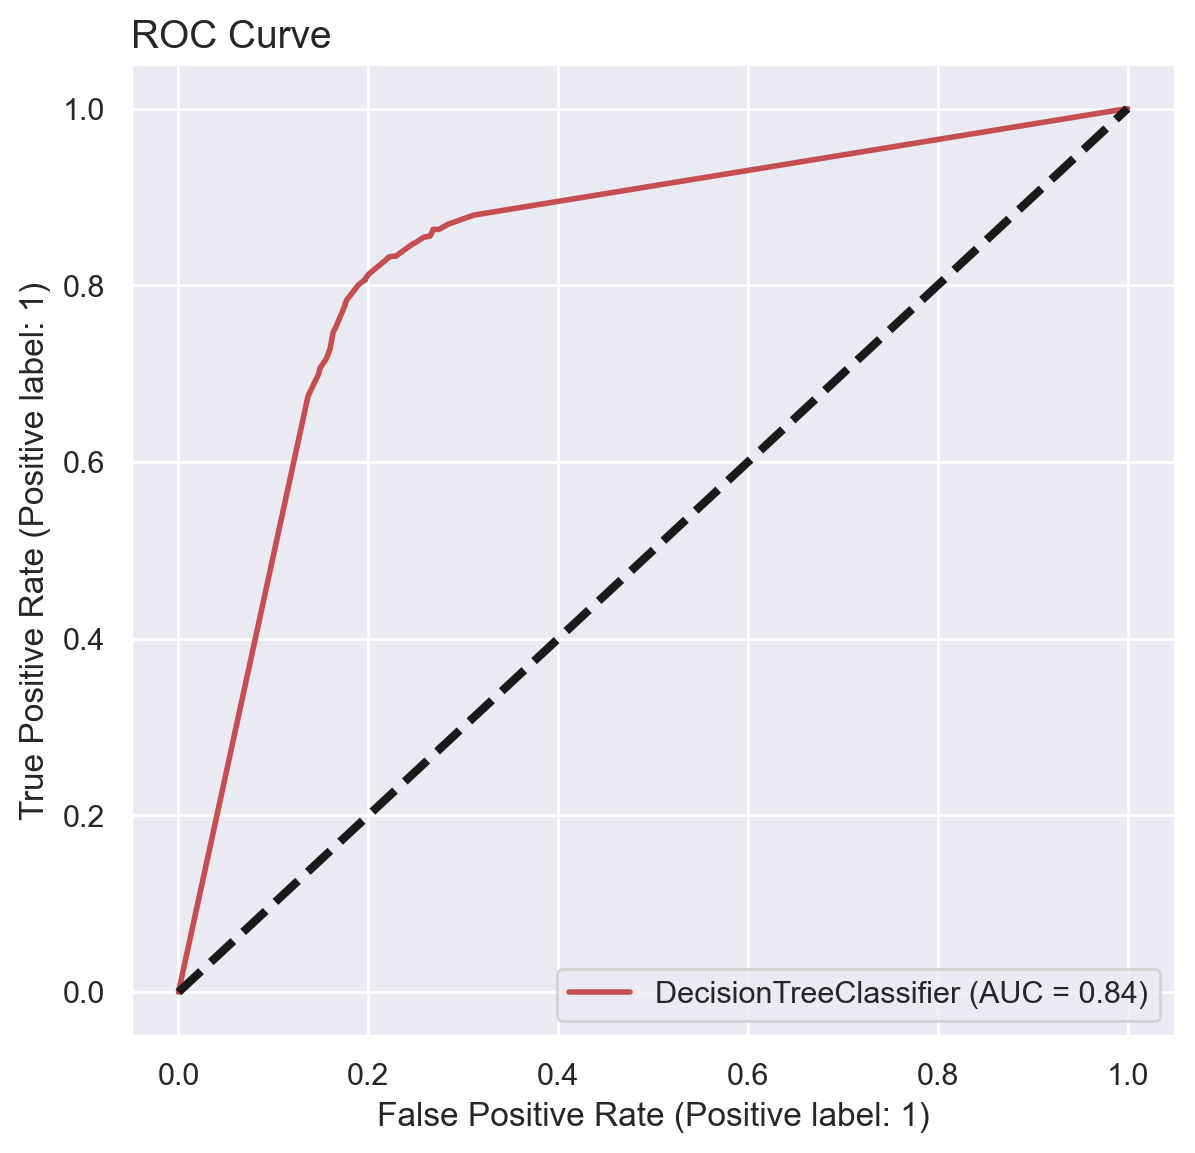

In [107]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(dt_best, X_test_cvec, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [108]:
print('ROC-AUC Score:', roc_auc_score(y_test, dt_best.predict_proba(X_test_cvec)[:, 1]))

ROC-AUC Score: 0.8356055002689619


Precision-Recall Curve

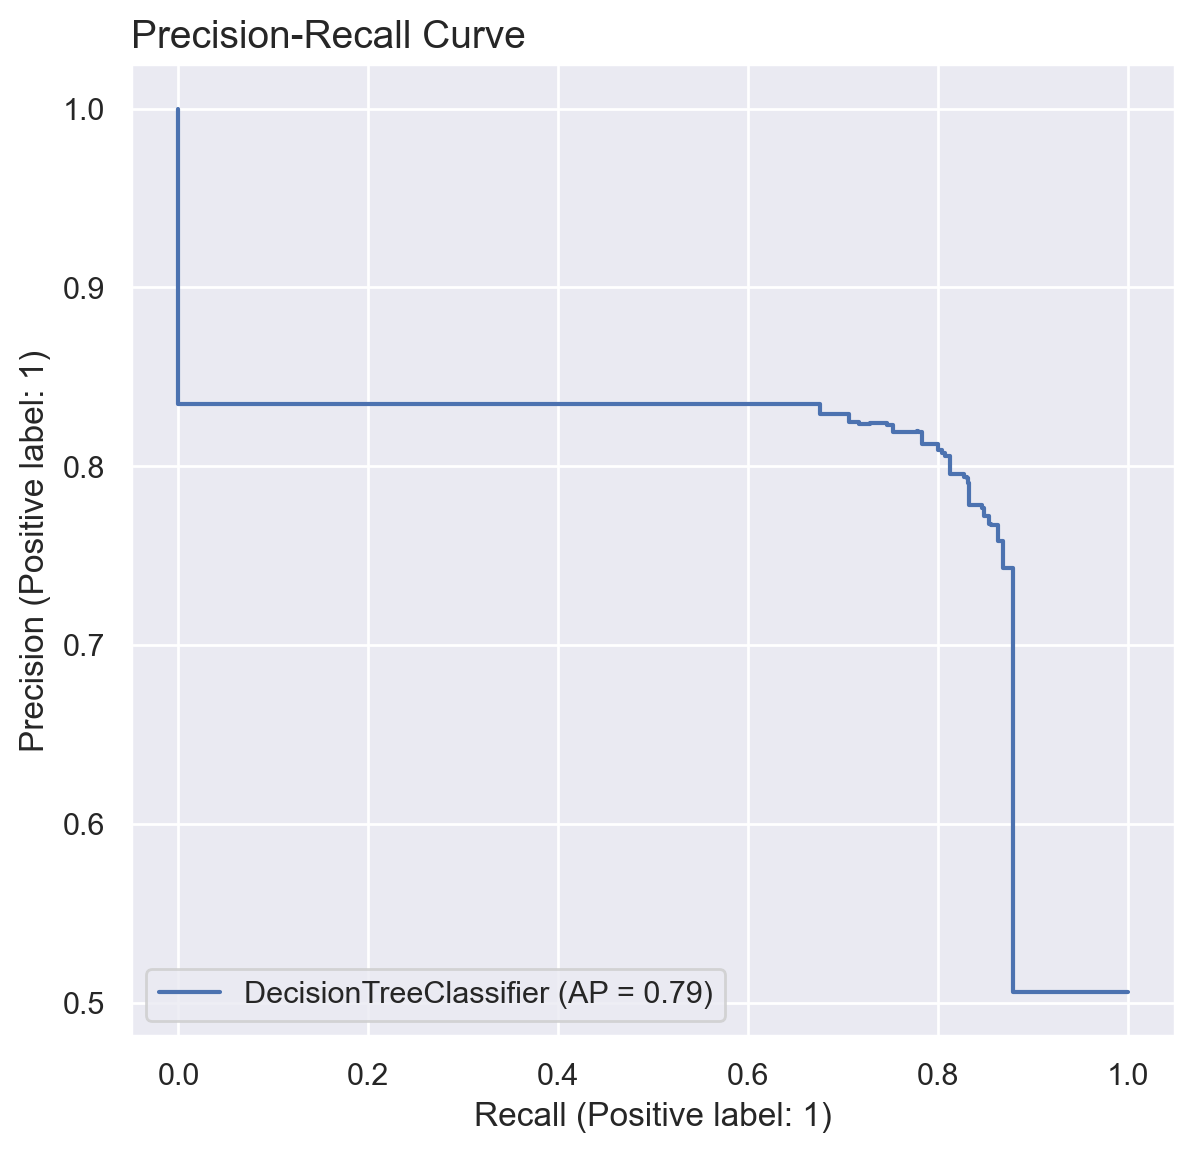

In [109]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(dt_best, X_test_cvec, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

#### Random Forest with GridSearchCV

In [ ]:
# Defining gridsearch parameters
randf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 5, 7]}

# Defining the model
randf = RandomForestClassifier(random_state = 1)

# Instantiating the gridsearch
rfc_gs = GridSearchCV(randf, randf_params, cv=5, n_jobs=10, verbose=1)

# Fitting the gridsearch
rfc_gs.fit(X_train_cvec, y_train)

# Extracting the model with the best parameters found in the gridsearch
rf_best = rfc_gs.best_estimator_

# Calculating the scores
c_rf_train = rf_best.score(X_train_cvec, y_train)
c_rf_test = rf_best.score(X_test_cvec, y_test)
c_rf_cv = (cross_val_score(rf_best, X_train_cvec, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
c_rf_df = pd.DataFrame([c_rf_train, c_rf_test, c_rf_cv],
                       index = ['train', 'test', 'CV'], columns = ['C. Random Forest'])

print('C. Random Forest Classifier Scores: \n')
print('train score: ', c_rf_train)
print('test score: ', c_rf_test)
print('CV score: ', c_rf_cv)

Fitting 5 folds for each of 1650 candidates, totalling 8250 fits


Feature Importance & Model Coefficients

In [ ]:
# Collecting the model coefficients in a dataframe
rf_coef = pd.DataFrame(rf_best.feature_importances_, columns=['importance'], index=X_train_cvec.columns)
rf_coef.sort_values(by = 'importance', ascending = False)[:10]

In [ ]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=rf_coef.importance.values, y=rf_coef.importance.index,
            order=rf_coef.sort_values('importance', ascending=False)[:25].index, ax=ax)
ax.set_title('C. Random Forest - Impact on Salary by Feature - Largest', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show() 

In [ ]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=rf_coef.importance.values, y=rf_coef.importance.index,
            order=rf_coef.sort_values('importance', ascending=False)[-25:].index, ax=ax)
ax.set_title('C. Random Forest - Impact on Salary by Feature - Smallest', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show() 

Classification Report

In [ ]:
predictions = rf_best.predict(X_test_cvec)

print(metrics.classification_report(y_test, predictions))

Confusion Matrix

In [ ]:
plot_confusion_matrix(rf_best, X_test_cvec, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(rf_best, X_test_cvec, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [ ]:
print('ROC-AUC Score:', roc_auc_score(y_test, rf_best.predict_proba(X_test_cvec)[:, 1]))

Precision-Recall Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(rf_best, X_test_cvec, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is good.  
The area under the curve is **0.91**, which tells us that this model has a very good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.91**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.8** when recall is around **0.9**.  

<br/><br/>

#### Model Scores Evaluation

In [ ]:
C_models = pd.concat([c_logreg_df, c_dt_df, c_rf_df], axis = 1)
C_models

### *D. Using additional features created with TfidfVectorizer*

In [ ]:
# Copying X_train and X_test
X_train_tvec = X_train.copy()
X_test_tvec = X_test.copy()

In [ ]:
# Instantiating and fitting TfidfVectorizer on the job title column
tvec = TfidfVectorizer(stop_words = 'english')
tvec.fit(X_train_tvec['job_title'])

In [ ]:
# Transforming and displaying the training set
X_train_job_title_t = pd.DataFrame(tvec.transform(X_train_tvec['job_title']).toarray(),
                                   columns=tvec.get_feature_names_out())
X_train_job_title_t.head()

In [ ]:
# Transforming the test set
X_test_job_title_t = pd.DataFrame(tvec.transform(X_test_tvec['job_title']).toarray(),
                                  columns=tvec.get_feature_names_out())

In [ ]:
# Displaying the most frequent words in the training set
X_train_job_title_t.sum(axis = 0).sort_values(ascending = False).iloc[:20]

In [ ]:
# Resetting X_train index to concatenate vectorised matrix back
X_train_tvec.reset_index(drop = True, inplace = True)
# Dropping the job title column as this information is in the vectorised matrix
X_train_tvec.drop(columns = ['job_title'], inplace = True)

In [ ]:
# Concatenating the vectorised matrix to the original dataframe
X_train_tvec = pd.concat([X_train_tvec, X_train_job_title_t], axis = 1)
X_train_tvec.head()

In [ ]:
# Resetting X_test index to concatenate vectorised matrix back
X_test_tvec.reset_index(drop = True, inplace = True)
# Dropping the job title column as this information is in the vectorised matrix
X_test_tvec.drop(columns = ['job_title'], inplace = True)

In [ ]:
# Concatenating the vectorised matrix to the original dataframe
X_test_tvec = pd.concat([X_test_tvec, X_test_job_title_t], axis = 1)
X_test_tvec.head()

#### Logistic Regression

In [ ]:
# Instantiating the model 
logreg = LogisticRegression(solver='saga', multi_class='auto', max_iter=1000)

# Fitting the model
logreg.fit(X_train_tvec, y_train)

# Calculating scores
d_logreg_train = logreg.score(X_train_tvec, y_train)
d_logreg_test = logreg.score(X_test_tvec, y_test)
d_logreg_cv = (cross_val_score(logreg, X_train_tvec, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
d_logreg_df = pd.DataFrame([d_logreg_train, d_logreg_test, d_logreg_cv],
                           index = ['train', 'test', 'CV'], columns=['D. Logistic Reg'])

print('D. Logistic Regression Scores: \n')
print('train score: ', d_logreg_train)
print('test score: ', d_logreg_test)
print('CV score: ', d_logreg_cv)

Feature Importance & Model Coefficients

In [ ]:
# Collecting the model coefficients in a dataframe
lr_coef = pd.DataFrame(logreg.coef_[0], index=X_train_tvec.columns, columns=['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[:5]

In [ ]:
# Adding odds ratios in the dataframe
lr_coef['odds_ratio'] = np.exp(lr_coef['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[:25]

In [ ]:
# Adding odds ratios in the dataframe
lr_coef['odds_ratio'] = np.exp(lr_coef['coefficients'])
lr_coef.sort_values(by = 'coefficients', ascending = False)[-25:]

In [ ]:
# Plotting the coefficients
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=lr_coef.coefficients.values, y=lr_coef.coefficients.index,
            order=lr_coef.sort_values('coefficients', ascending=False)[:25].index, ax=ax)
ax.set_title('D. Logistic Regression - Impact on Salary by Feature - Positive', loc='left', fontsize=18)
ax.set_xlabel('Coefficient', fontsize = 14)

plt.show()

In [ ]:
# Plotting the coefficients
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=lr_coef.coefficients.values, y=lr_coef.coefficients.index,
            order=lr_coef.sort_values('coefficients', ascending=False)[-25:].index, ax=ax)
ax.set_title('D. Logistic Regression - Impact on Salary by Feature - Negative', loc='left', fontsize=18)
ax.set_xlabel('Coefficient', fontsize = 14)

plt.show()

Logistic Regression coefficients describe the size and the direction of the relationship between a predictor and the target variable.  
Similarly, the odds ratio is a statistic that quantifies the strength of the association between two events.

In this model, job titles containing **startup**, **fullstack** and **quantitative** have a large influence on having a high paying salary since their coefficients are positive and relatively large: there is a 1,058% increase in the odds of earning a high salary with a job title related to startup (947% for fullstack and 787% for quantitative).
On the other side, job titles containing **postdoctoral**, **technician** and **coordinator** have relatively large (and negative) coefficients, so for those openings the salary would likely be well below median: there is a 94% decrease in the odds of earning a high salary (or a 94% increase in the odds of earning a low salary) with a job title related to postdoctoral (87% for technician and 86% for coordinator).  

<br/><br/>

In [ ]:
# COMMENTS TO BE UPDATED

Classification Report

In [ ]:
predictions = logreg.predict(X_test_tvec)

print(metrics.classification_report(y_test, predictions))

Confusion Matrix

In [ ]:
plot_confusion_matrix(logreg, X_test_tvec, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(logreg, X_test_tvec, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [ ]:
print('ROC-AUC Score:', roc_auc_score(y_test, logreg.predict_proba(X_test_tvec)[:, 1]))

Precision-Recall Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(logreg, X_test_tvec, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is good.  
The ROC area under the curve is **0.88**, which tells us that this model has a good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.88**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.75** when recall is around **0.90**.  

<br/><br/>

#### Decision Tree with GridSearchCV

In [ ]:
# Defining gridsearch parameters
dtree_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]}


# Defining the model
dtree = DecisionTreeClassifier(random_state = 1)

# Instantiating the gridsearch
dtc_gs = GridSearchCV(dtree, dtree_params, cv=5, n_jobs=10, verbose=1)

# Fitting the gridsearch
dtc_gs.fit(X_train_tvec, y_train)

# Extracting the model with the best parameters found in the gridsearch
dt_best = dtc_gs.best_estimator_

# Calculating the scores
d_dt_train = dt_best.score(X_train_tvec, y_train)
d_dt_test = dt_best.score(X_test_tvec, y_test)
d_dt_cv = (cross_val_score(dt_best, X_train_tvec, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
d_dt_df = pd.DataFrame([d_dt_train, d_dt_test, d_dt_cv],
                       index = ['train', 'test', 'CV'], columns = ['D. Decision Tree'])

print('D. Decision Tree Classifier Scores: \n')
print('train score: ', d_dt_train)
print('test score: ', d_dt_test)
print('CV score: ', d_dt_cv)

Feature Importance & Model Coefficients

In [ ]:
# Collecting the model coefficients in a dataframe
dt_coef = pd.DataFrame(dt_best.feature_importances_, columns=['importance'], index=X_train_tvec.columns)
dt_coef.sort_values(by = 'importance', ascending = False)[:10]

In [ ]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=dt_coef.importance.values, y=dt_coef.importance.index,
            order=dt_coef.sort_values('importance', ascending=False)[:25].index, ax=ax)
ax.set_title('D. Decision Tree - Impact on Salary by Feature - Largest', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show()

In [ ]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=dt_coef.importance.values, y=dt_coef.importance.index,
            order=dt_coef.sort_values('importance', ascending=False)[-25:].index, ax=ax)
ax.set_title('D. Decision Tree - Impact on Salary by Feature - Smallest', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show()

Classification Report

In [ ]:
predictions = dt_best.predict(X_test_tvec)

print(metrics.classification_report(y_test, predictions))

Confusion Matrix

In [ ]:
plot_confusion_matrix(dt_best, X_test_tvec, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(dt_best, X_test_tvec, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [ ]:
print('ROC-AUC Score:', roc_auc_score(y_test, dt_best.predict_proba(X_test_tvec)[:, 1]))

Precision-Recall Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(dt_best, X_test_tvec, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

The f1-score is balanced between the two classes, and the accuracy of the model is good.  
The ROC area under the curve is **0.80**, which tells us that this model has a good class separation capacity.  
The precision-recall curve shows the tradeoff between precision and recall for different threshold; here the PR-AUC is **0.75**, the curve descends in a typical non-monotonic fashion, and the precision decreases significantly at **0.75** when recall is around **0.90**.  

<br/><br/>


Comments to be UPDATED

#### Random Forest with GridSearchCV

In [ ]:
# Defining gridsearch parameters
randf_params = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 5, 7]}

# Defining the model
randf = RandomForestClassifier(random_state = 1)

# Instantiating the gridsearch
rfc_gs = GridSearchCV(randf, randf_params, cv=5, n_jobs=10, verbose=1)

# Fitting the gridsearch
rfc_gs.fit(X_train_tvec, y_train)

# Extracting the model with the best parameters found in the gridsearch
rf_best = rfc_gs.best_estimator_

# Calculating the scores
d_rf_train = rf_best.score(X_train_tvec, y_train)
d_rf_test = rf_best.score(X_test_tvec, y_test)
d_rf_cv = (cross_val_score(rf_best, X_train_tvec, y_train, cv = 10)).mean()

# Collecting the scores in a dataframe to compare different models later
d_rf_df = pd.DataFrame([d_rf_train, d_rf_test, d_rf_cv],
                       index = ['train', 'test', 'CV'], columns = ['D. Random Forest'])

print('D. Random Forest Classifier Scores: \n')
print('train score: ', d_rf_train)
print('test score: ', d_rf_test)
print('CV score: ', d_rf_cv)

Feature Importance & Model Coefficients

In [ ]:
# Collecting the model coefficients in a dataframe
rf_coef = pd.DataFrame(rf_best.feature_importances_, columns=['importance'], index=X_train_tvec.columns)
rf_coef.sort_values(by = 'importance', ascending = False)[:10]

In [ ]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=rf_coef.importance.values, y=rf_coef.importance.index,
            order=rf_coef.sort_values('importance', ascending=False)[:25].index, ax=ax)
ax.set_title('D. Random Forest - Impact on Salary by Feature - Largest', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show() 

In [ ]:
# Plotting the feature importances
fig, ax = plt.subplots(figsize = (12,12))

sns.barplot(x=rf_coef.importance.values, y=rf_coef.importance.index,
            order=rf_coef.sort_values('importance', ascending=False)[-25:].index, ax=ax)
ax.set_title('D. Random Forest - Impact on Salary by Feature - Smallest', loc='left', fontsize=18)
ax.set_xlabel('Importance', fontsize = 14)

plt.show() 

In [ ]:
# Comments

Classification Report

In [ ]:
predictions = rf_best.predict(X_test_tvec)

print(metrics.classification_report(y_test, predictions))

Confusion Matrix

In [ ]:
plot_confusion_matrix(rf_best, X_test_tvec, y_test, cmap='Blues', labels=[1, 0])
plt.title('Confusion Matrix', loc='left', fontsize = 14)
plt.show()

ROC-AUC Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_roc_curve(rf_best, X_test_tvec, y_test, c='r', lw=2, ax=ax)
plt.title('ROC Curve', loc='left', fontsize = 14)
ax.plot([0, 1], [0, 1], 'k--', lw=3)
plt.show()

In [ ]:
print('ROC-AUC Score:', roc_auc_score(y_test, rf_best.predict_proba(X_test_tvec)[:, 1]))

Precision-Recall Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_precision_recall_curve(rf_best, X_test_tvec, y_test, ax=ax)
plt.title('Precision-Recall Curve', loc='left', fontsize = 14)
plt.show()

In [ ]:
# Comments

#### Model Scores Evaluation

In [ ]:
D_models = pd.concat([d_logreg_df, d_dt_df, d_rf_df], axis = 1)
D_models

In [ ]:
# Comments

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [ ]:
## YOUR CODE HERE

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [ ]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

In [ ]:
## YOUR TEXT HERE IN MARKDOWN FORMAT 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 